In [1]:
import sys,os

data_path = os.getcwd()

try:
    import localgraphclustering as lgc
except:
    # when the package is not installed, import the local version instead. 
    # the notebook must be placed in the original "notebooks/" folder
    sys.path.append("../")
    import localgraphclustering as lgc

In [2]:
import time
import numpy as np

import matplotlib.pyplot as plt

# Import the graph_tool module for visualization.
from graph_tool.all import * 

import statistics as stat_

# Load graph

In [3]:
# Read graph. This also supports gml format.
#g = lgc.GraphLocal(os.path.join(data_path,'datasets/JohnsHopkins.graphml'),'graphml')
g = lgc.GraphLocal(os.path.join(data_path,'datasets/Colgate88_reduced.graphml'),'graphml')
# To get a quick look at the list of methods and attributes for the graph object 'g' you can type 'g.' + tab
# and scroll up or down.

vol_G = g.vol_G

/usr/local/lib/python3.7/site-packages/localgraphclustering/GraphLocal.py:217: UserWarning:

Loading a graphml is not efficient, we suggest using an edgelist format for this API.



## Load graph using GraphTool. We do this to handle some meta-data which LocalGraphClustering is not handling yet.

In [4]:
g_gtool = load_graph('datasets/Colgate88_reduced.graphml')
remove_self_loops(g_gtool)

n = g_gtool.num_vertices()

## Load coordinates for graph layout

In [5]:
# Load pre-computed coordinates for nodes.
g_v_prop = g_gtool.vertex_properties
xx = g_v_prop.x
yy = g_v_prop.y

pos = g_gtool.new_vertex_property("vector<double>")
for i in range(n):
    pos[i] = [xx[i],yy[i]]

## Load and filter ground truth clusters. This part takes a while to run. The results are saved in results/

In [6]:
g_v_prop = g_gtool.vertex_properties
#feature_list = [g_v_prop.secondMajor,g_v_prop.highSchool,g_v_prop.gender,g_v_prop.dorm,g_v_prop.majorIndex,g_v_prop.year]
feature_list = [g_v_prop.dorm,g_v_prop.majorIndex,g_v_prop.year]

number_feature = 0

ref_nodes = []
info_ref_nodes = []

for kk in feature_list:
    
    feature = kk

    for ff in list(set(feature.a)):
        
        if ff == 0:
            continue

        feature_array = np.zeros(n)
        feature_ff_nodes = []
        for i in range(n):
            feature_array[i] = feature[i]
            if feature_array[i] == ff:
                feature_ff_nodes.append(i)

        g_ff = g_gtool.copy()

        del_list_ff = list(set(range(n)) - set(feature_ff_nodes))

        for v in reversed(sorted(del_list_ff)):
            g_ff.remove_vertex(v)   

        n_ff = g_ff.num_vertices() 

        comp_ff,hist_ff=label_components(g_ff)

        feature_ff_nodes_largest_component = []
        for i in range(n_ff):
            if comp_ff[i] == 0:
                feature_ff_nodes_largest_component.append(feature_ff_nodes[i])    

        vol_ff = sum(g.d[feature_ff_nodes_largest_component])
        
        if vol_ff < 100:
            continue
            
        #temp = np.zeros(n)
        #temp[feature_ff_nodes_largest_component] = 1
        
        #cut_ff = vol_ff - (g.adjacency_matrix.dot(temp).transpose()).dot(temp)
        #cond_ff = cut_ff/min(vol_ff,vol_G - vol_ff)
        cond_ff = g.compute_conductance(feature_ff_nodes_largest_component,cpp=True)
        
        if cond_ff > 0.47:
            continue
            
        print("Reached")
        eig_ff, lambda_ff = lgc.fiedler_local(g, feature_ff_nodes_largest_component)
        lambda_ff = np.real(lambda_ff)
        gap_ff = lambda_ff/cond_ff
        
        print("Number of feature", number_feature, "Feature value ", ff, " gap ",gap_ff, " volume: ", vol_ff, " size:", len(feature_ff_nodes_largest_component), "conductance: ", cond_ff)
        
        if gap_ff >= 0.5 and vol_ff >= 100:
            ref_nodes.append(feature_ff_nodes_largest_component)
            info_ref_nodes.append([number_feature,ff])
            np.save('results/ref_nodes_Colgate88', ref_nodes) 
            np.save('results/info_ref_nodes_Colgate88', info_ref_nodes) 
        
    number_feature += 1

Reached
Number of feature 2 Feature value  2007  gap  [0.90496458]  volume:  68381.0  size: 588 conductance:  0.41600737046840497
Reached
Number of feature 2 Feature value  2008  gap  [0.89580114]  volume:  62429.0  size: 640 conductance:  0.29311698089029137
Reached
Number of feature 2 Feature value  2009  gap  [0.87791738]  volume:  35369.0  size: 638 conductance:  0.11973762334247505


## If you have generated the ground truth datasets once, you can avoid rerunning the above code and simple run the code below.

In [7]:
ref_nodes = np.load('results/ref_nodes_Colgate88.npy') 
info_ref_nodes = np.load('results/info_ref_nodes_Colgate88.npy') 

## Visualize the ground truth clusters

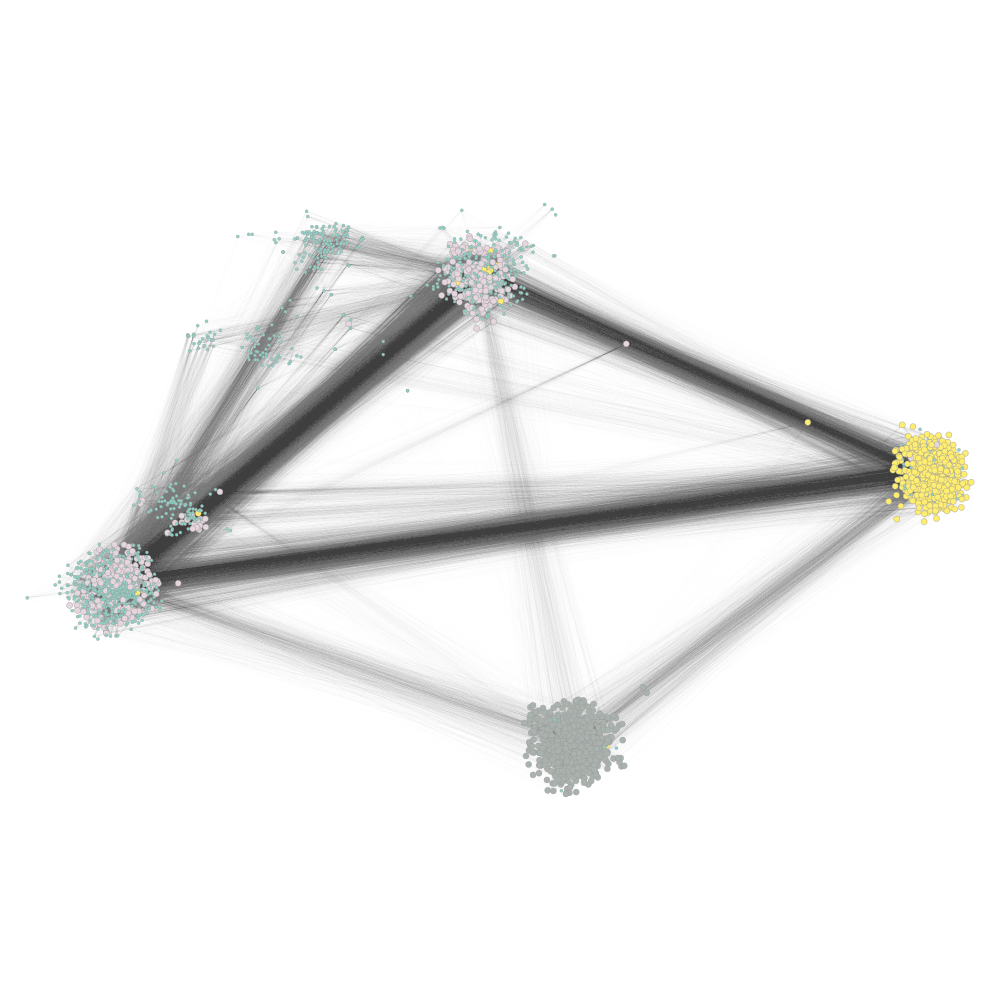

<PropertyMap object with key type 'Vertex' and value type 'vector<double>', for Graph 0x141c996d8, at 0x141c92ef0>

In [8]:
temp = np.zeros(n)
temp = temp + 3

temp2 = np.zeros(n, dtype=int)

counter = 0

for i in ref_nodes:
        
    temp[i] = 6
    
    for j in i:
        temp2[j] = int(info_ref_nodes[counter,1])
    counter += 1

node_size = g_gtool.new_vertex_property("double",temp)

node_colours = g_gtool.new_vertex_property("int",temp2)

c_map = plt.get_cmap('Dark2')

graph_draw(g_gtool, pos, output_size=(1000, 1000),
            vertex_size=node_size, 
            vertex_fill_color=node_colours,
            edge_pen_width=0.1,
            edge_color = [0.0, 0, 0, 0.05]
            )

## Results by spectral algorithm: https://dl.acm.org/citation.cfm?id=1170528 

In [9]:
nodes = {}
external_best_cond_acl = {}
external_best_pre_cond_acl = {}
gap_best_cond_acl = {}
gap_best_pre_acl = {}
vol_best_cond_acl = {}
vol_best_pre_acl = {}
size_clust_best_cond_acl = {}
size_clust_best_pre_acl = {}
f1score_best_cond_acl = {}
f1score_best_pre_acl = {}
true_positives_best_cond_acl = {}
true_positives_best_pre_acl = {}
precision_best_cond_acl = {}
precision_best_pre_acl = {}
recall_best_cond_acl = {}
recall_best_pre_acl = {}
cuts_best_cond_acl = {}
cuts_best_pre_acl = {}
cuts_acl_ALL = {}

ct_outer = 0
for rr in ref_nodes:
    
    how_many = int(len(rr)/2)
    print(how_many)
    
    nodes[ct_outer] = np.random.choice(rr, how_many, replace=False)
    
    eigv, lambda_val = lgc.fiedler_local(g, rr)
    lambda_val = np.real(lambda_val)
    
    step = (2*lambda_val - lambda_val/2)/4
    
    a_list = np.arange(lambda_val/2,2*lambda_val,step)

    ct = 0
    for node in nodes[ct_outer]:
        ref_node = [node]

        max_precision = -1
        min_conduct = 100
        
        ct_inner = 0
        for a in a_list:

            output_pr_clustering = lgc.spectral_clustering(g,ref_node,method="l1reg",alpha=a,rho=2.0e-7,epsilon=1.0e-2,iterations=1000)
            
            S_l1pr = output_pr_clustering[0]
            
            cuts_acl_ALL[ct_outer,node,ct_inner] = S_l1pr
            
            size_clust_acl_ = len(S_l1pr)
            
            cond_val_l1pr = output_pr_clustering[1]
            
            vol_ = sum(g.d[S_l1pr])
            true_positives_acl_ = set(rr).intersection(S_l1pr)
            if len(true_positives_acl_) == 0:
                true_positives_acl_ = set(ref_node)
                vol_ = g.d[ref_node][0,0]
            precision = sum(g.d[np.array(list(true_positives_acl_))])/vol_
            recall = sum(g.d[np.array(list(true_positives_acl_))])/sum(g.d[rr])
            f1_score_ = 2*(precision*recall)/(precision + recall)
            
            if f1_score_ >= max_precision:
            
                max_precision = f1_score_
            
                S_smqi, S_smqi_val = lgc.fiedler_local(g, S_l1pr)
                S_smqi_val = np.real(S_smqi_val)

                external_best_pre_cond_acl[ct_outer,node] = cond_val_l1pr
                gap_best_pre_acl[ct_outer,node] = (S_smqi_val/np.log(sum(g.d[S_l1pr])))/cond_val_l1pr
                vol_best_pre_acl[ct_outer,node] = vol_

                size_clust_best_pre_acl[ct_outer,node] = size_clust_acl_
                true_positives_best_pre_acl[ct_outer,node] = true_positives_acl_
                precision_best_pre_acl[ct_outer,node] = precision
                recall_best_pre_acl[ct_outer,node] = recall
                f1score_best_pre_acl[ct_outer,node] = f1_score_
                
                cuts_best_pre_acl[ct_outer,node] = S_l1pr
                
            if cond_val_l1pr <= min_conduct:
            
                min_conduct = cond_val_l1pr
            
                S_smqi, S_smqi_val = lgc.fiedler_local(g, S_l1pr)
                S_smqi_val = np.real(S_smqi_val)

                external_best_cond_acl[ct_outer,node] = cond_val_l1pr
                gap_best_cond_acl[ct_outer,node] = (S_smqi_val/np.log(sum(g.d[S_l1pr])))/cond_val_l1pr
                vol_best_cond_acl[ct_outer,node] = vol_

                size_clust_best_cond_acl[ct_outer,node] = size_clust_acl_
                true_positives_best_cond_acl[ct_outer,node] = true_positives_acl_
                precision_best_cond_acl[ct_outer,node] = precision
                recall_best_cond_acl[ct_outer,node] = recall
                f1score_best_cond_acl[ct_outer,node] = f1_score_
                
                cuts_best_cond_acl[ct_outer,node] = S_l1pr

        print('outer:', ct_outer, 'number of node: ',node, ' completed: ', ct/how_many, ' degree: ', g.d[node])
        print('conductance: ', external_best_cond_acl[ct_outer,node], 'f1score: ', f1score_best_pre_acl[ct_outer,node], 'precision: ', precision_best_pre_acl[ct_outer,node], 'recall: ', recall_best_pre_acl[ct_outer,node])
        ct += 1
    ct_outer += 1
    
    np.save('results/size_clust_best_cond_acl_Colgate88', size_clust_best_cond_acl) 
    np.save('results/external_best_cond_acl_Colgate88', external_best_cond_acl)
    np.save('results/vol_best_cond_acl_Colgate88', vol_best_cond_acl) 
    np.save('results/gap_best_cond_acl_Colgate88', gap_best_cond_acl) 
    np.save('results/cuts_best_cond_acl_Colgate88', cuts_best_cond_acl) 
    np.save('results/true_positives_best_cond_acl_Colgate88', true_positives_best_cond_acl)
    np.save('results/f1score_best_cond_acl_Colgate88', f1score_best_cond_acl) 
    np.save('results/precision_best_cond_acl_Colgate88', precision_best_cond_acl) 
    np.save('results/recall_best_cond_acl_Colgate88', recall_best_cond_acl) 

    np.save('results/size_clust_best_pre_acl_Colgate88', size_clust_best_pre_acl) 
    np.save('results/external_best_pre_cond_acl_Colgate88', external_best_pre_cond_acl)
    np.save('results/vol_best_pre_acl_Colgate88', vol_best_pre_acl) 
    np.save('results/gap_best_pre_acl_Colgate88', gap_best_pre_acl) 
    np.save('results/cuts_best_pre_acl_Colgate88', cuts_best_pre_acl) 
    np.save('results/true_positives_best_pre_acl_Colgate88', true_positives_best_pre_acl)
    np.save('results/f1score_best_pre_acl_Colgate88', f1score_best_pre_acl) 
    np.save('results/precision_best_pre_acl_Colgate88', precision_best_pre_acl) 
    np.save('results/recall_best_pre_acl_Colgate88', recall_best_pre_acl) 

    np.save('results/cuts_acl_ALL_Colgate88', cuts_acl_ALL) 
    
    np.save('results/nodes_Colgate88', nodes)

294
outer: 0 number of node:  3061  completed:  0.0  degree:  69.0
conductance:  0.25231872653861537 f1score:  0.5293545713782325 precision:  0.4779416963212594 recall:  0.593161843202059
outer: 0 number of node:  364  completed:  0.003401360544217687  degree:  76.0
conductance:  0.271126501141973 f1score:  0.467703820401733 precision:  0.3369858949635926 recall:  0.7641011392053348
outer: 0 number of node:  2987  completed:  0.006802721088435374  degree:  92.0
conductance:  0.2368296155671571 f1score:  0.5030695003011699 precision:  0.43074454562503905 recall:  0.6045831444407073
outer: 0 number of node:  1164  completed:  0.01020408163265306  degree:  83.0
conductance:  0.17376650979201458 f1score:  0.6143584768372544 precision:  0.5076394522116715 recall:  0.7778915195741507
outer: 0 number of node:  2468  completed:  0.013605442176870748  degree:  97.0
conductance:  0.19855871942858966 f1score:  0.5622196204806009 precision:  0.4656706959953146 recall:  0.709275968470774
outer: 0 n

outer: 0 number of node:  3180  completed:  0.13945578231292516  degree:  51.0
conductance:  0.26654037244879725 f1score:  0.5682470778482142 precision:  0.4902499575623833 recall:  0.675757885962475
outer: 0 number of node:  2670  completed:  0.14285714285714285  degree:  76.0
conductance:  0.18264470249347375 f1score:  0.7457139373247164 precision:  0.6394462510063886 recall:  0.8943419955835685
outer: 0 number of node:  2249  completed:  0.14625850340136054  degree:  398.0
conductance:  0.29727812177502577 f1score:  0.5817962491365177 precision:  0.44927190070142753 recall:  0.8252146063965137
outer: 0 number of node:  1330  completed:  0.14965986394557823  degree:  68.0
conductance:  0.14130967128575955 f1score:  0.6066194900730966 precision:  0.5043373750884437 recall:  0.7609423670317779
outer: 0 number of node:  3203  completed:  0.15306122448979592  degree:  51.0
conductance:  0.39232650111934764 f1score:  0.25084927828130243 precision:  0.18074224091225716 recall:  0.409806817

outer: 0 number of node:  3465  completed:  0.2789115646258503  degree:  194.0
conductance:  0.18360004962163504 f1score:  0.6026219154815019 precision:  0.5098001517834556 recall:  0.7367689855369182
outer: 0 number of node:  235  completed:  0.282312925170068  degree:  70.0
conductance:  0.1616020039960636 f1score:  0.4903966232638501 precision:  0.3533509643294846 recall:  0.8010997206826458
outer: 0 number of node:  3333  completed:  0.2857142857142857  degree:  111.0
conductance:  0.14568113450795014 f1score:  0.6381273539458702 precision:  0.5099614142845893 recall:  0.852342024831459
outer: 0 number of node:  2415  completed:  0.2891156462585034  degree:  111.0
conductance:  0.19439469632701795 f1score:  0.5787717824651895 precision:  0.4859401849479027 recall:  0.7154472733654085
outer: 0 number of node:  1974  completed:  0.2925170068027211  degree:  106.0
conductance:  0.16874772699721177 f1score:  0.7045602399580879 precision:  0.5810133313076835 recall:  0.8948392097219988


outer: 0 number of node:  904  completed:  0.41836734693877553  degree:  77.0
conductance:  0.19400730202694197 f1score:  0.495440712510819 precision:  0.4007352941176471 recall:  0.6487620830347611
outer: 0 number of node:  389  completed:  0.4217687074829932  degree:  63.0
conductance:  0.3455598704666555 f1score:  0.4461224453257182 precision:  0.3214476917817497 recall:  0.728784311431538
outer: 0 number of node:  789  completed:  0.42517006802721086  degree:  213.0
conductance:  0.15143509066890837 f1score:  0.6475283669884357 precision:  0.531875693256378 recall:  0.8274520700194499
outer: 0 number of node:  2418  completed:  0.42857142857142855  degree:  1.0
conductance:  0.256335156895128 f1score:  0.43824280148672246 precision:  0.3158349953849828 recall:  0.7155788888726401
outer: 0 number of node:  2801  completed:  0.43197278911564624  degree:  74.0
conductance:  0.2585117845552322 f1score:  0.4412154300545959 precision:  0.3178831434301227 recall:  0.7209166288881415
outer

outer: 0 number of node:  2745  completed:  0.5612244897959183  degree:  20.0
conductance:  0.12545009361947285 f1score:  0.4018120541249086 precision:  0.2518677340139032 recall:  0.9929366344452406
outer: 0 number of node:  3162  completed:  0.564625850340136  degree:  98.0
conductance:  0.2413385161399358 f1score:  0.6496943209377527 precision:  0.5717858929464732 recall:  0.7521826238282564
outer: 0 number of node:  2085  completed:  0.5680272108843537  degree:  123.0
conductance:  0.16257127145379294 f1score:  0.6260112009956441 precision:  0.5297578660617538 recall:  0.7650078238107076
outer: 0 number of node:  1744  completed:  0.5714285714285714  degree:  131.0
conductance:  0.21125815697993536 f1score:  0.5423801527278966 precision:  0.4668354697473229 recall:  0.6470949532764949
outer: 0 number of node:  2471  completed:  0.5748299319727891  degree:  139.0
conductance:  0.24542956301848817 f1score:  0.4562544220245932 precision:  0.3288130998560668 recall:  0.7450022667115135

outer: 0 number of node:  1536  completed:  0.7040816326530612  degree:  106.0
conductance:  0.1678599379692165 f1score:  0.5801821388559195 precision:  0.46732963429561925 recall:  0.764890832248724
outer: 0 number of node:  2285  completed:  0.7074829931972789  degree:  42.0
conductance:  0.19000278732695344 f1score:  0.3949702176337029 precision:  0.2460969700896698 recall:  0.9997660168760328
outer: 0 number of node:  211  completed:  0.7108843537414966  degree:  47.0
conductance:  0.22997348348446656 f1score:  0.5917437849543988 precision:  0.4785026313176447 recall:  0.775200713648528
outer: 0 number of node:  2050  completed:  0.7142857142857143  degree:  83.0
conductance:  0.27595940804475194 f1score:  0.51343552031692 precision:  0.420305656509179 recall:  0.6595838025182433
outer: 0 number of node:  855  completed:  0.717687074829932  degree:  62.0
conductance:  0.18802660753880265 f1score:  0.6391499129056877 precision:  0.5311797970408242 recall:  0.8022111405214899
outer: 

outer: 0 number of node:  1226  completed:  0.8469387755102041  degree:  131.0
conductance:  0.13457748927784863 f1score:  0.6294318088028957 precision:  0.5272754210084448 recall:  0.780684693116509
outer: 0 number of node:  949  completed:  0.8503401360544217  degree:  116.0
conductance:  0.1493531714021093 f1score:  0.4257985323549032 precision:  0.33524379380472963 recall:  0.5833784238311812
outer: 0 number of node:  1975  completed:  0.8537414965986394  degree:  163.0
conductance:  0.16101769521964962 f1score:  0.6954615977172368 precision:  0.5527911208465207 recall:  0.9373948903935304
outer: 0 number of node:  2395  completed:  0.8571428571428571  degree:  232.0
conductance:  0.19950216959870834 f1score:  0.43835628696967255 precision:  0.315802028198797 recall:  0.7163539579707814
outer: 0 number of node:  1911  completed:  0.8605442176870748  degree:  282.0
conductance:  0.23198031980319803 f1score:  0.5231881283988425 precision:  0.4253247050424245 recall:  0.67954548778169

outer: 0 number of node:  85  completed:  0.9863945578231292  degree:  88.0
conductance:  0.20364447029175148 f1score:  0.4797661467939191 precision:  0.34570696807240964 recall:  0.7836533540018427
outer: 0 number of node:  3191  completed:  0.9897959183673469  degree:  86.0
conductance:  0.24467700186478888 f1score:  0.558091336305579 precision:  0.47455404256191147 recall:  0.6773226481040056
outer: 0 number of node:  1684  completed:  0.9931972789115646  degree:  60.0
conductance:  0.25519590262278585 f1score:  0.474584807544604 precision:  0.41666574545936924 recall:  0.5512057442856934
outer: 0 number of node:  839  completed:  0.9965986394557823  degree:  93.0
conductance:  0.16572981654209648 f1score:  0.5774023253825767 precision:  0.45491744617793906 recall:  0.790146385691932
320
outer: 1 number of node:  1116  completed:  0.0  degree:  186.0
conductance:  0.25142794446990185 f1score:  0.5742505934526986 precision:  0.40281264723156257 recall:  0.9997437088532573
outer: 1 nu

outer: 1 number of node:  1894  completed:  0.125  degree:  79.0
conductance:  0.28043706823708503 f1score:  0.5734267663530775 precision:  0.4021528122641935 recall:  0.998814653446315
outer: 1 number of node:  3406  completed:  0.128125  degree:  153.0
conductance:  0.25643110680864795 f1score:  0.5421590862042792 precision:  0.380296869958051 recall:  0.9439042752566916
outer: 1 number of node:  3143  completed:  0.13125  degree:  10.0
conductance:  0.15900147195770375 f1score:  0.4712193014308762 precision:  0.3304260942435377 recall:  0.8210767431802528
outer: 1 number of node:  2263  completed:  0.134375  degree:  234.0
conductance:  0.24318046917339803 f1score:  0.5732832534169429 precision:  0.4020246308595009 recall:  0.9987345624629579
outer: 1 number of node:  1646  completed:  0.1375  degree:  74.0
conductance:  0.2730019172298933 f1score:  0.5735832061910627 precision:  0.40217174158208474 recall:  0.9996475996732288
outer: 1 number of node:  3398  completed:  0.140625  de

outer: 1 number of node:  1346  completed:  0.2625  degree:  97.0
conductance:  0.2564004979777716 f1score:  0.5741759252446472 precision:  0.40269759461255134 recall:  1.0
outer: 1 number of node:  2209  completed:  0.265625  degree:  56.0
conductance:  0.299786406138081 f1score:  0.5731600776156187 precision:  0.40196577944315814 recall:  0.9983501257428439
outer: 1 number of node:  1298  completed:  0.26875  degree:  49.0
conductance:  0.28744338490522214 f1score:  0.5744839660892002 precision:  0.4032248675708714 recall:  0.998622435086258
outer: 1 number of node:  945  completed:  0.271875  degree:  135.0
conductance:  0.2889688945667112 f1score:  0.5741474946876524 precision:  0.40270599849021543 recall:  0.9997757452466002
outer: 1 number of node:  947  completed:  0.275  degree:  133.0
conductance:  0.2736270259110148 f1score:  0.5739990713625686 precision:  0.40252363083033516 recall:  1.0
outer: 1 number of node:  2044  completed:  0.278125  degree:  130.0
conductance:  0.295

outer: 1 number of node:  436  completed:  0.4  degree:  105.0
conductance:  0.2797367911747629 f1score:  0.9175415906881844 precision:  0.9202842502175385 recall:  0.9148152301013952
outer: 1 number of node:  1817  completed:  0.403125  degree:  44.0
conductance:  0.2444225572971677 f1score:  0.5687501153370611 precision:  0.39941163892254755 recall:  0.9873616428262506
outer: 1 number of node:  3418  completed:  0.40625  degree:  129.0
conductance:  0.2604850951135226 f1score:  0.5746625913719137 precision:  0.40319736459645383 recall:  0.9998718544266286
outer: 1 number of node:  2601  completed:  0.409375  degree:  70.0
conductance:  0.2693054614664989 f1score:  0.5734785488262566 precision:  0.40223233007516374 recall:  0.9986384532829294
outer: 1 number of node:  343  completed:  0.4125  degree:  146.0
conductance:  0.21890383560760024 f1score:  0.5722416329532917 precision:  0.4012934341773539 recall:  0.9969245062390876
outer: 1 number of node:  2822  completed:  0.415625  degr

outer: 1 number of node:  1719  completed:  0.5375  degree:  73.0
conductance:  0.2819073790954657 f1score:  0.5734704389095324 precision:  0.402208761506654 recall:  0.9987345624629579
outer: 1 number of node:  318  completed:  0.540625  degree:  103.0
conductance:  0.2785698479436032 f1score:  0.9319225108397311 precision:  0.925757911042266 recall:  0.9381697608483237
outer: 1 number of node:  104  completed:  0.54375  degree:  46.0
conductance:  0.2633626260015508 f1score:  0.5742279765549821 precision:  0.4029335745670716 recall:  0.9988627080363293
outer: 1 number of node:  3423  completed:  0.546875  degree:  40.0
conductance:  0.2950806972240155 f1score:  0.5745386841668664 precision:  0.4033022987985171 recall:  0.9984782713162152
outer: 1 number of node:  2434  completed:  0.55  degree:  59.0
conductance:  0.2621393044454336 f1score:  0.5746678819012898 precision:  0.40320257342729615 recall:  0.9998718544266286
outer: 1 number of node:  2744  completed:  0.553125  degree:  1

outer: 1 number of node:  3125  completed:  0.675  degree:  70.0
conductance:  0.24007278452425507 f1score:  0.572428670649979 precision:  0.40150860122081844 recall:  0.9967322878790306
outer: 1 number of node:  1900  completed:  0.678125  degree:  57.0
conductance:  0.2819053518654742 f1score:  0.575361784496267 precision:  0.40388609585185475 recall:  0.9998718544266286
outer: 1 number of node:  1665  completed:  0.68125  degree:  108.0
conductance:  0.26775335909228715 f1score:  0.575389724195185 precision:  0.4040261414201605 recall:  0.9991830719697576
outer: 1 number of node:  80  completed:  0.684375  degree:  123.0
conductance:  0.2304267305073918 f1score:  0.5707136220204418 precision:  0.40031232052862187 recall:  0.9937048487081325
outer: 1 number of node:  128  completed:  0.6875  degree:  77.0
conductance:  0.30094230024525626 f1score:  0.5731084009219345 precision:  0.40201368271589 recall:  0.9977414342693299
outer: 1 number of node:  2385  completed:  0.690625  degree:

outer: 1 number of node:  1805  completed:  0.8125  degree:  149.0
conductance:  0.2557016921150793 f1score:  0.5740867637658031 precision:  0.4026462467421877 recall:  0.9997757452466002
outer: 1 number of node:  1519  completed:  0.815625  degree:  144.0
conductance:  0.2323035412282627 f1score:  0.5670471642120665 precision:  0.3977781794239533 recall:  0.9870893334828365
outer: 1 number of node:  1584  completed:  0.81875  degree:  136.0
conductance:  0.24826887459101557 f1score:  0.5640013616332239 precision:  0.39561297650315896 recall:  0.9819635105479825
outer: 1 number of node:  1522  completed:  0.821875  degree:  106.0
conductance:  0.2769736120343063 f1score:  0.5742320112610748 precision:  0.40278916086398164 recall:  0.9997757452466002
outer: 1 number of node:  815  completed:  0.825  degree:  62.0
conductance:  0.2660271091527261 f1score:  0.5746172148613137 precision:  0.40313186103577425 recall:  1.0
outer: 1 number of node:  2373  completed:  0.828125  degree:  32.0
c

outer: 1 number of node:  42  completed:  0.95  degree:  60.0
conductance:  0.22418755052546482 f1score:  0.5732029817464779 precision:  0.4023152789005659 recall:  0.9964599785356164
outer: 1 number of node:  588  completed:  0.953125  degree:  40.0
conductance:  0.2783160665213072 f1score:  0.574199690039412 precision:  0.40272097433846393 recall:  1.0
outer: 1 number of node:  1070  completed:  0.95625  degree:  99.0
conductance:  0.256962500161693 f1score:  0.5751947770718244 precision:  0.40372152586441074 recall:  0.9998718544266286
outer: 1 number of node:  717  completed:  0.959375  degree:  93.0
conductance:  0.2330248706134407 f1score:  0.5716704003385604 precision:  0.40098862947045083 recall:  0.9953387047686172
outer: 1 number of node:  1563  completed:  0.9625  degree:  119.0
conductance:  0.2308536459409213 f1score:  0.5709921275783216 precision:  0.4005499896715555 recall:  0.9939291034615323
outer: 1 number of node:  669  completed:  0.965625  degree:  56.0
conductance

outer: 2 number of node:  2951  completed:  0.08150470219435736  degree:  6.0
conductance:  0.10890028746970294 f1score:  0.9879606498143991 precision:  0.9863874640662871 recall:  0.9895388617150612
outer: 2 number of node:  984  completed:  0.08463949843260188  degree:  53.0
conductance:  0.15671371697430328 f1score:  0.9458076190733413 precision:  0.9053047929269428 recall:  0.9901043286493822
outer: 2 number of node:  394  completed:  0.0877742946708464  degree:  30.0
conductance:  0.11787511342077044 f1score:  0.9763862945719145 precision:  0.9629629629629629 recall:  0.9901891486895303
outer: 2 number of node:  3199  completed:  0.09090909090909091  degree:  52.0
conductance:  0.12835708320986988 f1score:  0.9673619157976052 precision:  0.944508795086604 recall:  0.9913483559048885
outer: 2 number of node:  264  completed:  0.09404388714733543  degree:  70.0
conductance:  0.1117069799585349 f1score:  0.984988258973499 precision:  0.974015203870076 recall:  0.9962113715400492
oute

outer: 2 number of node:  1463  completed:  0.21316614420062696  degree:  43.0
conductance:  0.15370189386935734 f1score:  0.9536242967171027 precision:  0.9222641908132808 recall:  0.987192173937629
outer: 2 number of node:  2005  completed:  0.21630094043887146  degree:  19.0
conductance:  0.12334541775566985 f1score:  0.9747716766264517 precision:  0.9718404856251581 recall:  0.977720602787752
outer: 2 number of node:  548  completed:  0.219435736677116  degree:  16.0
conductance:  0.12158795345653661 f1score:  0.9693715748184828 precision:  0.954031485284052 recall:  0.9852130396675054
outer: 2 number of node:  1124  completed:  0.2225705329153605  degree:  30.0
conductance:  0.11015720816144497 f1score:  0.9855465853283149 precision:  0.9755415212453604 recall:  0.9957589979925924
outer: 2 number of node:  2473  completed:  0.22570532915360503  degree:  164.0
conductance:  0.17076261119763483 f1score:  0.938131382078305 precision:  0.9070031412506929 recall:  0.9714721931635047
ou

outer: 2 number of node:  1491  completed:  0.34169278996865204  degree:  114.0
conductance:  0.11882820311866606 f1score:  0.9733598629304151 precision:  0.951868767397238 recall:  0.9958438180327406
outer: 2 number of node:  2942  completed:  0.3448275862068966  degree:  98.0
conductance:  0.1258687681278389 f1score:  0.9663234219704174 precision:  0.942863291547856 recall:  0.9909808023975798
outer: 2 number of node:  2551  completed:  0.34796238244514105  degree:  5.0
conductance:  0.13560191057020266 f1score:  0.9660619114682573 precision:  0.944059152117009 recall:  0.9891147615143204
outer: 2 number of node:  2818  completed:  0.3510971786833856  degree:  78.0
conductance:  0.11516698102740486 f1score:  0.9800198821075035 precision:  0.9707367136358593 recall:  0.9894823150216291
outer: 2 number of node:  1681  completed:  0.3542319749216301  degree:  97.0
conductance:  0.1226420252610859 f1score:  0.9732719918829138 precision:  0.9571873803925857 recall:  0.9899064152223699
out

outer: 2 number of node:  1852  completed:  0.47335423197492166  degree:  68.0
conductance:  0.11297071129707113 f1score:  0.9777623349548297 precision:  0.9615647467264427 recall:  0.9945149707370862
outer: 2 number of node:  1950  completed:  0.47648902821316613  degree:  35.0
conductance:  0.11024373806582051 f1score:  0.980854031360505 precision:  0.977507581714029 recall:  0.9842234725324437
outer: 2 number of node:  424  completed:  0.47962382445141066  degree:  43.0
conductance:  0.11307243963363864 f1score:  0.9806579924088573 precision:  0.9716625034693311 recall:  0.9898215951822217
outer: 2 number of node:  2012  completed:  0.4827586206896552  degree:  12.0
conductance:  0.10906143440102857 f1score:  0.983063235273448 precision:  0.9774442394767734 recall:  0.9887472080070118
outer: 2 number of node:  1055  completed:  0.48589341692789967  degree:  43.0
conductance:  0.12040446227400121 f1score:  0.9771888020289006 precision:  0.9634280375886135 recall:  0.9913483559048885


outer: 2 number of node:  2106  completed:  0.6050156739811913  degree:  69.0
conductance:  0.12283125207205216 f1score:  0.9798924055054846 precision:  0.9686981986959885 recall:  0.9913483559048885
outer: 2 number of node:  688  completed:  0.6081504702194357  degree:  61.0
conductance:  0.15809262505398472 f1score:  0.9375635604560296 precision:  0.8899982216802581 recall:  0.990500155503407
outer: 2 number of node:  3399  completed:  0.6112852664576802  degree:  91.0
conductance:  0.10825821216265245 f1score:  0.9843820224719101 precision:  0.9780357790739862 recall:  0.9908111623172835
outer: 2 number of node:  3019  completed:  0.6144200626959248  degree:  12.0
conductance:  0.12577609214777358 f1score:  0.973197677695733 precision:  0.9701081612586038 recall:  0.9763069354519495
outer: 2 number of node:  1061  completed:  0.6175548589341693  degree:  76.0
conductance:  0.11708495798780823 f1score:  0.9812918773594105 precision:  0.9671590971497611 recall:  0.9958438180327406
out

outer: 2 number of node:  3366  completed:  0.7366771159874608  degree:  45.0
conductance:  0.12922786686430401 f1score:  0.9675469823660899 precision:  0.9449130844899609 recall:  0.9912918092114563
outer: 2 number of node:  228  completed:  0.7398119122257053  degree:  37.0
conductance:  0.10969110137567319 f1score:  0.9828666123641265 precision:  0.9764489215057064 recall:  0.9893692216347649
outer: 2 number of node:  545  completed:  0.7429467084639498  degree:  48.0
conductance:  0.12989314288782688 f1score:  0.9650072299111754 precision:  0.9406916178918542 recall:  0.9906132488902711
outer: 2 number of node:  3023  completed:  0.7460815047021944  degree:  62.0
conductance:  0.11602422907488986 f1score:  0.9781974919443709 precision:  0.9653909691629956 recall:  0.9913483559048885
outer: 2 number of node:  3176  completed:  0.7492163009404389  degree:  129.0
conductance:  0.11015688585782044 f1score:  0.982112676056338 precision:  0.9785018663523336 recall:  0.9857502332551104
ou

outer: 2 number of node:  12  completed:  0.8683385579937304  degree:  54.0
conductance:  0.16077880891107124 f1score:  0.9472900132722988 precision:  0.9091216304037016 recall:  0.9888037547004439
outer: 2 number of node:  3081  completed:  0.8714733542319749  degree:  32.0
conductance:  0.11277987142540456 f1score:  0.9800019592202303 precision:  0.9702394147639104 recall:  0.989962961915802
outer: 2 number of node:  2148  completed:  0.8746081504702194  degree:  167.0
conductance:  0.110340778843197 f1score:  0.9905819510823728 precision:  0.9850157949176708 recall:  0.9962113715400492
outer: 2 number of node:  2344  completed:  0.877742946708464  degree:  75.0
conductance:  0.11104869965736112 f1score:  0.9868827051778795 precision:  0.9835982699545021 recall:  0.9901891486895303
outer: 2 number of node:  640  completed:  0.8808777429467085  degree:  44.0
conductance:  0.15385223648488364 f1score:  0.9529382877721394 precision:  0.9206621155011993 recall:  0.9875597274449377
outer:

## Improve the results found by the spectral algorithm using MQI

In [10]:
nodes = np.load('results/nodes_Colgate88.npy')
nodes = nodes[()]

external_cond_acl_flow = {}
gap_acl_flow = {}
vol_acl_flow = {}
size_clust_acl_flow = {}
f1score_acl_flow = {}
true_positives_acl_flow = {}
precision_acl_flow = {}
recall_acl_flow = {}
cuts_acl_flow = {}

cuts_best_cond_acl = np.load('results/cuts_best_cond_acl_Colgate88.npy')
cuts_best_cond_acl = cuts_best_cond_acl[()]

ct_outer = 0
for rr in ref_nodes:
    
    how_many = int(len(rr)/2)
    print(how_many)

    ct = 0
    for node in nodes[ct_outer]:
        ref_node = [node]

        ref_set = cuts_best_cond_acl[ct_outer,node]

        output_mqi = lgc.flow_clustering(g,ref_set,method="mqi")
        
        S_flowI = output_mqi[0]
        
        cuts_acl_flow[ct_outer,node] = S_flowI

        S_smqi, S_smqi_val = lgc.fiedler_local(g, S_flowI)
        S_smqi_val = np.real(S_smqi_val)

        cond_val_acl_flow = output_mqi[1]

        external_cond_acl_flow[ct_outer,node] = cond_val_acl_flow
        gap_acl_flow[ct_outer,node] = (S_smqi_val/np.log(sum(g.d[S_flowI])))/cond_val_acl_flow
        vol_acl_flow[ct_outer,node] = sum(g.d[S_flowI])
        size_clust_acl_flow[ct_outer,node] = len(S_flowI)
            
        true_positives_acl_flow[ct_outer,node] = set(rr).intersection(S_flowI)
        if len(true_positives_acl_flow[ct_outer,node]) == 0:
            true_positives_acl_flow[ct_outer,node] = set(ref_node)
            vol_acl_flow[ct_outer,node] = g.d[ref_node][0]
        precision_acl_flow[ct_outer,node] = sum(g.d[np.array(list(true_positives_acl_flow[ct_outer,node]))])/vol_acl_flow[ct_outer,node]
        recall_acl_flow[ct_outer,node] = sum(g.d[np.array(list(true_positives_acl_flow[ct_outer,node]))])/sum(g.d[rr])
        f1score_acl_flow[ct_outer,node] = 2*(precision_acl_flow[ct_outer,node]*recall_acl_flow[ct_outer,node])/(precision_acl_flow[ct_outer,node] + recall_acl_flow[ct_outer,node])
            

        print('outer:', ct_outer, 'number of node: ',node, ' completed: ', ct/how_many, ' degree: ', g.d[node])
        print('conductance: ', cond_val_acl_flow, 'f1score: ', f1score_acl_flow[ct_outer,node], 'precision: ', precision_acl_flow[ct_outer,node], 'recall: ', recall_acl_flow[ct_outer,node])
        
        ct += 1
    ct_outer += 1

    np.save('results/size_clust_acl_flow_mqi_Colgate88', size_clust_acl_flow) 
    np.save('results/external_cond_acl_flow_mqi_Colgate88', external_cond_acl_flow)
    np.save('results/vol_acl_flow_mqi_Colgate88', vol_acl_flow) 
    np.save('results/gap_acl_flow_mqi_Colgate88', gap_acl_flow) 
    np.save('results/cuts_acl_flow_mqi_Colgate88', cuts_acl_flow) 
    np.save('results/true_positives_acl_flow_mqi_Colgate88', true_positives_acl_flow)
    np.save('results/recall_acl_flow_mqi_Colgate88', recall_acl_flow) 
    np.save('results/precision_acl_flow_mqi_Colgate88', precision_acl_flow) 
    np.save('results/f1score_acl_flow_mqi_Colgate88', f1score_acl_flow) 

294
outer: 0 number of node:  3061  completed:  0.0  degree:  69.0
conductance:  0.24240892597146887 f1score:  0.5192248355214046 precision:  0.3935363654880542 recall:  0.7628727278045071
outer: 0 number of node:  364  completed:  0.003401360544217687  degree:  76.0
conductance:  0.12896057937618302 f1score:  0.3998725198383692 precision:  0.2499004140582459 recall:  1.0
outer: 0 number of node:  2987  completed:  0.006802721088435374  degree:  92.0
conductance:  0.13629485516645048 f1score:  0.4003994623073341 precision:  0.25033140714374646 recall:  0.999692897149793
outer: 0 number of node:  1164  completed:  0.01020408163265306  degree:  83.0
conductance:  0.1204043863768196 f1score:  0.39958044082930133 precision:  0.24967230532745735 recall:  1.0
outer: 0 number of node:  2468  completed:  0.013605442176870748  degree:  97.0
conductance:  0.12587297222985977 f1score:  0.399775502269824 precision:  0.24982463575384706 recall:  1.0
outer: 0 number of node:  2849  completed:  0.017

outer: 0 number of node:  2249  completed:  0.14625850340136054  degree:  398.0
conductance:  0.29425504259067425 f1score:  0.5828407747567519 precision:  0.42290461140545926 recall:  0.9373217706672906
outer: 0 number of node:  1330  completed:  0.14965986394557823  degree:  68.0
conductance:  0.11533755978200423 f1score:  0.3993016119566836 precision:  0.24945462239440833 recall:  1.0
outer: 0 number of node:  3203  completed:  0.15306122448979592  degree:  51.0
conductance:  0.3808503625576796 f1score:  0.21728586581188994 precision:  0.15965584486925952 recall:  0.34002135096006203
outer: 0 number of node:  2426  completed:  0.1564625850340136  degree:  114.0
conductance:  0.12438521774969089 f1score:  0.39962931780443883 precision:  0.2497378430419707 recall:  0.9995612816425615
outer: 0 number of node:  635  completed:  0.1598639455782313  degree:  85.0
conductance:  0.1229453943739658 f1score:  0.399641152869462 precision:  0.24972062550670865 recall:  0.999985376054752
outer: 0

outer: 0 number of node:  2415  completed:  0.2891156462585034  degree:  111.0
conductance:  0.11978025027052523 f1score:  0.39939140135386914 precision:  0.24952471309456475 recall:  1.0
outer: 0 number of node:  1974  completed:  0.2925170068027211  degree:  106.0
conductance:  0.11792740371293987 f1score:  0.3994485610890918 precision:  0.2495693367786391 recall:  1.0
outer: 0 number of node:  2035  completed:  0.29591836734693877  degree:  6.0
conductance:  0.11185224629354558 f1score:  0.39897195334698615 precision:  0.2491973542756145 recall:  1.0
outer: 0 number of node:  2618  completed:  0.29931972789115646  degree:  125.0
conductance:  0.1318879362132052 f1score:  0.4000702072576752 precision:  0.2500548518269315 recall:  1.0
outer: 0 number of node:  1214  completed:  0.30272108843537415  degree:  117.0
conductance:  0.3053034512564055 f1score:  0.6259844309622797 precision:  0.4781672531950361 recall:  0.9060850236176716
outer: 0 number of node:  1175  completed:  0.3061224

outer: 0 number of node:  1988  completed:  0.43537414965986393  degree:  158.0
conductance:  0.12970825914258322 f1score:  0.39993332592510283 precision:  0.24994791304951733 recall:  1.0
outer: 0 number of node:  2830  completed:  0.4387755102040816  degree:  141.0
conductance:  0.11558235833588083 f1score:  0.3992011305637636 precision:  0.24939530030681897 recall:  0.999692897149793
outer: 0 number of node:  1221  completed:  0.4421768707482993  degree:  58.0
conductance:  0.33609125624204444 f1score:  0.6477843477167862 precision:  0.5046101374065733 recall:  0.9043886459689094
outer: 0 number of node:  1210  completed:  0.445578231292517  degree:  18.0
conductance:  0.11436066305743149 f1score:  0.3991501110517668 precision:  0.24933637676297712 recall:  1.0
outer: 0 number of node:  479  completed:  0.4489795918367347  degree:  131.0
conductance:  0.1167964404894327 f1score:  0.3992969486755015 precision:  0.24945098239495705 recall:  1.0
outer: 0 number of node:  2265  complete

outer: 0 number of node:  2485  completed:  0.5782312925170068  degree:  29.0
conductance:  0.11866193276378564 f1score:  0.399404231707139 precision:  0.24953472926717124 recall:  1.0
outer: 0 number of node:  2019  completed:  0.5816326530612245  degree:  122.0
conductance:  0.11224946814466465 f1score:  0.3988469494635923 precision:  0.24912706570151844 recall:  0.9995612816425615
outer: 0 number of node:  346  completed:  0.5850340136054422  degree:  181.0
conductance:  0.13621316546372172 f1score:  0.40021896122220174 precision:  0.25019031445804296 recall:  0.999692897149793
outer: 0 number of node:  2051  completed:  0.5884353741496599  degree:  81.0
conductance:  0.3467882786726179 f1score:  0.40611886988219525 precision:  0.2959775691428495 recall:  0.6468170983167839
outer: 0 number of node:  2840  completed:  0.5918367346938775  degree:  169.0
conductance:  0.22578161206374103 f1score:  0.5039973925880481 precision:  0.3748600762896153 recall:  0.7688685453561662
outer: 0 nu

outer: 0 number of node:  720  completed:  0.7210884353741497  degree:  122.0
conductance:  0.14059895693316846 f1score:  0.4003586613492582 precision:  0.25034079915569757 recall:  0.9990348196136354
outer: 0 number of node:  1157  completed:  0.7244897959183674  degree:  60.0
conductance:  0.36580719504965664 f1score:  0.4375961045617632 precision:  0.31845521577822034 recall:  0.6991708223044413
outer: 0 number of node:  3010  completed:  0.7278911564625851  degree:  76.0
conductance:  0.31117505741967844 f1score:  0.6018181239398446 precision:  0.43671295440745533 recall:  0.9676518331115368
outer: 0 number of node:  853  completed:  0.7312925170068028  degree:  175.0
conductance:  0.2523632347720908 f1score:  0.4617714951724013 precision:  0.3346721710206282 recall:  0.7445196765183311
outer: 0 number of node:  1623  completed:  0.7346938775510204  degree:  167.0
conductance:  0.2450630533941508 f1score:  0.4790560146417059 precision:  0.3493962972900456 recall:  0.761732060075167

outer: 0 number of node:  580  completed:  0.8639455782312925  degree:  11.0
conductance:  0.1239223247486572 f1score:  0.39952420198619365 precision:  0.24965574674648716 recall:  0.9995612816425615
outer: 0 number of node:  3314  completed:  0.8673469387755102  degree:  65.0
conductance:  0.1229175300455864 f1score:  0.3995652580403889 precision:  0.24966136163656344 recall:  0.999985376054752
outer: 0 number of node:  1637  completed:  0.8707482993197279  degree:  53.0
conductance:  0.1321360544217687 f1score:  0.40022006514162306 precision:  0.2501719495419557 recall:  1.0
outer: 0 number of node:  3092  completed:  0.8741496598639455  degree:  160.0
conductance:  0.1209119583863649 f1score:  0.39950923829694 precision:  0.24961670998452237 recall:  1.0
outer: 0 number of node:  1528  completed:  0.8775510204081632  degree:  97.0
conductance:  0.1135201586991143 f1score:  0.399100024512951 precision:  0.24929728941468127 recall:  1.0
outer: 0 number of node:  362  completed:  0.880

outer: 1 number of node:  71  completed:  0.00625  degree:  125.0
conductance:  0.26162494401803776 f1score:  0.9706404994417449 precision:  0.953222244529211 recall:  0.9887071713466498
outer: 1 number of node:  1183  completed:  0.009375  degree:  104.0
conductance:  0.13296436653125768 f1score:  0.3705439559785133 precision:  0.22757647024399522 recall:  0.9966682150923449
outer: 1 number of node:  372  completed:  0.0125  degree:  177.0
conductance:  0.2585405590184085 f1score:  0.623609443777511 precision:  0.4533824032118466 recall:  0.9985103077095581
outer: 1 number of node:  246  completed:  0.015625  degree:  110.0
conductance:  0.2537225260160262 f1score:  0.639782375053352 precision:  0.4711437962948937 recall:  0.996443960338945
outer: 1 number of node:  1979  completed:  0.01875  degree:  41.0
conductance:  0.2341169753777887 f1score:  0.6190239043824701 precision:  0.4491548084497474 recall:  0.9955309231286742
outer: 1 number of node:  68  completed:  0.021875  degree: 

outer: 1 number of node:  3000  completed:  0.14375  degree:  63.0
conductance:  0.25615642010146333 f1score:  0.6470897460586787 precision:  0.4792755701531202 recall:  0.9957391596854026
outer: 1 number of node:  2297  completed:  0.146875  degree:  120.0
conductance:  0.2505879722091562 f1score:  0.6489547763804447 precision:  0.48067981154044864 recall:  0.9985103077095581
outer: 1 number of node:  3337  completed:  0.15  degree:  52.0
conductance:  0.23719608639054912 f1score:  0.6047000949760125 precision:  0.43445124084934844 recall:  0.9943615947716606
outer: 1 number of node:  705  completed:  0.153125  degree:  204.0
conductance:  0.10774429738101943 f1score:  0.004247541837266054 precision:  0.005857504928189243 recall:  0.003331784907655096
outer: 1 number of node:  1468  completed:  0.15625  degree:  66.0
conductance:  0.23952124824344623 f1score:  0.6005954912803063 precision:  0.4300735848925993 recall:  0.995178522801903
outer: 1 number of node:  3441  completed:  0.159

outer: 1 number of node:  1260  completed:  0.28125  degree:  91.0
conductance:  0.2580324011222735 f1score:  0.5476206652237633 precision:  0.3928166141036084 recall:  0.9037947107914591
outer: 1 number of node:  511  completed:  0.284375  degree:  48.0
conductance:  0.2705294800629841 f1score:  0.9567125824009194 precision:  0.953334499705756 recall:  0.9601146902881673
outer: 1 number of node:  754  completed:  0.2875  degree:  83.0
conductance:  0.26162494401803776 f1score:  0.9706404994417449 precision:  0.953222244529211 recall:  0.9887071713466498
outer: 1 number of node:  2668  completed:  0.290625  degree:  27.0
conductance:  0.24944348154658738 f1score:  0.6749272403457713 precision:  0.5105184041268616 recall:  0.9955309231286742
outer: 1 number of node:  3320  completed:  0.29375  degree:  171.0
conductance:  0.2557813494703261 f1score:  0.6166185371256775 precision:  0.4459847070520661 recall:  0.9987345624629579
outer: 1 number of node:  2141  completed:  0.296875  degree

outer: 1 number of node:  2614  completed:  0.421875  degree:  55.0
conductance:  0.23067950711807633 f1score:  0.6336244029504571 precision:  0.46469374327072616 recall:  0.9955309231286742
outer: 1 number of node:  359  completed:  0.425  degree:  203.0
conductance:  0.2251076408103767 f1score:  0.590122835423324 precision:  0.4193739961397778 recall:  0.9954027775553028
outer: 1 number of node:  1341  completed:  0.428125  degree:  77.0
conductance:  0.24848421570747786 f1score:  0.6344049908914197 precision:  0.4648852627732327 recall:  0.9985103077095581
outer: 1 number of node:  3085  completed:  0.43125  degree:  183.0
conductance:  0.2298326124995873 f1score:  0.5498471062401227 precision:  0.3882531612136419 recall:  0.94185394608275
outer: 1 number of node:  2930  completed:  0.434375  degree:  186.0
conductance:  0.24055188962207558 f1score:  0.5909806823788378 precision:  0.41982839387178744 recall:  0.9977254160726585
outer: 1 number of node:  1222  completed:  0.4375  deg

outer: 1 number of node:  2447  completed:  0.559375  degree:  96.0
conductance:  0.22625462118511996 f1score:  0.6044180615025302 precision:  0.43405944468904406 recall:  0.9948901952618174
outer: 1 number of node:  778  completed:  0.5625  degree:  144.0
conductance:  0.25800024006721883 f1score:  0.6639166675560584 precision:  0.497795382707158 recall:  0.996443960338945
outer: 1 number of node:  2659  completed:  0.565625  degree:  91.0
conductance:  0.2607525768928261 f1score:  0.6003153767884611 precision:  0.42944074181396696 recall:  0.9970366336157875
outer: 1 number of node:  2859  completed:  0.56875  degree:  42.0
conductance:  0.22294557391520234 f1score:  0.5983522390362189 precision:  0.4279812970676671 recall:  0.9940732672315751
outer: 1 number of node:  1018  completed:  0.571875  degree:  120.0
conductance:  0.25703653479241234 f1score:  0.6579593907020241 precision:  0.4909017802235923 recall:  0.9973730157458873
outer: 1 number of node:  632  completed:  0.575  deg

outer: 1 number of node:  1620  completed:  0.696875  degree:  44.0
conductance:  0.23290044583180863 f1score:  0.6330983619916877 precision:  0.46412808889751844 recall:  0.9955309231286742
outer: 1 number of node:  3263  completed:  0.7  degree:  81.0
conductance:  0.22598449400594284 f1score:  0.5907654292610045 precision:  0.42134635745756344 recall:  0.9880504252831216
outer: 1 number of node:  1991  completed:  0.703125  degree:  69.0
conductance:  0.25783810456698014 f1score:  0.6282793832741363 precision:  0.4585760684641955 recall:  0.9973730157458873
outer: 1 number of node:  1275  completed:  0.70625  degree:  63.0
conductance:  0.22019652764360043 f1score:  0.5994839518676602 precision:  0.4288691379833835 recall:  0.9955309231286742
outer: 1 number of node:  1647  completed:  0.709375  degree:  112.0
conductance:  0.2520744631258352 f1score:  0.6515222065848056 precision:  0.48376946265966375 recall:  0.9973730157458873
outer: 1 number of node:  3308  completed:  0.7125  d

outer: 1 number of node:  2026  completed:  0.834375  degree:  29.0
conductance:  0.23477197096024874 f1score:  0.622252926040509 precision:  0.4525628235842393 recall:  0.9955309231286742
outer: 1 number of node:  2353  completed:  0.8375  degree:  70.0
conductance:  0.2261740258083718 f1score:  0.782597583494668 precision:  0.6509598418333723 recall:  0.9809703823543545
outer: 1 number of node:  2651  completed:  0.840625  degree:  38.0
conductance:  0.26162494401803776 f1score:  0.9706404994417449 precision:  0.953222244529211 recall:  0.9887071713466498
outer: 1 number of node:  268  completed:  0.84375  degree:  115.0
conductance:  0.26162494401803776 f1score:  0.9706404994417449 precision:  0.953222244529211 recall:  0.9887071713466498
outer: 1 number of node:  613  completed:  0.846875  degree:  131.0
conductance:  0.2192521379160085 f1score:  0.5934993143845466 precision:  0.422885233400512 recall:  0.9948901952618174
outer: 1 number of node:  2693  completed:  0.85  degree:  2

outer: 1 number of node:  2634  completed:  0.971875  degree:  3.0
conductance:  0.1085907744392721 f1score:  0.004250362711240983 precision:  0.005868246579207223 recall:  0.003331784907655096
outer: 1 number of node:  2935  completed:  0.975  degree:  155.0
conductance:  0.22991334839340505 f1score:  0.589738235796587 precision:  0.4190026636096969 recall:  0.9953066683752743
outer: 1 number of node:  2074  completed:  0.978125  degree:  58.0
conductance:  0.21993727447475803 f1score:  0.5855885786970678 precision:  0.4160793174383705 recall:  0.9881625526598216
outer: 1 number of node:  1282  completed:  0.98125  degree:  161.0
conductance:  0.23366917293233083 f1score:  0.6379401214763417 precision:  0.46869172932330827 recall:  0.9985103077095581
outer: 1 number of node:  1612  completed:  0.984375  degree:  187.0
conductance:  0.12910476399320212 f1score:  0.3703267238634301 precision:  0.22741261092674084 recall:  0.9966682150923449
outer: 1 number of node:  52  completed:  0.98

outer: 2 number of node:  3096  completed:  0.10658307210031348  degree:  47.0
conductance:  0.10861275105223016 f1score:  0.9883001271725308 precision:  0.987853450467501 recall:  0.9887472080070118
outer: 2 number of node:  3470  completed:  0.109717868338558  degree:  49.0
conductance:  0.1081454730130068 f1score:  0.9886742360051969 precision:  0.9876421296165675 recall:  0.9897085017953575
outer: 2 number of node:  962  completed:  0.11285266457680251  degree:  12.0
conductance:  0.1157098738707536 f1score:  0.9813185557586838 precision:  0.9915432793604064 recall:  0.9713025530832085
outer: 2 number of node:  1945  completed:  0.11598746081504702  degree:  17.0
conductance:  0.10856368410650252 f1score:  0.9883592800836324 precision:  0.9876895276279752 recall:  0.9890299414741723
outer: 2 number of node:  262  completed:  0.11912225705329153  degree:  27.0
conductance:  0.10773737430639664 f1score:  0.9891071227000791 precision:  0.987240514886066 recall:  0.9909808023975798
out

outer: 2 number of node:  1073  completed:  0.23510971786833856  degree:  76.0
conductance:  0.10921752915864567 f1score:  0.986971835966786 precision:  0.9876004982448194 recall:  0.9863439735361474
outer: 2 number of node:  980  completed:  0.23824451410658307  degree:  40.0
conductance:  0.11424306791434641 f1score:  0.9801301864486447 precision:  0.9875997474022619 recall:  0.9727727671124431
outer: 2 number of node:  2827  completed:  0.2413793103448276  degree:  109.0
conductance:  0.10808294540837918 f1score:  0.9887592848871691 precision:  0.9876992523628156 recall:  0.9898215951822217
outer: 2 number of node:  2082  completed:  0.2445141065830721  degree:  29.0
conductance:  0.10788042712647564 f1score:  0.9891338093759702 precision:  0.9874059673738483 recall:  0.9908677090107156
outer: 2 number of node:  2081  completed:  0.2476489028213166  degree:  82.0
conductance:  0.1078735275883447 f1score:  0.9893444358196317 precision:  0.9877134644648594 recall:  0.9909808023975798


outer: 2 number of node:  173  completed:  0.36990595611285265  degree:  31.0
conductance:  0.10810810810810811 f1score:  0.9882934406552285 precision:  0.9872199966145686 recall:  0.9893692216347649
outer: 2 number of node:  2065  completed:  0.3730407523510972  degree:  124.0
conductance:  0.1078735275883447 f1score:  0.9893444358196317 precision:  0.9877134644648594 recall:  0.9909808023975798
outer: 2 number of node:  2105  completed:  0.3761755485893417  degree:  20.0
conductance:  0.10807684712387508 f1score:  0.9887313601446001 precision:  0.9876435241346235 recall:  0.9898215951822217
outer: 2 number of node:  1314  completed:  0.3793103448275862  degree:  72.0
conductance:  0.10774429738101943 f1score:  0.9893762609517628 precision:  0.9874119966206703 recall:  0.9913483559048885
outer: 2 number of node:  1534  completed:  0.3824451410658307  degree:  3.0
conductance:  0.10966390123736444 f1score:  0.9869281045751633 precision:  0.9876546705552567 recall:  0.9862026068025672
o

outer: 2 number of node:  1634  completed:  0.5015673981191222  degree:  55.0
conductance:  0.10797857344234564 f1score:  0.9885797371504397 precision:  0.9871722582464054 recall:  0.989991235262518
outer: 2 number of node:  1604  completed:  0.5047021943573667  degree:  114.0
conductance:  0.1106001249077386 f1score:  0.9857355336780225 precision:  0.9877363311190598 recall:  0.9837428256382708
outer: 2 number of node:  2097  completed:  0.5078369905956113  degree:  39.0
conductance:  0.10791083053856776 f1score:  0.9887653136114718 precision:  0.9871769579798777 recall:  0.9903587887698266
outer: 2 number of node:  374  completed:  0.5109717868338558  degree:  1.0
conductance:  0.10814087922623579 f1score:  0.9888750847074769 precision:  0.9875645038490821 recall:  0.9901891486895303
outer: 2 number of node:  1082  completed:  0.5141065830721003  degree:  15.0
conductance:  0.11172192635858673 f1score:  0.9853047869692012 precision:  0.9915535704060012 recall:  0.9791342701235545
out

outer: 2 number of node:  1767  completed:  0.6332288401253918  degree:  54.0
conductance:  0.10831945346243965 f1score:  0.9886145327155611 precision:  0.9878609942692601 recall:  0.9893692216347649
outer: 2 number of node:  1383  completed:  0.6363636363636364  degree:  51.0
conductance:  0.11630318919074645 f1score:  0.9817351598173516 precision:  0.9910403042263259 recall:  0.9726031270321468
outer: 2 number of node:  2803  completed:  0.6394984326018809  degree:  15.0
conductance:  0.1087453759918674 f1score:  0.9879912972224576 precision:  0.9873775167311439 recall:  0.9886058412734315
outer: 2 number of node:  1339  completed:  0.6426332288401254  degree:  38.0
conductance:  0.1107823613086771 f1score:  0.9876487187850083 precision:  0.9907254623044097 recall:  0.9845910260397523
outer: 2 number of node:  3326  completed:  0.64576802507837  degree:  12.0
conductance:  0.10912749015273882 f1score:  0.9901214299866964 precision:  0.9912437303408994 recall:  0.9890016681274563
oute

outer: 2 number of node:  2986  completed:  0.768025078369906  degree:  29.0
conductance:  0.11040381937537298 f1score:  0.9850052439128092 precision:  0.9875245105004404 recall:  0.9824987983827645
outer: 2 number of node:  2211  completed:  0.7711598746081505  degree:  51.0
conductance:  0.1077495140708189 f1score:  0.9889936219450246 precision:  0.9871827375419026 recall:  0.9908111623172835
outer: 2 number of node:  667  completed:  0.774294670846395  degree:  37.0
conductance:  0.108244658330746 f1score:  0.9887002457696547 precision:  0.9878630500437495 recall:  0.9895388617150612
outer: 2 number of node:  124  completed:  0.7774294670846394  degree:  40.0
conductance:  0.1091145391874329 f1score:  0.9880304678998911 precision:  0.9876815279425891 recall:  0.9883796544997031
outer: 2 number of node:  554  completed:  0.780564263322884  degree:  134.0
conductance:  0.10898943252967674 f1score:  0.9868111963320408 precision:  0.9878176615576395 recall:  0.9858067799485425
outer: 2 

outer: 2 number of node:  1535  completed:  0.8996865203761756  degree:  25.0
conductance:  0.10773130544993663 f1score:  0.9890792109941587 precision:  0.9871849035347134 recall:  0.9909808023975798
outer: 2 number of node:  787  completed:  0.9028213166144201  degree:  6.0
conductance:  0.10967302452316076 f1score:  0.9858783869916856 precision:  0.9877951861943688 recall:  0.9839690124119992
outer: 2 number of node:  757  completed:  0.9059561128526645  degree:  33.0
conductance:  0.10775643553202276 f1score:  0.9891499118165785 precision:  0.9872415929702022 recall:  0.991065622437728
outer: 2 number of node:  1607  completed:  0.9090909090909091  degree:  63.0
conductance:  0.10930738991487315 f1score:  0.9876993552765524 precision:  0.9878390225967929 recall:  0.9875597274449377
outer: 2 number of node:  337  completed:  0.9122257053291536  degree:  29.0
conductance:  0.10773737430639664 f1score:  0.9891071227000791 precision:  0.987240514886066 recall:  0.9909808023975798
outer:

## Improve the results found by the spectral algorithm using FlowImprove (SimpleLocal with delta=0)

In [11]:
nodes = np.load('results/nodes_Colgate88.npy')
nodes = nodes[()]

external_cond_acl_flow = {}
gap_acl_flow = {}
vol_acl_flow = {}
size_clust_acl_flow = {}
f1score_acl_flow = {}
true_positives_acl_flow = {}
precision_acl_flow = {}
recall_acl_flow = {}
cuts_acl_flow = {}

cuts_best_cond_acl = np.load('results/cuts_best_cond_acl_Colgate88.npy')
cuts_best_cond_acl = cuts_best_cond_acl[()]

ct_outer = 0
for rr in ref_nodes:
    
    how_many = int(len(rr)/2)
    print(how_many)

    ct = 0
    for node in nodes[ct_outer]:
        ref_node = [node]

        ref_set = cuts_best_cond_acl[ct_outer,node]

        output_mqi = lgc.flow_clustering(g,ref_set,method="sl",delta=0)
        
        S_flowI = output_mqi[0]
        
        cuts_acl_flow[ct_outer,node] = S_flowI

        S_smqi, S_smqi_val = lgc.fiedler_local(g, S_flowI)
        S_smqi_val = np.real(S_smqi_val)

        cond_val_acl_flow = output_mqi[1]

        external_cond_acl_flow[ct_outer,node] = cond_val_acl_flow
        gap_acl_flow[ct_outer,node] = (S_smqi_val/np.log(sum(g.d[S_flowI])))/cond_val_acl_flow
        vol_acl_flow[ct_outer,node] = sum(g.d[S_flowI])
        size_clust_acl_flow[ct_outer,node] = len(S_flowI)
            
        true_positives_acl_flow[ct_outer,node] = set(rr).intersection(S_flowI)
        if len(true_positives_acl_flow[ct_outer,node]) == 0:
            true_positives_acl_flow[ct_outer,node] = set(ref_node)
            vol_acl_flow[ct_outer,node] = g.d[ref_node][0]
        precision_acl_flow[ct_outer,node] = sum(g.d[np.array(list(true_positives_acl_flow[ct_outer,node]))])/vol_acl_flow[ct_outer,node]
        recall_acl_flow[ct_outer,node] = sum(g.d[np.array(list(true_positives_acl_flow[ct_outer,node]))])/sum(g.d[rr])
        f1score_acl_flow[ct_outer,node] = 2*(precision_acl_flow[ct_outer,node]*recall_acl_flow[ct_outer,node])/(precision_acl_flow[ct_outer,node] + recall_acl_flow[ct_outer,node])
            

        print('outer:', ct_outer, 'number of node: ',node, ' completed: ', ct/how_many, ' degree: ', g.d[node])
        print('conductance: ', cond_val_acl_flow, 'f1score: ', f1score_acl_flow[ct_outer,node], 'precision: ', precision_acl_flow[ct_outer,node], 'recall: ', recall_acl_flow[ct_outer,node])
        
        ct += 1
    ct_outer += 1

    np.save('results/size_clust_acl_flow_flowImprove_Colgate88', size_clust_acl_flow) 
    np.save('results/external_cond_acl_flow_flowImprove_Colgate88', external_cond_acl_flow)
    np.save('results/vol_acl_flow_flowImprove_Colgate88', vol_acl_flow) 
    np.save('results/gap_acl_flow_flowImprove_Colgate88', gap_acl_flow) 
    np.save('results/cuts_acl_flow_flowImprove_Colgate88', cuts_acl_flow) 
    np.save('results/true_positives_acl_flow_flowImprove_Colgate88', true_positives_acl_flow)
    np.save('results/recall_acl_flow_flowImprove_Colgate88', recall_acl_flow) 
    np.save('results/precision_acl_flow_flowImprove_Colgate88', precision_acl_flow) 
    np.save('results/f1score_acl_flow_flowImprove_Colgate88', f1score_acl_flow) 

294
outer: 0 number of node:  3061  completed:  0.0  degree:  69.0
conductance:  0.1078497525865947 f1score:  0.39884047489202357 precision:  0.24909477702737162 recall:  1.0
outer: 0 number of node:  364  completed:  0.003401360544217687  degree:  76.0
conductance:  0.13257913508693714 f1score:  0.399213028235823 precision:  0.24938548056513907 recall:  1.0
outer: 0 number of node:  2987  completed:  0.006802721088435374  degree:  92.0
conductance:  0.13723043537230437 f1score:  0.4002318487596676 precision:  0.25020038723231375 recall:  0.999692897149793
outer: 0 number of node:  1164  completed:  0.01020408163265306  degree:  83.0
conductance:  0.1219050798419852 f1score:  0.39928062804908315 precision:  0.2494382432333844 recall:  1.0
outer: 0 number of node:  2468  completed:  0.013605442176870748  degree:  97.0
conductance:  0.12711583139727847 f1score:  0.399525577618014 precision:  0.24962946738217792 recall:  1.0
outer: 0 number of node:  2849  completed:  0.017006802721088437

outer: 0 number of node:  1330  completed:  0.14965986394557823  degree:  68.0
conductance:  0.11111732312078942 f1score:  0.39907906178690034 precision:  0.24928093090739412 recall:  1.0
outer: 0 number of node:  3203  completed:  0.15306122448979592  degree:  51.0
conductance:  0.11414524511869645 f1score:  0.3988718822184372 precision:  0.2491192789563228 recall:  1.0
outer: 0 number of node:  2426  completed:  0.1564625850340136  degree:  114.0
conductance:  0.12438521774969089 f1score:  0.39962931780443883 precision:  0.2497378430419707 recall:  0.9995612816425615
outer: 0 number of node:  635  completed:  0.1598639455782313  degree:  85.0
conductance:  0.11120441122960226 f1score:  0.39902550037929624 precision:  0.2492391355851275 recall:  1.0
outer: 0 number of node:  769  completed:  0.16326530612244897  degree:  75.0
conductance:  0.10809227593517252 f1score:  0.39916758605794206 precision:  0.2493500147682479 recall:  1.0
outer: 0 number of node:  1697  completed:  0.1666666

outer: 0 number of node:  2618  completed:  0.29931972789115646  degree:  125.0
conductance:  0.13298032867842738 f1score:  0.39986784321293034 precision:  0.2498967610374328 recall:  1.0
outer: 0 number of node:  1214  completed:  0.30272108843537415  degree:  117.0
conductance:  0.10863556884201027 f1score:  0.39871257022410495 precision:  0.24899500415106982 recall:  1.0
outer: 0 number of node:  1175  completed:  0.30612244897959184  degree:  127.0
conductance:  0.10851775821827282 f1score:  0.3987098505129686 precision:  0.24901192969674893 recall:  0.999692897149793
outer: 0 number of node:  3275  completed:  0.30952380952380953  degree:  148.0
conductance:  0.13093167701863354 f1score:  0.39960028284079685 precision:  0.24968871069630214 recall:  0.999985376054752
outer: 0 number of node:  908  completed:  0.3129251700680272  degree:  182.0
conductance:  0.10790799808563949 f1score:  0.39878581467636304 precision:  0.24905213701673556 recall:  1.0
outer: 0 number of node:  2188 

outer: 0 number of node:  479  completed:  0.4489795918367347  degree:  131.0
conductance:  0.11549280084663158 f1score:  0.39923517048108365 precision:  0.24940276242892417 recall:  1.0
outer: 0 number of node:  2265  completed:  0.4523809523809524  degree:  117.0
conductance:  0.11331952298303566 f1score:  0.3990196793534552 precision:  0.24923459345978335 recall:  1.0
outer: 0 number of node:  2255  completed:  0.4557823129251701  degree:  133.0
conductance:  0.17599467458651236 f1score:  0.40276480588316754 precision:  0.2521916554747111 recall:  0.9995612816425615
outer: 0 number of node:  3222  completed:  0.45918367346938777  degree:  172.0
conductance:  0.11002596816077678 f1score:  0.3986777013692321 precision:  0.2489678072366361 recall:  1.0
outer: 0 number of node:  1834  completed:  0.46258503401360546  degree:  215.0
conductance:  0.10914855072463768 f1score:  0.3985615158871478 precision:  0.24887719374868067 recall:  1.0
outer: 0 number of node:  2695  completed:  0.465

outer: 0 number of node:  156  completed:  0.5952380952380952  degree:  133.0
conductance:  0.10786794893425566 f1score:  0.3988334961578279 precision:  0.24908933280878903 recall:  1.0
outer: 0 number of node:  911  completed:  0.5986394557823129  degree:  83.0
conductance:  0.11401953333896253 f1score:  0.3987951174847932 precision:  0.2490593938599271 recall:  1.0
outer: 0 number of node:  2057  completed:  0.6020408163265306  degree:  78.0
conductance:  0.10892084322211364 f1score:  0.39912797824031376 precision:  0.24931910409777192 recall:  1.0
outer: 0 number of node:  845  completed:  0.6054421768707483  degree:  84.0
conductance:  0.13108717159503133 f1score:  0.3994165090520026 precision:  0.24960357766589453 recall:  0.9990494435588834
outer: 0 number of node:  1076  completed:  0.608843537414966  degree:  15.0
conductance:  0.10946636910647194 f1score:  0.3986440006062938 precision:  0.2489415225329193 recall:  1.0
outer: 0 number of node:  625  completed:  0.61224489795918

outer: 0 number of node:  3124  completed:  0.7414965986394558  degree:  86.0
conductance:  0.11580312341433162 f1score:  0.3983521529593898 precision:  0.24877281400667123 recall:  0.9990494435588834
outer: 0 number of node:  3355  completed:  0.7448979591836735  degree:  33.0
conductance:  0.11192660550458716 f1score:  0.3980418351101759 precision:  0.24847205366162076 recall:  1.0
outer: 0 number of node:  2852  completed:  0.7482993197278912  degree:  124.0
conductance:  0.1270013644084315 f1score:  0.3992421632793662 precision:  0.2494082203572197 recall:  1.0
outer: 0 number of node:  2622  completed:  0.7517006802721088  degree:  68.0
conductance:  0.11464754006500057 f1score:  0.3989847567646415 precision:  0.24920734418391072 recall:  1.0
outer: 0 number of node:  3305  completed:  0.7551020408163265  degree:  181.0
conductance:  0.12805925925925926 f1score:  0.3967370335666649 precision:  0.24745599559955997 recall:  1.0
outer: 0 number of node:  1454  completed:  0.758503401

outer: 0 number of node:  1662  completed:  0.8877551020408163  degree:  368.0
conductance:  0.12315160358034737 f1score:  0.3985438762294795 precision:  0.24892237845558524 recall:  0.9990494435588834
outer: 0 number of node:  597  completed:  0.891156462585034  degree:  237.0
conductance:  0.15733975645657702 f1score:  0.4005605361446137 precision:  0.2504977614485133 recall:  0.9990494435588834
outer: 0 number of node:  1561  completed:  0.8945578231292517  degree:  137.0
conductance:  0.13863840684338138 f1score:  0.4000468164794007 precision:  0.2500557833630235 recall:  0.999692897149793
outer: 0 number of node:  1971  completed:  0.8979591836734694  degree:  138.0
conductance:  0.11409778182750079 f1score:  0.39831890676514786 precision:  0.24868802438110754 recall:  1.0
outer: 0 number of node:  638  completed:  0.9013605442176871  degree:  41.0
conductance:  0.1352052074139453 f1score:  0.39964232593341537 precision:  0.2497206295877004 recall:  1.0
outer: 0 number of node:  3

outer: 1 number of node:  3156  completed:  0.03125  degree:  109.0
conductance:  0.12676139903289924 f1score:  0.3680572362945166 precision:  0.2255976437981453 recall:  0.9987345624629579
outer: 1 number of node:  3183  completed:  0.034375  degree:  118.0
conductance:  0.24571516949510003 f1score:  0.6092585806766825 precision:  0.43832515501314623 recall:  0.9987345624629579
outer: 1 number of node:  177  completed:  0.0375  degree:  124.0
conductance:  0.11133991133991133 f1score:  0.36942675159235666 precision:  0.2266275566023677 recall:  0.9987345624629579
outer: 1 number of node:  1880  completed:  0.040625  degree:  30.0
conductance:  0.11021291130593192 f1score:  0.3696096128139236 precision:  0.22676520436145683 recall:  0.9987345624629579
outer: 1 number of node:  733  completed:  0.04375  degree:  95.0
conductance:  0.11053515992139215 f1score:  0.36958660833896456 precision:  0.22674788617147013 recall:  0.9987345624629579
outer: 1 number of node:  1659  completed:  0.04

outer: 1 number of node:  1144  completed:  0.16875  degree:  106.0
conductance:  0.11125078566939033 f1score:  0.3694672501503646 precision:  0.22665803899899667 recall:  0.9987345624629579
outer: 1 number of node:  2379  completed:  0.171875  degree:  31.0
conductance:  0.11386352507417115 f1score:  0.36915553082019437 precision:  0.2264234536204148 recall:  0.9987345624629579
outer: 1 number of node:  2755  completed:  0.175  degree:  46.0
conductance:  0.10798226782278975 f1score:  0.0046593961097094495 precision:  0.006384699026960716 recall:  0.0036681670377548894
outer: 1 number of node:  3391  completed:  0.178125  degree:  102.0
conductance:  0.11161913470880723 f1score:  0.369458492953031 precision:  0.22665144751574018 recall:  0.9987345624629579
outer: 1 number of node:  1202  completed:  0.18125  degree:  150.0
conductance:  0.10970703235677452 f1score:  0.36978717221050883 precision:  0.22689889079740314 recall:  0.9987345624629579
outer: 1 number of node:  1181  complete

outer: 1 number of node:  955  completed:  0.30625  degree:  84.0
conductance:  0.11128916869366147 f1score:  0.369404864176319 precision:  0.22661108304469343 recall:  0.9987345624629579
outer: 1 number of node:  1669  completed:  0.309375  degree:  47.0
conductance:  0.10838731293276747 f1score:  0.3694694667937832 precision:  0.2267838261567069 recall:  0.9963318329622451
outer: 1 number of node:  1676  completed:  0.3125  degree:  116.0
conductance:  0.22970902450798625 f1score:  0.5372720857906979 precision:  0.36896735326317803 recall:  0.9879062615130788
outer: 1 number of node:  2807  completed:  0.315625  degree:  112.0
conductance:  0.11151789034121785 f1score:  0.369424562734038 precision:  0.22662590913882155 recall:  0.9987345624629579
outer: 1 number of node:  1133  completed:  0.31875  degree:  19.0
conductance:  0.2616087836064055 f1score:  0.9706099727957479 precision:  0.9531633645783467 recall:  0.9887071713466498
outer: 1 number of node:  1393  completed:  0.321875 

outer: 1 number of node:  2656  completed:  0.44375  degree:  85.0
conductance:  0.10980525748027026 f1score:  0.3697126203344906 precision:  0.22684275631230444 recall:  0.9987345624629579
outer: 1 number of node:  1012  completed:  0.446875  degree:  106.0
conductance:  0.2616912335143522 f1score:  0.9686867015030068 precision:  0.9534988363072149 recall:  0.9843662400486953
outer: 1 number of node:  1378  completed:  0.45  degree:  70.0
conductance:  0.2616912335143522 f1score:  0.9686867015030068 precision:  0.9534988363072149 recall:  0.9843662400486953
outer: 1 number of node:  1926  completed:  0.453125  degree:  112.0
conductance:  0.11045831788494995 f1score:  0.369534037433472 precision:  0.22670831166847863 recall:  0.9987345624629579
outer: 1 number of node:  513  completed:  0.45625  degree:  8.0
conductance:  0.10798226782278975 f1score:  0.3695254390342435 precision:  0.2268260040332727 recall:  0.9963318329622451
outer: 1 number of node:  2594  completed:  0.459375  deg

outer: 1 number of node:  905  completed:  0.58125  degree:  112.0
conductance:  0.19526366992283806 f1score:  0.5875587638762747 precision:  0.4159881125311513 recall:  1.0
outer: 1 number of node:  1609  completed:  0.584375  degree:  113.0
conductance:  0.12518027961736572 f1score:  0.3674602705736397 precision:  0.22527172043127583 recall:  0.9963318329622451
outer: 1 number of node:  2657  completed:  0.5875  degree:  121.0
conductance:  0.11130195809000344 f1score:  0.3693906387466193 precision:  0.22660037651642354 recall:  0.9987345624629579
outer: 1 number of node:  1194  completed:  0.590625  degree:  107.0
conductance:  0.11050430924140285 f1score:  0.36963700282785644 precision:  0.22678582470383263 recall:  0.9987345624629579
outer: 1 number of node:  471  completed:  0.59375  degree:  151.0
conductance:  0.10899213400486674 f1score:  0.36971525003484856 precision:  0.22686209707946306 recall:  0.9983981803328581
outer: 1 number of node:  2058  completed:  0.596875  degree

outer: 1 number of node:  3035  completed:  0.71875  degree:  175.0
conductance:  0.11205340515141965 f1score:  0.3693589090435174 precision:  0.22657649636787155 recall:  0.9987345624629579
outer: 1 number of node:  2586  completed:  0.721875  degree:  179.0
conductance:  0.1118945256520493 f1score:  0.3693446871529063 precision:  0.22656579310745795 recall:  0.9987345624629579
outer: 1 number of node:  1470  completed:  0.725  degree:  70.0
conductance:  0.2379745116236956 f1score:  0.6394747640541649 precision:  0.4703503331296074 recall:  0.9985103077095581
outer: 1 number of node:  1228  completed:  0.728125  degree:  108.0
conductance:  0.2514691257571648 f1score:  0.6382320238162338 precision:  0.4692086309254739 recall:  0.9975972704992871
outer: 1 number of node:  2679  completed:  0.73125  degree:  102.0
conductance:  0.1282112203379763 f1score:  0.36713059697087747 precision:  0.22502396758497187 recall:  0.9963318329622451
outer: 1 number of node:  956  completed:  0.734375

outer: 1 number of node:  1344  completed:  0.85625  degree:  104.0
conductance:  0.10858705662378254 f1score:  0.36948812232314177 precision:  0.2267978837059212 recall:  0.9963318329622451
outer: 1 number of node:  1919  completed:  0.859375  degree:  216.0
conductance:  0.10929132073333145 f1score:  0.36978388252318933 precision:  0.22689641369020544 recall:  0.9987345624629579
outer: 1 number of node:  2176  completed:  0.8625  degree:  132.0
conductance:  0.11008783149995736 f1score:  0.36966330106066986 precision:  0.2268056237609356 recall:  0.9987345624629579
outer: 1 number of node:  2117  completed:  0.865625  degree:  119.0
conductance:  0.10833802816901408 f1score:  0.3691230360666439 precision:  0.22652283801796158 recall:  0.9963318329622451
outer: 1 number of node:  3437  completed:  0.86875  degree:  108.0
conductance:  0.11071173869633433 f1score:  0.369525277069875 precision:  0.2267017172609633 recall:  0.9987345624629579
outer: 1 number of node:  537  completed:  0.

outer: 1 number of node:  2210  completed:  0.99375  degree:  67.0
conductance:  0.24417161802842793 f1score:  0.5501527400067057 precision:  0.38782129140268523 recall:  0.9462108955773759
outer: 1 number of node:  180  completed:  0.996875  degree:  168.0
conductance:  0.11301547132915396 f1score:  0.3692178325995363 precision:  0.22647033184169232 recall:  0.9987345624629579
319
outer: 2 number of node:  1182  completed:  0.0  degree:  90.0
conductance:  0.10768797521824838 f1score:  0.9892069583374483 precision:  0.987243030132357 recall:  0.9911787158245922
outer: 2 number of node:  1309  completed:  0.003134796238244514  degree:  71.0
conductance:  0.10766371980404302 f1score:  0.9892646042292663 precision:  0.9871895940086717 recall:  0.9913483559048885
outer: 2 number of node:  838  completed:  0.006269592476489028  degree:  6.0
conductance:  0.10766978263317942 f1score:  0.9892925160471187 precision:  0.9872451852686114 recall:  0.9913483559048885
outer: 2 number of node:  335

outer: 2 number of node:  2293  completed:  0.12539184952978055  degree:  77.0
conductance:  0.10768797521824838 f1score:  0.9892069583374483 precision:  0.987243030132357 recall:  0.9911787158245922
outer: 2 number of node:  1274  completed:  0.12852664576802508  degree:  111.0
conductance:  0.10768797521824838 f1score:  0.9892069583374483 precision:  0.987243030132357 recall:  0.9911787158245922
outer: 2 number of node:  2596  completed:  0.13166144200626959  degree:  32.0
conductance:  0.10766371980404302 f1score:  0.9892646042292663 precision:  0.9871895940086717 recall:  0.9913483559048885
outer: 2 number of node:  3455  completed:  0.13479623824451412  degree:  167.0
conductance:  0.10766978263317942 f1score:  0.9892925160471187 precision:  0.9872451852686114 recall:  0.9913483559048885
outer: 2 number of node:  2585  completed:  0.13793103448275862  degree:  172.0
conductance:  0.10766371980404302 f1score:  0.9892646042292663 precision:  0.9871895940086717 recall:  0.99134835590

outer: 2 number of node:  2495  completed:  0.25391849529780564  degree:  7.0
conductance:  0.10766371980404302 f1score:  0.9892646042292663 precision:  0.9871895940086717 recall:  0.9913483559048885
outer: 2 number of node:  3038  completed:  0.25705329153605017  degree:  35.0
conductance:  0.10768797521824838 f1score:  0.9892069583374483 precision:  0.987243030132357 recall:  0.9911787158245922
outer: 2 number of node:  2518  completed:  0.2601880877742947  degree:  25.0
conductance:  0.10766371980404302 f1score:  0.9892646042292663 precision:  0.9871895940086717 recall:  0.9913483559048885
outer: 2 number of node:  3220  completed:  0.26332288401253917  degree:  35.0
conductance:  0.10766978263317942 f1score:  0.9892925160471187 precision:  0.9872451852686114 recall:  0.9913483559048885
outer: 2 number of node:  1789  completed:  0.2664576802507837  degree:  47.0
conductance:  0.10766978263317942 f1score:  0.9892925160471187 precision:  0.9872451852686114 recall:  0.9913483559048885

outer: 2 number of node:  1534  completed:  0.3824451410658307  degree:  3.0
conductance:  0.10766978263317942 f1score:  0.9892925160471187 precision:  0.9872451852686114 recall:  0.9913483559048885
outer: 2 number of node:  2240  completed:  0.38557993730407525  degree:  43.0
conductance:  0.10766978263317942 f1score:  0.9892925160471187 precision:  0.9872451852686114 recall:  0.9913483559048885
outer: 2 number of node:  1675  completed:  0.3887147335423197  degree:  68.0
conductance:  0.10766978263317942 f1score:  0.9892925160471187 precision:  0.9872451852686114 recall:  0.9913483559048885
outer: 2 number of node:  2842  completed:  0.39184952978056425  degree:  17.0
conductance:  0.10768797521824838 f1score:  0.9892069583374483 precision:  0.987243030132357 recall:  0.9911787158245922
outer: 2 number of node:  1583  completed:  0.3949843260188088  degree:  87.0
conductance:  0.10768797521824838 f1score:  0.9892069583374483 precision:  0.987243030132357 recall:  0.9911787158245922
o

outer: 2 number of node:  374  completed:  0.5109717868338558  degree:  1.0
conductance:  0.10766371980404302 f1score:  0.9892646042292663 precision:  0.9871895940086717 recall:  0.9913483559048885
outer: 2 number of node:  1082  completed:  0.5141065830721003  degree:  15.0
conductance:  0.10766371980404302 f1score:  0.9892646042292663 precision:  0.9871895940086717 recall:  0.9913483559048885
outer: 2 number of node:  1177  completed:  0.5172413793103449  degree:  36.0
conductance:  0.10766371980404302 f1score:  0.9892646042292663 precision:  0.9871895940086717 recall:  0.9913483559048885
outer: 2 number of node:  1890  completed:  0.5203761755485894  degree:  11.0
conductance:  0.10766978263317942 f1score:  0.9892925160471187 precision:  0.9872451852686114 recall:  0.9913483559048885
outer: 2 number of node:  1614  completed:  0.5235109717868338  degree:  24.0
conductance:  0.1076819103401667 f1score:  0.9891790465710134 precision:  0.9871874296012615 recall:  0.9911787158245922
out

outer: 2 number of node:  1339  completed:  0.6426332288401254  degree:  38.0
conductance:  0.1076819103401667 f1score:  0.9891790465710134 precision:  0.9871874296012615 recall:  0.9911787158245922
outer: 2 number of node:  3326  completed:  0.64576802507837  degree:  12.0
conductance:  0.1076819103401667 f1score:  0.9891790465710134 precision:  0.9871874296012615 recall:  0.9911787158245922
outer: 2 number of node:  2663  completed:  0.6489028213166145  degree:  76.0
conductance:  0.10766978263317942 f1score:  0.9892925160471187 precision:  0.9872451852686114 recall:  0.9913483559048885
outer: 2 number of node:  1595  completed:  0.6520376175548589  degree:  130.0
conductance:  0.10768797521824838 f1score:  0.9892069583374483 precision:  0.987243030132357 recall:  0.9911787158245922
outer: 2 number of node:  1290  completed:  0.6551724137931034  degree:  9.0
conductance:  0.1076819103401667 f1score:  0.9891790465710134 precision:  0.9871874296012615 recall:  0.9911787158245922
outer:

outer: 2 number of node:  667  completed:  0.774294670846395  degree:  37.0
conductance:  0.10768797521824838 f1score:  0.9892069583374483 precision:  0.987243030132357 recall:  0.9911787158245922
outer: 2 number of node:  124  completed:  0.7774294670846394  degree:  40.0
conductance:  0.10768797521824838 f1score:  0.9892069583374483 precision:  0.987243030132357 recall:  0.9911787158245922
outer: 2 number of node:  554  completed:  0.780564263322884  degree:  134.0
conductance:  0.10768797521824838 f1score:  0.9892069583374483 precision:  0.987243030132357 recall:  0.9911787158245922
outer: 2 number of node:  2201  completed:  0.7836990595611285  degree:  113.0
conductance:  0.10768797521824838 f1score:  0.9892069583374483 precision:  0.987243030132357 recall:  0.9911787158245922
outer: 2 number of node:  514  completed:  0.786833855799373  degree:  98.0
conductance:  0.10766978263317942 f1score:  0.9892925160471187 precision:  0.9872451852686114 recall:  0.9913483559048885
outer: 2 

outer: 2 number of node:  757  completed:  0.9059561128526645  degree:  33.0
conductance:  0.10768797521824838 f1score:  0.9892069583374483 precision:  0.987243030132357 recall:  0.9911787158245922
outer: 2 number of node:  1607  completed:  0.9090909090909091  degree:  63.0
conductance:  0.10768797521824838 f1score:  0.9892069583374483 precision:  0.987243030132357 recall:  0.9911787158245922
outer: 2 number of node:  337  completed:  0.9122257053291536  degree:  29.0
conductance:  0.10766978263317942 f1score:  0.9892925160471187 precision:  0.9872451852686114 recall:  0.9913483559048885
outer: 2 number of node:  571  completed:  0.9153605015673981  degree:  30.0
conductance:  0.10768797521824838 f1score:  0.9892069583374483 precision:  0.987243030132357 recall:  0.9911787158245922
outer: 2 number of node:  335  completed:  0.9184952978056427  degree:  34.0
conductance:  0.10766978263317942 f1score:  0.9892925160471187 precision:  0.9872451852686114 recall:  0.9913483559048885
outer: 

## Improve the results found by the spectral algorithm using Local FlowImprove (or SimpleLocal since they solve the same optimization problem using a different solver for the subproblem).

In [12]:
nodes = np.load('results/nodes_Colgate88.npy')
nodes = nodes[()]

external_cond_acl_flow = {}
gap_acl_flow = {}
vol_acl_flow = {}
size_clust_acl_flow = {}
f1score_acl_flow = {}
true_positives_acl_flow = {}
precision_acl_flow = {}
recall_acl_flow = {}
cuts_acl_flow = {}

cuts_best_cond_acl = np.load('results/cuts_best_cond_acl_Colgate88.npy')
cuts_best_cond_acl = cuts_best_cond_acl[()]

ct_outer = 0
for rr in ref_nodes:
    
    how_many = int(len(rr)/2)
    print(how_many)

    ct = 0
    for node in nodes[ct_outer]:
        ref_node = [node]

        ref_set = cuts_best_cond_acl[ct_outer,node]
        
        vol_ref_set = sum(g.d[ref_set])
        dec = (1 - min(vol_ref_set/(vol_G - vol_ref_set),1))/3
        delta = vol_ref_set/(vol_G - vol_ref_set) + dec
        
        output_mqi = lgc.flow_clustering(g,ref_set,method="sl",delta=delta)
        
        S_flowI = output_mqi[0]
        
        cuts_acl_flow[ct_outer,node] = S_flowI

        S_smqi, S_smqi_val = lgc.fiedler_local(g, S_flowI)
        S_smqi_val = np.real(S_smqi_val)

        cond_val_acl_flow = output_mqi[1]

        external_cond_acl_flow[ct_outer,node] = cond_val_acl_flow
        gap_acl_flow[ct_outer,node] = (S_smqi_val/np.log(sum(g.d[S_flowI])))/cond_val_acl_flow
        vol_acl_flow[ct_outer,node] = sum(g.d[S_flowI])
        size_clust_acl_flow[ct_outer,node] = len(S_flowI)
            
        true_positives_acl_flow[ct_outer,node] = set(rr).intersection(S_flowI)
        if len(true_positives_acl_flow[ct_outer,node]) == 0:
            true_positives_acl_flow[ct_outer,node] = set(ref_node)
            vol_acl_flow[ct_outer,node] = g.d[ref_node][0]
        precision_acl_flow[ct_outer,node] = sum(g.d[np.array(list(true_positives_acl_flow[ct_outer,node]))])/vol_acl_flow[ct_outer,node]
        recall_acl_flow[ct_outer,node] = sum(g.d[np.array(list(true_positives_acl_flow[ct_outer,node]))])/sum(g.d[rr])
        f1score_acl_flow[ct_outer,node] = 2*(precision_acl_flow[ct_outer,node]*recall_acl_flow[ct_outer,node])/(precision_acl_flow[ct_outer,node] + recall_acl_flow[ct_outer,node])
            

        print('outer:', ct_outer, 'number of node: ',node, ' completed: ', ct/how_many, ' degree: ', g.d[node])
        print('conductance: ', cond_val_acl_flow, 'f1score: ', f1score_acl_flow[ct_outer,node], 'precision: ', precision_acl_flow[ct_outer,node], 'recall: ', recall_acl_flow[ct_outer,node])
        
        ct += 1
    ct_outer += 1

    np.save('results/size_clust_acl_flow_localflowImprove_parameter1_Colgate88', size_clust_acl_flow) 
    np.save('results/external_cond_acl_flow_localflowImprove_parameter1_Colgate88', external_cond_acl_flow)
    np.save('results/vol_acl_flow_localflowImprove_parameter1_Colgate88', vol_acl_flow) 
    np.save('results/gap_acl_flow_localflowImprove_parameter1_Colgate88', gap_acl_flow) 
    np.save('results/cuts_acl_flow_localflowImprove_parameter1_Colgate88', cuts_acl_flow) 
    np.save('results/true_positives_acl_flow_localflowImprove_parameter1_Colgate88', true_positives_acl_flow)
    np.save('results/recall_acl_flow_localflowImprove_parameter1_Colgate88', recall_acl_flow) 
    np.save('results/precision_acl_flow_localflowImprove_parameter1_Colgate88', precision_acl_flow) 
    np.save('results/f1score_acl_flow_localflowImprove_parameter1_Colgate88', f1score_acl_flow) 

294
outer: 0 number of node:  3061  completed:  0.0  degree:  69.0
conductance:  0.2422871060861198 f1score:  0.5180209031553338 precision:  0.3921547991339909 recall:  0.7628727278045071
outer: 0 number of node:  364  completed:  0.003401360544217687  degree:  76.0
conductance:  0.13257913508693714 f1score:  0.399213028235823 precision:  0.24938548056513907 recall:  1.0
outer: 0 number of node:  2987  completed:  0.006802721088435374  degree:  92.0
conductance:  0.13723043537230437 f1score:  0.4002318487596676 precision:  0.25020038723231375 recall:  0.999692897149793
outer: 0 number of node:  1164  completed:  0.01020408163265306  degree:  83.0
conductance:  0.1219050798419852 f1score:  0.39928062804908315 precision:  0.2494382432333844 recall:  1.0
outer: 0 number of node:  2468  completed:  0.013605442176870748  degree:  97.0
conductance:  0.12711583139727847 f1score:  0.399525577618014 precision:  0.24962946738217792 recall:  1.0
outer: 0 number of node:  2849  completed:  0.01700

outer: 0 number of node:  2249  completed:  0.14625850340136054  degree:  398.0
conductance:  0.2940547815072831 f1score:  0.5827836246675607 precision:  0.4228414608401942 recall:  0.9373363946125386
outer: 0 number of node:  1330  completed:  0.14965986394557823  degree:  68.0
conductance:  0.1154070818614225 f1score:  0.39928645669107427 precision:  0.24944279278457696 recall:  1.0
outer: 0 number of node:  3203  completed:  0.15306122448979592  degree:  51.0
conductance:  0.3807284261183419 f1score:  0.22215597035435952 precision:  0.16300038280651866 recall:  0.3487079744373437
outer: 0 number of node:  2426  completed:  0.1564625850340136  degree:  114.0
conductance:  0.12438521774969089 f1score:  0.39962931780443883 precision:  0.2497378430419707 recall:  0.9995612816425615
outer: 0 number of node:  635  completed:  0.1598639455782313  degree:  85.0
conductance:  0.12308881161340178 f1score:  0.3996107914783203 precision:  0.2496969165826797 recall:  0.999985376054752
outer: 0 n

outer: 0 number of node:  2415  completed:  0.2891156462585034  degree:  111.0
conductance:  0.11999333370368313 f1score:  0.3993459185610208 precision:  0.249489207688154 recall:  1.0
outer: 0 number of node:  1974  completed:  0.2925170068027211  degree:  106.0
conductance:  0.1201612226047527 f1score:  0.39902550037929624 precision:  0.2492391355851275 recall:  1.0
outer: 0 number of node:  2035  completed:  0.29591836734693877  degree:  6.0
conductance:  0.11371284748734481 f1score:  0.39859984960915873 precision:  0.2489070889070889 recall:  1.0
outer: 0 number of node:  2618  completed:  0.29931972789115646  degree:  125.0
conductance:  0.13298032867842738 f1score:  0.39986784321293034 precision:  0.2498967610374328 recall:  1.0
outer: 0 number of node:  1214  completed:  0.30272108843537415  degree:  117.0
conductance:  0.30431588051156844 f1score:  0.624674685235985 precision:  0.4758030568587982 recall:  0.909126804229245
outer: 0 number of node:  1175  completed:  0.306122448

outer: 0 number of node:  1988  completed:  0.43537414965986393  degree:  158.0
conductance:  0.13335559637112485 f1score:  0.3992666400025691 precision:  0.24942732498759812 recall:  1.0
outer: 0 number of node:  2830  completed:  0.4387755102040816  degree:  141.0
conductance:  0.11572155630336235 f1score:  0.39917082712913493 precision:  0.24937164619576915 recall:  0.999692897149793
outer: 0 number of node:  1221  completed:  0.4421768707482993  degree:  58.0
conductance:  0.3360476501305483 f1score:  0.6477707773605459 precision:  0.5045936684073107 recall:  0.9043886459689094
outer: 0 number of node:  1210  completed:  0.445578231292517  degree:  18.0
conductance:  0.11449955317247543 f1score:  0.39911982466533785 precision:  0.24931274108750975 recall:  1.0
outer: 0 number of node:  479  completed:  0.4489795918367347  degree:  131.0
conductance:  0.1167964404894327 f1score:  0.3992969486755015 precision:  0.24945098239495705 recall:  1.0
outer: 0 number of node:  2265  complete

outer: 0 number of node:  2485  completed:  0.5782312925170068  degree:  29.0
conductance:  0.11866193276378564 f1score:  0.399404231707139 precision:  0.24953472926717124 recall:  1.0
outer: 0 number of node:  2019  completed:  0.5816326530612245  degree:  122.0
conductance:  0.11521103573557379 f1score:  0.398274073815101 precision:  0.2486802132033254 recall:  0.9995612816425615
outer: 0 number of node:  346  completed:  0.5850340136054422  degree:  181.0
conductance:  0.1373115612136412 f1score:  0.40001872527678295 precision:  0.25003383284016634 recall:  0.999692897149793
outer: 0 number of node:  2051  completed:  0.5884353741496599  degree:  81.0
conductance:  0.3462252930092079 f1score:  0.40680624670351095 precision:  0.2963435658251701 recall:  0.6485573478012898
outer: 0 number of node:  2840  completed:  0.5918367346938775  degree:  169.0
conductance:  0.22535040824607236 f1score:  0.5034568610552522 precision:  0.3742623452615693 recall:  0.7688685453561662
outer: 0 numbe

outer: 0 number of node:  720  completed:  0.7210884353741497  degree:  122.0
conductance:  0.1433931484502447 f1score:  0.39986888585167124 precision:  0.24995792262153044 recall:  0.9990348196136354
outer: 0 number of node:  1157  completed:  0.7244897959183674  degree:  60.0
conductance:  0.36523302263648466 f1score:  0.43781481464537175 precision:  0.3185685752330226 recall:  0.6997411561691113
outer: 0 number of node:  3010  completed:  0.7278911564625851  degree:  76.0
conductance:  0.31040304974970157 f1score:  0.6015363636363635 precision:  0.43641628028149504 recall:  0.9676518331115368
outer: 0 number of node:  853  completed:  0.7312925170068028  degree:  175.0
conductance:  0.2514036182158453 f1score:  0.461430397070686 precision:  0.33431395081590437 recall:  0.7445196765183311
outer: 0 number of node:  1623  completed:  0.7346938775510204  degree:  167.0
conductance:  0.24419843593987683 f1score:  0.4787323995441345 precision:  0.3490521152338384 recall:  0.76173206007516

outer: 0 number of node:  580  completed:  0.8639455782312925  degree:  11.0
conductance:  0.12749762131303521 f1score:  0.39885858671327246 precision:  0.24913614626465272 recall:  0.9995612816425615
outer: 0 number of node:  3314  completed:  0.8673469387755102  degree:  65.0
conductance:  0.12463461484925252 f1score:  0.3992456487595827 precision:  0.24941185052796674 recall:  0.999985376054752
outer: 0 number of node:  1637  completed:  0.8707482993197279  degree:  53.0
conductance:  0.13303103146853146 f1score:  0.40005382335992323 precision:  0.250042050914516 recall:  1.0
outer: 0 number of node:  3092  completed:  0.8741496598639455  degree:  160.0
conductance:  0.12170605059284148 f1score:  0.3993587459921624 precision:  0.2494992210104607 recall:  1.0
outer: 0 number of node:  1528  completed:  0.8775510204081632  degree:  97.0
conductance:  0.1144348411718487 f1score:  0.39891958428496843 precision:  0.24915649480779742 recall:  1.0
outer: 0 number of node:  362  completed: 

outer: 1 number of node:  71  completed:  0.00625  degree:  125.0
conductance:  0.26162494401803776 f1score:  0.9706404994417449 precision:  0.953222244529211 recall:  0.9887071713466498
outer: 1 number of node:  1183  completed:  0.009375  degree:  104.0
conductance:  0.13663048294195834 f1score:  0.370686349408299 precision:  0.22757633936066926 recall:  0.9987345624629579
outer: 1 number of node:  372  completed:  0.0125  degree:  177.0
conductance:  0.2573308337165293 f1score:  0.6118439131629568 precision:  0.4410314456510205 recall:  0.9986064168895866
outer: 1 number of node:  246  completed:  0.015625  degree:  110.0
conductance:  0.2528531422204824 f1score:  0.6386193122167311 precision:  0.46937577162817307 recall:  0.9987345624629579
outer: 1 number of node:  1979  completed:  0.01875  degree:  41.0
conductance:  0.23390388936655998 f1score:  0.6189252708731676 precision:  0.44905095987803734 recall:  0.9955309231286742
outer: 1 number of node:  68  completed:  0.021875  deg

outer: 1 number of node:  3000  completed:  0.14375  degree:  63.0
conductance:  0.25533963383167346 f1score:  0.6466555705815041 precision:  0.47879936224784525 recall:  0.9957391596854026
outer: 1 number of node:  2297  completed:  0.146875  degree:  120.0
conductance:  0.24909559978669127 f1score:  0.619657546161684 precision:  0.4492166669068792 recall:  0.9985103077095581
outer: 1 number of node:  3337  completed:  0.15  degree:  52.0
conductance:  0.23703585258518203 f1score:  0.6019838268660189 precision:  0.43162841788388406 recall:  0.9944897403450319
outer: 1 number of node:  705  completed:  0.153125  degree:  204.0
conductance:  0.10766978263317942 f1score:  0.004247281637653785 precision:  0.005856515373352855 recall:  0.003331784907655096
outer: 1 number of node:  1468  completed:  0.15625  degree:  66.0
conductance:  0.23852220610177882 f1score:  0.5977812202326543 precision:  0.4271932780043044 recall:  0.995178522801903
outer: 1 number of node:  3441  completed:  0.159

outer: 1 number of node:  1260  completed:  0.28125  degree:  91.0
conductance:  0.2533364632453966 f1score:  0.5475037149970088 precision:  0.3917453172142862 recall:  0.9088724791362989
outer: 1 number of node:  511  completed:  0.284375  degree:  48.0
conductance:  0.2643714366711815 f1score:  0.9604281981846049 precision:  0.9523734526096954 recall:  0.9686203527206907
outer: 1 number of node:  754  completed:  0.2875  degree:  83.0
conductance:  0.2615953720829562 f1score:  0.6579552891009268 precision:  0.4906221715005313 recall:  0.9985103077095581
outer: 1 number of node:  2668  completed:  0.290625  degree:  27.0
conductance:  0.2493305954825462 f1score:  0.6748869306489882 precision:  0.5104722792607803 recall:  0.9955309231286742
outer: 1 number of node:  3320  completed:  0.29375  degree:  171.0
conductance:  0.254894460971809 f1score:  0.6124483691781798 precision:  0.4416347924635217 recall:  0.9987345624629579
outer: 1 number of node:  2141  completed:  0.296875  degree:

outer: 1 number of node:  3086  completed:  0.41875  degree:  77.0
conductance:  0.26866997992298325 f1score:  0.9404602459515402 precision:  0.9533291643353191 recall:  0.9279341331752872
outer: 1 number of node:  2614  completed:  0.421875  degree:  55.0
conductance:  0.2302171131175785 f1score:  0.6144036379813157 precision:  0.4443062317255381 recall:  0.9955309231286742
outer: 1 number of node:  359  completed:  0.425  degree:  203.0
conductance:  0.22323945083108548 f1score:  0.5888483585200626 precision:  0.4180652625772731 recall:  0.9955309231286742
outer: 1 number of node:  1341  completed:  0.428125  degree:  77.0
conductance:  0.24644373711696882 f1score:  0.6242276764702938 precision:  0.454036258221468 recall:  0.9985103077095581
outer: 1 number of node:  3085  completed:  0.43125  degree:  183.0
conductance:  0.229352833251937 f1score:  0.549789437768461 precision:  0.3881548554005359 recall:  0.9420942190328213
outer: 1 number of node:  2930  completed:  0.434375  degre

outer: 1 number of node:  2361  completed:  0.55625  degree:  142.0
conductance:  0.2616087836064055 f1score:  0.9706099727957479 precision:  0.9531633645783467 recall:  0.9887071713466498
outer: 1 number of node:  2447  completed:  0.559375  degree:  96.0
conductance:  0.22496826185350777 f1score:  0.5990403394979866 precision:  0.4285339736159408 recall:  0.9948901952618174
outer: 1 number of node:  778  completed:  0.5625  degree:  144.0
conductance:  0.25737244001405796 f1score:  0.6631632245169886 precision:  0.49692482187929327 recall:  0.9965400695189736
outer: 1 number of node:  2659  completed:  0.565625  degree:  91.0
conductance:  0.257566240485212 f1score:  0.5914826498422713 precision:  0.42044050007091766 recall:  0.9971327427958161
outer: 1 number of node:  2859  completed:  0.56875  degree:  42.0
conductance:  0.22242429252431734 f1score:  0.5978910656910397 precision:  0.42750957537681517 recall:  0.9940732672315751
outer: 1 number of node:  1018  completed:  0.571875 

outer: 1 number of node:  1030  completed:  0.69375  degree:  89.0
conductance:  0.19664162615996464 f1score:  0.7773979892073271 precision:  0.6380704765232404 recall:  0.994569831328389
outer: 1 number of node:  1620  completed:  0.696875  degree:  44.0
conductance:  0.23265900077039403 f1score:  0.61347270959495 precision:  0.4433332382229577 recall:  0.9955309231286742
outer: 1 number of node:  3263  completed:  0.7  degree:  81.0
conductance:  0.22479582454432365 f1score:  0.5871418315972635 precision:  0.41747795986802966 recall:  0.9891236444601067
outer: 1 number of node:  1991  completed:  0.703125  degree:  69.0
conductance:  0.25753738628485734 f1score:  0.6110672208291829 precision:  0.44046490570308855 recall:  0.9973730157458873
outer: 1 number of node:  1275  completed:  0.70625  degree:  63.0
conductance:  0.21796666941218462 f1score:  0.5972487158912364 precision:  0.42658485023199627 recall:  0.9955309231286742
outer: 1 number of node:  1647  completed:  0.709375  deg

outer: 1 number of node:  1067  completed:  0.83125  degree:  97.0
conductance:  0.23745692345263614 f1score:  0.591943423830424 precision:  0.42131576805144766 recall:  0.9948421406718032
outer: 1 number of node:  2026  completed:  0.834375  degree:  29.0
conductance:  0.2346773841247652 f1score:  0.6221999749718433 precision:  0.4525068076245395 recall:  0.9955309231286742
outer: 1 number of node:  2353  completed:  0.8375  degree:  70.0
conductance:  0.17390521175246176 f1score:  0.7568999180817582 precision:  0.6148827155551998 recall:  0.9842220762786525
outer: 1 number of node:  2651  completed:  0.840625  degree:  38.0
conductance:  0.26162494401803776 f1score:  0.9706404994417449 precision:  0.953222244529211 recall:  0.9887071713466498
outer: 1 number of node:  268  completed:  0.84375  degree:  115.0
conductance:  0.26162494401803776 f1score:  0.9706404994417449 precision:  0.953222244529211 recall:  0.9887071713466498
outer: 1 number of node:  613  completed:  0.846875  degr

outer: 1 number of node:  867  completed:  0.96875  degree:  16.0
conductance:  0.2648662118805096 f1score:  0.9662573538121372 precision:  0.9528860231131047 recall:  0.9800092905540694
outer: 1 number of node:  2634  completed:  0.971875  degree:  3.0
conductance:  0.10773737430639664 f1score:  0.0042478454437773145 precision:  0.005858659831563529 recall:  0.003331784907655096
outer: 1 number of node:  2935  completed:  0.975  degree:  155.0
conductance:  0.22849062420416316 f1score:  0.5872341631899 precision:  0.41646226225421207 recall:  0.9954027775553028
outer: 1 number of node:  2074  completed:  0.978125  degree:  58.0
conductance:  0.2193405238002668 f1score:  0.5831348531246456 precision:  0.41358368134925155 recall:  0.9882906982331929
outer: 1 number of node:  1282  completed:  0.98125  degree:  161.0
conductance:  0.23055034116981019 f1score:  0.6339050098386663 precision:  0.4643484997467298 recall:  0.9985103077095581
outer: 1 number of node:  1612  completed:  0.98437

outer: 2 number of node:  483  completed:  0.10031347962382445  degree:  209.0
conductance:  0.10768797521824838 f1score:  0.9892069583374483 precision:  0.987243030132357 recall:  0.9911787158245922
outer: 2 number of node:  494  completed:  0.10344827586206896  degree:  24.0
conductance:  0.1076819103401667 f1score:  0.9891790465710134 precision:  0.9871874296012615 recall:  0.9911787158245922
outer: 2 number of node:  3096  completed:  0.10658307210031348  degree:  47.0
conductance:  0.10766978263317942 f1score:  0.9892925160471187 precision:  0.9872451852686114 recall:  0.9913483559048885
outer: 2 number of node:  3470  completed:  0.109717868338558  degree:  49.0
conductance:  0.10766371980404302 f1score:  0.9892646042292663 precision:  0.9871895940086717 recall:  0.9913483559048885
outer: 2 number of node:  962  completed:  0.11285266457680251  degree:  12.0
conductance:  0.10766978263317942 f1score:  0.9892925160471187 precision:  0.9872451852686114 recall:  0.9913483559048885
o

outer: 2 number of node:  2955  completed:  0.22884012539184953  degree:  32.0
conductance:  0.10768797521824838 f1score:  0.9892069583374483 precision:  0.987243030132357 recall:  0.9911787158245922
outer: 2 number of node:  1695  completed:  0.23197492163009403  degree:  31.0
conductance:  0.10766371980404302 f1score:  0.9892646042292663 precision:  0.9871895940086717 recall:  0.9913483559048885
outer: 2 number of node:  1073  completed:  0.23510971786833856  degree:  76.0
conductance:  0.10766371980404302 f1score:  0.9892646042292663 precision:  0.9871895940086717 recall:  0.9913483559048885
outer: 2 number of node:  980  completed:  0.23824451410658307  degree:  40.0
conductance:  0.10787270626039405 f1score:  0.988679671399938 precision:  0.9871747893001099 recall:  0.9901891486895303
outer: 2 number of node:  2827  completed:  0.2413793103448276  degree:  109.0
conductance:  0.10766978263317942 f1score:  0.9892925160471187 precision:  0.9872451852686114 recall:  0.991348355904888

outer: 2 number of node:  2929  completed:  0.3573667711598746  degree:  45.0
conductance:  0.10779894060633383 f1score:  0.9888937497353975 precision:  0.9871802096247042 recall:  0.9906132488902711
outer: 2 number of node:  2655  completed:  0.3605015673981191  degree:  66.0
conductance:  0.10768797521824838 f1score:  0.9892069583374483 precision:  0.987243030132357 recall:  0.9911787158245922
outer: 2 number of node:  21  completed:  0.36363636363636365  degree:  15.0
conductance:  0.10766978263317942 f1score:  0.9892925160471187 precision:  0.9872451852686114 recall:  0.9913483559048885
outer: 2 number of node:  3105  completed:  0.3667711598746082  degree:  30.0
conductance:  0.10766371980404302 f1score:  0.9892646042292663 precision:  0.9871895940086717 recall:  0.9913483559048885
outer: 2 number of node:  173  completed:  0.36990595611285265  degree:  31.0
conductance:  0.10766978263317942 f1score:  0.9892925160471187 precision:  0.9872451852686114 recall:  0.9913483559048885
ou

outer: 2 number of node:  1055  completed:  0.48589341692789967  degree:  43.0
conductance:  0.10766978263317942 f1score:  0.9892925160471187 precision:  0.9872451852686114 recall:  0.9913483559048885
outer: 2 number of node:  2782  completed:  0.4890282131661442  degree:  34.0
conductance:  0.10882619533197371 f1score:  0.9866851555756795 precision:  0.9875934738273283 recall:  0.9857785066018264
outer: 2 number of node:  1466  completed:  0.49216300940438873  degree:  42.0
conductance:  0.10766978263317942 f1score:  0.9892925160471187 precision:  0.9872451852686114 recall:  0.9913483559048885
outer: 2 number of node:  2733  completed:  0.4952978056426332  degree:  17.0
conductance:  0.10766978263317942 f1score:  0.9892925160471187 precision:  0.9872451852686114 recall:  0.9913483559048885
outer: 2 number of node:  1756  completed:  0.49843260188087773  degree:  108.0
conductance:  0.10766978263317942 f1score:  0.9892925160471187 precision:  0.9872451852686114 recall:  0.9913483559048

outer: 2 number of node:  1061  completed:  0.6175548589341693  degree:  76.0
conductance:  0.10766978263317942 f1score:  0.9892925160471187 precision:  0.9872451852686114 recall:  0.9913483559048885
outer: 2 number of node:  356  completed:  0.6206896551724138  degree:  33.0
conductance:  0.10766978263317942 f1score:  0.9892925160471187 precision:  0.9872451852686114 recall:  0.9913483559048885
outer: 2 number of node:  258  completed:  0.6238244514106583  degree:  55.0
conductance:  0.10766978263317942 f1score:  0.9892925160471187 precision:  0.9872451852686114 recall:  0.9913483559048885
outer: 2 number of node:  1908  completed:  0.6269592476489029  degree:  74.0
conductance:  0.10804931109499638 f1score:  0.984064136585092 precision:  0.9774083784236068 recall:  0.9908111623172835
outer: 2 number of node:  1977  completed:  0.6300940438871473  degree:  45.0
conductance:  0.10766978263317942 f1score:  0.9892925160471187 precision:  0.9872451852686114 recall:  0.9913483559048885
out

outer: 2 number of node:  3176  completed:  0.7492163009404389  degree:  129.0
conductance:  0.10766978263317942 f1score:  0.9892925160471187 precision:  0.9872451852686114 recall:  0.9913483559048885
outer: 2 number of node:  87  completed:  0.7523510971786834  degree:  204.0
conductance:  0.10768797521824838 f1score:  0.9892069583374483 precision:  0.987243030132357 recall:  0.9911787158245922
outer: 2 number of node:  868  completed:  0.7554858934169278  degree:  47.0
conductance:  0.10766978263317942 f1score:  0.9892925160471187 precision:  0.9872451852686114 recall:  0.9913483559048885
outer: 2 number of node:  2787  completed:  0.7586206896551724  degree:  40.0
conductance:  0.10766978263317942 f1score:  0.9892925160471187 precision:  0.9872451852686114 recall:  0.9913483559048885
outer: 2 number of node:  1176  completed:  0.7617554858934169  degree:  4.0
conductance:  0.1076819103401667 f1score:  0.9891790465710134 precision:  0.9871874296012615 recall:  0.9911787158245922
oute

outer: 2 number of node:  640  completed:  0.8808777429467085  degree:  44.0
conductance:  0.10815112674876434 f1score:  0.9840404608035965 precision:  0.9779676635670604 recall:  0.9901891486895303
outer: 2 number of node:  1083  completed:  0.8840125391849529  degree:  99.0
conductance:  0.10766978263317942 f1score:  0.9892925160471187 precision:  0.9872451852686114 recall:  0.9913483559048885
outer: 2 number of node:  1494  completed:  0.8871473354231975  degree:  19.0
conductance:  0.10766978263317942 f1score:  0.9892925160471187 precision:  0.9872451852686114 recall:  0.9913483559048885
outer: 2 number of node:  3223  completed:  0.890282131661442  degree:  10.0
conductance:  0.10768797521824838 f1score:  0.9892069583374483 precision:  0.987243030132357 recall:  0.9911787158245922
outer: 2 number of node:  2483  completed:  0.8934169278996865  degree:  47.0
conductance:  0.10803123257110987 f1score:  0.9841497143017591 precision:  0.9774121583937535 recall:  0.9909808023975798
out

## Improve the results found by the spectral algorithm using Local FlowImprove. Again, we use the SimpleLocal algorithm to solve the Local FlowImprove problem. This time we set a larger delta parameter. This will produce worse quality solutions, but the running time decreases.

In [13]:
nodes = np.load('results/nodes_Colgate88.npy')
nodes = nodes[()]

external_cond_acl_flow = {}
gap_acl_flow = {}
vol_acl_flow = {}
size_clust_acl_flow = {}
f1score_acl_flow = {}
true_positives_acl_flow = {}
precision_acl_flow = {}
recall_acl_flow = {}
cuts_acl_flow = {}

cuts_best_cond_acl = np.load('results/cuts_best_cond_acl_Colgate88.npy')
cuts_best_cond_acl = cuts_best_cond_acl[()]

ct_outer = 0
for rr in ref_nodes:
    
    how_many = int(len(rr)/2)
    print(how_many)

    ct = 0
    for node in nodes[ct_outer]:
        ref_node = [node]

        ref_set = cuts_best_cond_acl[ct_outer,node]

        vol_ref_set = sum(g.d[ref_set])
        dec = (1 - min(vol_ref_set/(vol_G - vol_ref_set),1))/3
        delta = vol_ref_set/(vol_G - vol_ref_set) + 2*dec
        
        output_mqi = lgc.flow_clustering(g,ref_set,method="sl",delta=delta)
        
        S_flowI = output_mqi[0]
        
        cuts_acl_flow[ct_outer,node] = S_flowI

        S_smqi, S_smqi_val = lgc.fiedler_local(g, S_flowI)
        S_smqi_val = np.real(S_smqi_val)

        cond_val_acl_flow = output_mqi[1]

        external_cond_acl_flow[ct_outer,node] = cond_val_acl_flow
        gap_acl_flow[ct_outer,node] = (S_smqi_val/np.log(sum(g.d[S_flowI])))/cond_val_acl_flow
        vol_acl_flow[ct_outer,node] = sum(g.d[S_flowI])
        size_clust_acl_flow[ct_outer,node] = len(S_flowI)
            
        true_positives_acl_flow[ct_outer,node] = set(rr).intersection(S_flowI)
        if len(true_positives_acl_flow[ct_outer,node]) == 0:
            true_positives_acl_flow[ct_outer,node] = set(ref_node)
            vol_acl_flow[ct_outer,node] = g.d[ref_node][0]
        precision_acl_flow[ct_outer,node] = sum(g.d[np.array(list(true_positives_acl_flow[ct_outer,node]))])/vol_acl_flow[ct_outer,node]
        recall_acl_flow[ct_outer,node] = sum(g.d[np.array(list(true_positives_acl_flow[ct_outer,node]))])/sum(g.d[rr])
        f1score_acl_flow[ct_outer,node] = 2*(precision_acl_flow[ct_outer,node]*recall_acl_flow[ct_outer,node])/(precision_acl_flow[ct_outer,node] + recall_acl_flow[ct_outer,node])
            

        print('outer:', ct_outer, 'number of node: ',node, ' completed: ', ct/how_many, ' degree: ', g.d[node])
        print('conductance: ', cond_val_acl_flow, 'f1score: ', f1score_acl_flow[ct_outer,node], 'precision: ', precision_acl_flow[ct_outer,node], 'recall: ', recall_acl_flow[ct_outer,node])
        
        ct += 1
    ct_outer += 1

    np.save('results/size_clust_acl_flow_localflowImprove_parameter2_Colgate88', size_clust_acl_flow) 
    np.save('results/external_cond_acl_flow_localflowImprove_parameter2_Colgate88', external_cond_acl_flow)
    np.save('results/vol_acl_flow_localflowImprove_parameter2_Colgate88', vol_acl_flow) 
    np.save('results/gap_acl_flow_localflowImprove_parameter2_Colgate88', gap_acl_flow) 
    np.save('results/cuts_acl_flow_localflowImprove_parameter2_Colgate88', cuts_acl_flow) 
    np.save('results/true_positives_acl_flow_localflowImprove_parameter2_Colgate88', true_positives_acl_flow)
    np.save('results/recall_acl_flow_localflowImprove_parameter2_Colgate88', recall_acl_flow) 
    np.save('results/precision_acl_flow_localflowImprove_parameter2_Colgate88', precision_acl_flow) 
    np.save('results/f1score_acl_flow_localflowImprove_parameter2_Colgate88', f1score_acl_flow) 

294
outer: 0 number of node:  3061  completed:  0.0  degree:  69.0
conductance:  0.2422871060861198 f1score:  0.5180209031553338 precision:  0.3921547991339909 recall:  0.7628727278045071
outer: 0 number of node:  364  completed:  0.003401360544217687  degree:  76.0
conductance:  0.13257913508693714 f1score:  0.399213028235823 precision:  0.24938548056513907 recall:  1.0
outer: 0 number of node:  2987  completed:  0.006802721088435374  degree:  92.0
conductance:  0.13723043537230437 f1score:  0.4002318487596676 precision:  0.25020038723231375 recall:  0.999692897149793
outer: 0 number of node:  1164  completed:  0.01020408163265306  degree:  83.0
conductance:  0.1219050798419852 f1score:  0.39928062804908315 precision:  0.2494382432333844 recall:  1.0
outer: 0 number of node:  2468  completed:  0.013605442176870748  degree:  97.0
conductance:  0.12711583139727847 f1score:  0.399525577618014 precision:  0.24962946738217792 recall:  1.0
outer: 0 number of node:  2849  completed:  0.01700

outer: 0 number of node:  2249  completed:  0.14625850340136054  degree:  398.0
conductance:  0.2940547815072831 f1score:  0.5827836246675607 precision:  0.4228414608401942 recall:  0.9373363946125386
outer: 0 number of node:  1330  completed:  0.14965986394557823  degree:  68.0
conductance:  0.1154070818614225 f1score:  0.39928645669107427 precision:  0.24944279278457696 recall:  1.0
outer: 0 number of node:  3203  completed:  0.15306122448979592  degree:  51.0
conductance:  0.3807284261183419 f1score:  0.22215597035435952 precision:  0.16300038280651866 recall:  0.3487079744373437
outer: 0 number of node:  2426  completed:  0.1564625850340136  degree:  114.0
conductance:  0.12438521774969089 f1score:  0.39962931780443883 precision:  0.2497378430419707 recall:  0.9995612816425615
outer: 0 number of node:  635  completed:  0.1598639455782313  degree:  85.0
conductance:  0.12308881161340178 f1score:  0.3996107914783203 precision:  0.2496969165826797 recall:  0.999985376054752
outer: 0 n

outer: 0 number of node:  2415  completed:  0.2891156462585034  degree:  111.0
conductance:  0.11999333370368313 f1score:  0.3993459185610208 precision:  0.249489207688154 recall:  1.0
outer: 0 number of node:  1974  completed:  0.2925170068027211  degree:  106.0
conductance:  0.1201612226047527 f1score:  0.39902550037929624 precision:  0.2492391355851275 recall:  1.0
outer: 0 number of node:  2035  completed:  0.29591836734693877  degree:  6.0
conductance:  0.11371284748734481 f1score:  0.39859984960915873 precision:  0.2489070889070889 recall:  1.0
outer: 0 number of node:  2618  completed:  0.29931972789115646  degree:  125.0
conductance:  0.13298032867842738 f1score:  0.39986784321293034 precision:  0.2498967610374328 recall:  1.0
outer: 0 number of node:  1214  completed:  0.30272108843537415  degree:  117.0
conductance:  0.30431588051156844 f1score:  0.624674685235985 precision:  0.4758030568587982 recall:  0.909126804229245
outer: 0 number of node:  1175  completed:  0.306122448

outer: 0 number of node:  1988  completed:  0.43537414965986393  degree:  158.0
conductance:  0.13335559637112485 f1score:  0.3992666400025691 precision:  0.24942732498759812 recall:  1.0
outer: 0 number of node:  2830  completed:  0.4387755102040816  degree:  141.0
conductance:  0.11572155630336235 f1score:  0.39917082712913493 precision:  0.24937164619576915 recall:  0.999692897149793
outer: 0 number of node:  1221  completed:  0.4421768707482993  degree:  58.0
conductance:  0.3360476501305483 f1score:  0.6477707773605459 precision:  0.5045936684073107 recall:  0.9043886459689094
outer: 0 number of node:  1210  completed:  0.445578231292517  degree:  18.0
conductance:  0.11449955317247543 f1score:  0.39911982466533785 precision:  0.24931274108750975 recall:  1.0
outer: 0 number of node:  479  completed:  0.4489795918367347  degree:  131.0
conductance:  0.1167964404894327 f1score:  0.3992969486755015 precision:  0.24945098239495705 recall:  1.0
outer: 0 number of node:  2265  complete

outer: 0 number of node:  2485  completed:  0.5782312925170068  degree:  29.0
conductance:  0.11866193276378564 f1score:  0.399404231707139 precision:  0.24953472926717124 recall:  1.0
outer: 0 number of node:  2019  completed:  0.5816326530612245  degree:  122.0
conductance:  0.11521103573557379 f1score:  0.398274073815101 precision:  0.2486802132033254 recall:  0.9995612816425615
outer: 0 number of node:  346  completed:  0.5850340136054422  degree:  181.0
conductance:  0.1373115612136412 f1score:  0.40001872527678295 precision:  0.25003383284016634 recall:  0.999692897149793
outer: 0 number of node:  2051  completed:  0.5884353741496599  degree:  81.0
conductance:  0.3462252930092079 f1score:  0.40680624670351095 precision:  0.2963435658251701 recall:  0.6485573478012898
outer: 0 number of node:  2840  completed:  0.5918367346938775  degree:  169.0
conductance:  0.22535040824607236 f1score:  0.5034568610552522 precision:  0.3742623452615693 recall:  0.7688685453561662
outer: 0 numbe

outer: 0 number of node:  720  completed:  0.7210884353741497  degree:  122.0
conductance:  0.1433931484502447 f1score:  0.39986888585167124 precision:  0.24995792262153044 recall:  0.9990348196136354
outer: 0 number of node:  1157  completed:  0.7244897959183674  degree:  60.0
conductance:  0.36523302263648466 f1score:  0.43781481464537175 precision:  0.3185685752330226 recall:  0.6997411561691113
outer: 0 number of node:  3010  completed:  0.7278911564625851  degree:  76.0
conductance:  0.31040304974970157 f1score:  0.6015363636363635 precision:  0.43641628028149504 recall:  0.9676518331115368
outer: 0 number of node:  853  completed:  0.7312925170068028  degree:  175.0
conductance:  0.2514036182158453 f1score:  0.461430397070686 precision:  0.33431395081590437 recall:  0.7445196765183311
outer: 0 number of node:  1623  completed:  0.7346938775510204  degree:  167.0
conductance:  0.24419843593987683 f1score:  0.4787323995441345 precision:  0.3490521152338384 recall:  0.76173206007516

outer: 0 number of node:  580  completed:  0.8639455782312925  degree:  11.0
conductance:  0.12749762131303521 f1score:  0.39885858671327246 precision:  0.24913614626465272 recall:  0.9995612816425615
outer: 0 number of node:  3314  completed:  0.8673469387755102  degree:  65.0
conductance:  0.12463461484925252 f1score:  0.3992456487595827 precision:  0.24941185052796674 recall:  0.999985376054752
outer: 0 number of node:  1637  completed:  0.8707482993197279  degree:  53.0
conductance:  0.13303103146853146 f1score:  0.40005382335992323 precision:  0.250042050914516 recall:  1.0
outer: 0 number of node:  3092  completed:  0.8741496598639455  degree:  160.0
conductance:  0.12170605059284148 f1score:  0.3993587459921624 precision:  0.2494992210104607 recall:  1.0
outer: 0 number of node:  1528  completed:  0.8775510204081632  degree:  97.0
conductance:  0.1144348411718487 f1score:  0.39891958428496843 precision:  0.24915649480779742 recall:  1.0
outer: 0 number of node:  362  completed: 

outer: 1 number of node:  71  completed:  0.00625  degree:  125.0
conductance:  0.26162494401803776 f1score:  0.9706404994417449 precision:  0.953222244529211 recall:  0.9887071713466498
outer: 1 number of node:  1183  completed:  0.009375  degree:  104.0
conductance:  0.13663048294195834 f1score:  0.370686349408299 precision:  0.22757633936066926 recall:  0.9987345624629579
outer: 1 number of node:  372  completed:  0.0125  degree:  177.0
conductance:  0.2573308337165293 f1score:  0.6118439131629568 precision:  0.4410314456510205 recall:  0.9986064168895866
outer: 1 number of node:  246  completed:  0.015625  degree:  110.0
conductance:  0.2528531422204824 f1score:  0.6386193122167311 precision:  0.46937577162817307 recall:  0.9987345624629579
outer: 1 number of node:  1979  completed:  0.01875  degree:  41.0
conductance:  0.23390388936655998 f1score:  0.6189252708731676 precision:  0.44905095987803734 recall:  0.9955309231286742
outer: 1 number of node:  68  completed:  0.021875  deg

outer: 1 number of node:  3000  completed:  0.14375  degree:  63.0
conductance:  0.25533963383167346 f1score:  0.6466555705815041 precision:  0.47879936224784525 recall:  0.9957391596854026
outer: 1 number of node:  2297  completed:  0.146875  degree:  120.0
conductance:  0.24909559978669127 f1score:  0.619657546161684 precision:  0.4492166669068792 recall:  0.9985103077095581
outer: 1 number of node:  3337  completed:  0.15  degree:  52.0
conductance:  0.23703585258518203 f1score:  0.6019838268660189 precision:  0.43162841788388406 recall:  0.9944897403450319
outer: 1 number of node:  705  completed:  0.153125  degree:  204.0
conductance:  0.10766978263317942 f1score:  0.004247281637653785 precision:  0.005856515373352855 recall:  0.003331784907655096
outer: 1 number of node:  1468  completed:  0.15625  degree:  66.0
conductance:  0.23852220610177882 f1score:  0.5977812202326543 precision:  0.4271932780043044 recall:  0.995178522801903
outer: 1 number of node:  3441  completed:  0.159

outer: 1 number of node:  1260  completed:  0.28125  degree:  91.0
conductance:  0.2533364632453966 f1score:  0.5475037149970088 precision:  0.3917453172142862 recall:  0.9088724791362989
outer: 1 number of node:  511  completed:  0.284375  degree:  48.0
conductance:  0.26640841173215274 f1score:  0.9583684771710934 precision:  0.95218594355285 recall:  0.9646318217495075
outer: 1 number of node:  754  completed:  0.2875  degree:  83.0
conductance:  0.2615953720829562 f1score:  0.6579552891009268 precision:  0.4906221715005313 recall:  0.9985103077095581
outer: 1 number of node:  2668  completed:  0.290625  degree:  27.0
conductance:  0.2493305954825462 f1score:  0.6748869306489882 precision:  0.5104722792607803 recall:  0.9955309231286742
outer: 1 number of node:  3320  completed:  0.29375  degree:  171.0
conductance:  0.254894460971809 f1score:  0.6124483691781798 precision:  0.4416347924635217 recall:  0.9987345624629579
outer: 1 number of node:  2141  completed:  0.296875  degree: 

outer: 1 number of node:  3086  completed:  0.41875  degree:  77.0
conductance:  0.26877685052589995 f1score:  0.9403484275299961 precision:  0.9533191776537784 recall:  0.9277258966185586
outer: 1 number of node:  2614  completed:  0.421875  degree:  55.0
conductance:  0.2302171131175785 f1score:  0.6144036379813157 precision:  0.4443062317255381 recall:  0.9955309231286742
outer: 1 number of node:  359  completed:  0.425  degree:  203.0
conductance:  0.22323945083108548 f1score:  0.5888483585200626 precision:  0.4180652625772731 recall:  0.9955309231286742
outer: 1 number of node:  1341  completed:  0.428125  degree:  77.0
conductance:  0.24644373711696882 f1score:  0.6242276764702938 precision:  0.454036258221468 recall:  0.9985103077095581
outer: 1 number of node:  3085  completed:  0.43125  degree:  183.0
conductance:  0.229352833251937 f1score:  0.549789437768461 precision:  0.3881548554005359 recall:  0.9420942190328213
outer: 1 number of node:  2930  completed:  0.434375  degre

outer: 1 number of node:  2361  completed:  0.55625  degree:  142.0
conductance:  0.2616087836064055 f1score:  0.9706099727957479 precision:  0.9531633645783467 recall:  0.9887071713466498
outer: 1 number of node:  2447  completed:  0.559375  degree:  96.0
conductance:  0.22496826185350777 f1score:  0.5990403394979866 precision:  0.4285339736159408 recall:  0.9948901952618174
outer: 1 number of node:  778  completed:  0.5625  degree:  144.0
conductance:  0.25737244001405796 f1score:  0.6631632245169886 precision:  0.49692482187929327 recall:  0.9965400695189736
outer: 1 number of node:  2659  completed:  0.565625  degree:  91.0
conductance:  0.257566240485212 f1score:  0.5914826498422713 precision:  0.42044050007091766 recall:  0.9971327427958161
outer: 1 number of node:  2859  completed:  0.56875  degree:  42.0
conductance:  0.22242429252431734 f1score:  0.5978910656910397 precision:  0.42750957537681517 recall:  0.9940732672315751
outer: 1 number of node:  1018  completed:  0.571875 

outer: 1 number of node:  1030  completed:  0.69375  degree:  89.0
conductance:  0.19664162615996464 f1score:  0.7773979892073271 precision:  0.6380704765232404 recall:  0.994569831328389
outer: 1 number of node:  1620  completed:  0.696875  degree:  44.0
conductance:  0.23265900077039403 f1score:  0.61347270959495 precision:  0.4433332382229577 recall:  0.9955309231286742
outer: 1 number of node:  3263  completed:  0.7  degree:  81.0
conductance:  0.22479582454432365 f1score:  0.5871418315972635 precision:  0.41747795986802966 recall:  0.9891236444601067
outer: 1 number of node:  1991  completed:  0.703125  degree:  69.0
conductance:  0.25753738628485734 f1score:  0.6110672208291829 precision:  0.44046490570308855 recall:  0.9973730157458873
outer: 1 number of node:  1275  completed:  0.70625  degree:  63.0
conductance:  0.21796666941218462 f1score:  0.5972487158912364 precision:  0.42658485023199627 recall:  0.9955309231286742
outer: 1 number of node:  1647  completed:  0.709375  deg

outer: 1 number of node:  1067  completed:  0.83125  degree:  97.0
conductance:  0.23745692345263614 f1score:  0.591943423830424 precision:  0.42131576805144766 recall:  0.9948421406718032
outer: 1 number of node:  2026  completed:  0.834375  degree:  29.0
conductance:  0.2346773841247652 f1score:  0.6221999749718433 precision:  0.4525068076245395 recall:  0.9955309231286742
outer: 1 number of node:  2353  completed:  0.8375  degree:  70.0
conductance:  0.17390521175246176 f1score:  0.7568999180817582 precision:  0.6148827155551998 recall:  0.9842220762786525
outer: 1 number of node:  2651  completed:  0.840625  degree:  38.0
conductance:  0.26162494401803776 f1score:  0.9706404994417449 precision:  0.953222244529211 recall:  0.9887071713466498
outer: 1 number of node:  268  completed:  0.84375  degree:  115.0
conductance:  0.26162494401803776 f1score:  0.9706404994417449 precision:  0.953222244529211 recall:  0.9887071713466498
outer: 1 number of node:  613  completed:  0.846875  degr

outer: 1 number of node:  867  completed:  0.96875  degree:  16.0
conductance:  0.2648662118805096 f1score:  0.9662573538121372 precision:  0.9528860231131047 recall:  0.9800092905540694
outer: 1 number of node:  2634  completed:  0.971875  degree:  3.0
conductance:  0.10773737430639664 f1score:  0.0042478454437773145 precision:  0.005858659831563529 recall:  0.003331784907655096
outer: 1 number of node:  2935  completed:  0.975  degree:  155.0
conductance:  0.22849062420416316 f1score:  0.5872341631899 precision:  0.41646226225421207 recall:  0.9954027775553028
outer: 1 number of node:  2074  completed:  0.978125  degree:  58.0
conductance:  0.2193405238002668 f1score:  0.5831348531246456 precision:  0.41358368134925155 recall:  0.9882906982331929
outer: 1 number of node:  1282  completed:  0.98125  degree:  161.0
conductance:  0.23055034116981019 f1score:  0.6339050098386663 precision:  0.4643484997467298 recall:  0.9985103077095581
outer: 1 number of node:  1612  completed:  0.98437

outer: 2 number of node:  483  completed:  0.10031347962382445  degree:  209.0
conductance:  0.10796480144404332 f1score:  0.9884362866219555 precision:  0.9872236010830325 recall:  0.9896519551019254
outer: 2 number of node:  494  completed:  0.10344827586206896  degree:  24.0
conductance:  0.10859664507368957 f1score:  0.9905260180995475 precision:  0.9907781958077565 recall:  0.9902739687296785
outer: 2 number of node:  3096  completed:  0.10658307210031348  degree:  47.0
conductance:  0.10787878787878788 f1score:  0.9887075828581109 precision:  0.98723044397463 recall:  0.9901891486895303
outer: 2 number of node:  3470  completed:  0.109717868338558  degree:  49.0
conductance:  0.10794044665012408 f1score:  0.9884940635014753 precision:  0.9871700879765396 recall:  0.9898215951822217
outer: 2 number of node:  962  completed:  0.11285266457680251  degree:  12.0
conductance:  0.10948199926121673 f1score:  0.9888041722173407 precision:  0.9912766743386469 recall:  0.9863439735361474
o

outer: 2 number of node:  2955  completed:  0.22884012539184953  degree:  32.0
conductance:  0.10768797521824838 f1score:  0.9892069583374483 precision:  0.987243030132357 recall:  0.9911787158245922
outer: 2 number of node:  1695  completed:  0.23197492163009403  degree:  31.0
conductance:  0.10787270626039405 f1score:  0.988679671399938 precision:  0.9871747893001099 recall:  0.9901891486895303
outer: 2 number of node:  1073  completed:  0.23510971786833856  degree:  76.0
conductance:  0.10794044665012408 f1score:  0.9884940635014753 precision:  0.9871700879765396 recall:  0.9898215951822217
outer: 2 number of node:  980  completed:  0.23824451410658307  degree:  40.0
conductance:  0.10868949900934051 f1score:  0.9870578084555651 precision:  0.987602604019247 recall:  0.9865136136164437
outer: 2 number of node:  2827  completed:  0.2413793103448276  degree:  109.0
conductance:  0.10794653431842535 f1score:  0.9885219748415243 precision:  0.9872257627883368 recall:  0.9898215951822217

outer: 2 number of node:  2655  completed:  0.3605015673981191  degree:  66.0
conductance:  0.10782324427911172 f1score:  0.9888360408169027 precision:  0.9872336827866081 recall:  0.9904436088099748
outer: 2 number of node:  21  completed:  0.36363636363636365  degree:  15.0
conductance:  0.10773737430639664 f1score:  0.9891071227000791 precision:  0.987240514886066 recall:  0.9909808023975798
outer: 2 number of node:  3105  completed:  0.3667711598746082  degree:  30.0
conductance:  0.10787270626039405 f1score:  0.988679671399938 precision:  0.9871747893001099 recall:  0.9901891486895303
outer: 2 number of node:  173  completed:  0.36990595611285265  degree:  31.0
conductance:  0.10794653431842535 f1score:  0.9885219748415243 precision:  0.9872257627883368 recall:  0.9898215951822217
outer: 2 number of node:  2065  completed:  0.3730407523510972  degree:  124.0
conductance:  0.10773737430639664 f1score:  0.9891071227000791 precision:  0.987240514886066 recall:  0.9909808023975798
out

outer: 2 number of node:  1466  completed:  0.49216300940438873  degree:  42.0
conductance:  0.10766978263317942 f1score:  0.9892925160471187 precision:  0.9872451852686114 recall:  0.9913483559048885
outer: 2 number of node:  2733  completed:  0.4952978056426332  degree:  17.0
conductance:  0.10787878787878788 f1score:  0.9887075828581109 precision:  0.98723044397463 recall:  0.9901891486895303
outer: 2 number of node:  1756  completed:  0.49843260188087773  degree:  108.0
conductance:  0.10773737430639664 f1score:  0.9891071227000791 precision:  0.987240514886066 recall:  0.9909808023975798
outer: 2 number of node:  1634  completed:  0.5015673981191222  degree:  55.0
conductance:  0.10787270626039405 f1score:  0.988679671399938 precision:  0.9871747893001099 recall:  0.9901891486895303
outer: 2 number of node:  1604  completed:  0.5047021943573667  degree:  114.0
conductance:  0.10788487018295605 f1score:  0.9886225685327913 precision:  0.9871733431060243 recall:  0.9900760553026662


outer: 2 number of node:  258  completed:  0.6238244514106583  degree:  55.0
conductance:  0.10766978263317942 f1score:  0.9892925160471187 precision:  0.9872451852686114 recall:  0.9913483559048885
outer: 2 number of node:  1908  completed:  0.6269592476489029  degree:  74.0
conductance:  0.10775558497901232 f1score:  0.9890215335986228 precision:  0.987238358171113 recall:  0.9908111623172835
outer: 2 number of node:  1977  completed:  0.6300940438871473  degree:  45.0
conductance:  0.10773737430639664 f1score:  0.9891071227000791 precision:  0.987240514886066 recall:  0.9909808023975798
outer: 2 number of node:  1767  completed:  0.6332288401253918  degree:  54.0
conductance:  0.10794653431842535 f1score:  0.9885219748415243 precision:  0.9872257627883368 recall:  0.9898215951822217
outer: 2 number of node:  1383  completed:  0.6363636363636364  degree:  51.0
conductance:  0.11009304840224227 f1score:  0.9876049466757433 precision:  0.9907805252824176 recall:  0.9844496593061721
out

outer: 2 number of node:  868  completed:  0.7554858934169278  degree:  47.0
conductance:  0.10794653431842535 f1score:  0.9885219748415243 precision:  0.9872257627883368 recall:  0.9898215951822217
outer: 2 number of node:  2787  completed:  0.7586206896551724  degree:  40.0
conductance:  0.10773737430639664 f1score:  0.9891071227000791 precision:  0.987240514886066 recall:  0.9909808023975798
outer: 2 number of node:  1176  completed:  0.7617554858934169  degree:  4.0
conductance:  0.10884469375035413 f1score:  0.9865991198154725 precision:  0.9875913649498556 recall:  0.9856088665215301
outer: 2 number of node:  2765  completed:  0.7648902821316614  degree:  27.0
conductance:  0.1087024196971841 f1score:  0.9902975786377007 precision:  0.9907740200933918 recall:  0.9898215951822217
outer: 2 number of node:  2986  completed:  0.768025078369906  degree:  29.0
conductance:  0.1087701413077337 f1score:  0.986389745621233 precision:  0.9871718630532665 recall:  0.9856088665215301
outer: 

outer: 2 number of node:  1494  completed:  0.8871473354231975  degree:  19.0
conductance:  0.10787878787878788 f1score:  0.9887075828581109 precision:  0.98723044397463 recall:  0.9901891486895303
outer: 2 number of node:  3223  completed:  0.890282131661442  degree:  10.0
conductance:  0.10963851995108216 f1score:  0.9883453849425776 precision:  0.9912687352464378 recall:  0.9854392264412338
outer: 2 number of node:  2483  completed:  0.8934169278996865  degree:  47.0
conductance:  0.10803123257110987 f1score:  0.9841497143017591 precision:  0.9774121583937535 recall:  0.9909808023975798
outer: 2 number of node:  1804  completed:  0.896551724137931  degree:  34.0
conductance:  0.10773737430639664 f1score:  0.9891071227000791 precision:  0.987240514886066 recall:  0.9909808023975798
outer: 2 number of node:  1535  completed:  0.8996865203761756  degree:  25.0
conductance:  0.10773130544993663 f1score:  0.9890792109941587 precision:  0.9871849035347134 recall:  0.9909808023975798
outer

## Improve the results found by the spectral algorithm using Local FlowImprove. Again, we use the SimpleLocal algorithm to solve the Local FlowImprove problem. This time we set an even larger delta parameter. This will produce evem worse quality solutions, but the running time decreases even more.

In [14]:
nodes = np.load('results/nodes_Colgate88.npy')
nodes = nodes[()]

external_cond_acl_flow = {}
gap_acl_flow = {}
vol_acl_flow = {}
size_clust_acl_flow = {}
f1score_acl_flow = {}
true_positives_acl_flow = {}
precision_acl_flow = {}
recall_acl_flow = {}
cuts_acl_flow = {}

cuts_best_cond_acl = np.load('results/cuts_best_cond_acl_Colgate88.npy')
cuts_best_cond_acl = cuts_best_cond_acl[()]

ct_outer = 0
for rr in ref_nodes:

    how_many = int(len(rr)/2)
    print(how_many)
    
    ct = 0
    for node in nodes[ct_outer]:
        ref_node = [node]

        ref_set = cuts_best_cond_acl[ct_outer,node]

        vol_ref_set = sum(g.d[ref_set])
        dec = (1 - min(vol_ref_set/(vol_G - vol_ref_set),1))/3
        delta = vol_ref_set/(vol_G - vol_ref_set) + 3*dec
        
        output_mqi = lgc.flow_clustering(g,ref_set,method="sl",delta=delta)
        
        S_flowI = output_mqi[0]
        
        cuts_acl_flow[ct_outer,node] = S_flowI

        S_smqi, S_smqi_val = lgc.fiedler_local(g, S_flowI)
        S_smqi_val = np.real(S_smqi_val)

        cond_val_acl_flow = output_mqi[1]

        external_cond_acl_flow[ct_outer,node] = cond_val_acl_flow
        gap_acl_flow[ct_outer,node] = (S_smqi_val/np.log(sum(g.d[S_flowI])))/cond_val_acl_flow
        vol_acl_flow[ct_outer,node] = sum(g.d[S_flowI])
        size_clust_acl_flow[ct_outer,node] = len(S_flowI)
            
        true_positives_acl_flow[ct_outer,node] = set(rr).intersection(S_flowI)
        if len(true_positives_acl_flow[ct_outer,node]) == 0:
            true_positives_acl_flow[ct_outer,node] = set(ref_node)
            vol_acl_flow[ct_outer,node] = g.d[ref_node][0]
        precision_acl_flow[ct_outer,node] = sum(g.d[np.array(list(true_positives_acl_flow[ct_outer,node]))])/vol_acl_flow[ct_outer,node]
        recall_acl_flow[ct_outer,node] = sum(g.d[np.array(list(true_positives_acl_flow[ct_outer,node]))])/sum(g.d[rr])
        f1score_acl_flow[ct_outer,node] = 2*(precision_acl_flow[ct_outer,node]*recall_acl_flow[ct_outer,node])/(precision_acl_flow[ct_outer,node] + recall_acl_flow[ct_outer,node])
            

        print('outer:', ct_outer, 'number of node: ',node, ' completed: ', ct/how_many, ' degree: ', g.d[node])
        print('conductance: ', cond_val_acl_flow, 'f1score: ', f1score_acl_flow[ct_outer,node], 'precision: ', precision_acl_flow[ct_outer,node], 'recall: ', recall_acl_flow[ct_outer,node])
        
        ct += 1
    ct_outer += 1

    np.save('results/size_clust_acl_flow_localflowImprove_parameter3_Colgate88', size_clust_acl_flow) 
    np.save('results/external_cond_acl_flow_localflowImprove_parameter3_Colgate88', external_cond_acl_flow)
    np.save('results/vol_acl_flow_localflowImprove_parameter3_Colgate88', vol_acl_flow) 
    np.save('results/gap_acl_flow_localflowImprove_parameter3_Colgate88', gap_acl_flow) 
    np.save('results/cuts_acl_flow_localflowImprove_parameter3_Colgate88', cuts_acl_flow) 
    np.save('results/true_positives_acl_flow_localflowImprove_parameter3_Colgate88', true_positives_acl_flow)
    np.save('results/recall_acl_flow_localflowImprove_parameter3_Colgate88', recall_acl_flow) 
    np.save('results/precision_acl_flow_localflowImprove_parameter3_Colgate88', precision_acl_flow) 
    np.save('results/f1score_acl_flow_localflowImprove_parameter3_Colgate88', f1score_acl_flow) 

294
outer: 0 number of node:  3061  completed:  0.0  degree:  69.0
conductance:  0.2422871060861198 f1score:  0.5180209031553338 precision:  0.3921547991339909 recall:  0.7628727278045071
outer: 0 number of node:  364  completed:  0.003401360544217687  degree:  76.0
conductance:  0.13257913508693714 f1score:  0.399213028235823 precision:  0.24938548056513907 recall:  1.0
outer: 0 number of node:  2987  completed:  0.006802721088435374  degree:  92.0
conductance:  0.13723043537230437 f1score:  0.4002318487596676 precision:  0.25020038723231375 recall:  0.999692897149793
outer: 0 number of node:  1164  completed:  0.01020408163265306  degree:  83.0
conductance:  0.1219050798419852 f1score:  0.39928062804908315 precision:  0.2494382432333844 recall:  1.0
outer: 0 number of node:  2468  completed:  0.013605442176870748  degree:  97.0
conductance:  0.12711583139727847 f1score:  0.399525577618014 precision:  0.24962946738217792 recall:  1.0
outer: 0 number of node:  2849  completed:  0.01700

outer: 0 number of node:  2249  completed:  0.14625850340136054  degree:  398.0
conductance:  0.2940547815072831 f1score:  0.5827836246675607 precision:  0.4228414608401942 recall:  0.9373363946125386
outer: 0 number of node:  1330  completed:  0.14965986394557823  degree:  68.0
conductance:  0.1154070818614225 f1score:  0.39928645669107427 precision:  0.24944279278457696 recall:  1.0
outer: 0 number of node:  3203  completed:  0.15306122448979592  degree:  51.0
conductance:  0.3807284261183419 f1score:  0.22215597035435952 precision:  0.16300038280651866 recall:  0.3487079744373437
outer: 0 number of node:  2426  completed:  0.1564625850340136  degree:  114.0
conductance:  0.12438521774969089 f1score:  0.39962931780443883 precision:  0.2497378430419707 recall:  0.9995612816425615
outer: 0 number of node:  635  completed:  0.1598639455782313  degree:  85.0
conductance:  0.12308881161340178 f1score:  0.3996107914783203 precision:  0.2496969165826797 recall:  0.999985376054752
outer: 0 n

outer: 0 number of node:  2415  completed:  0.2891156462585034  degree:  111.0
conductance:  0.11999333370368313 f1score:  0.3993459185610208 precision:  0.249489207688154 recall:  1.0
outer: 0 number of node:  1974  completed:  0.2925170068027211  degree:  106.0
conductance:  0.1201612226047527 f1score:  0.39902550037929624 precision:  0.2492391355851275 recall:  1.0
outer: 0 number of node:  2035  completed:  0.29591836734693877  degree:  6.0
conductance:  0.11371284748734481 f1score:  0.39859984960915873 precision:  0.2489070889070889 recall:  1.0
outer: 0 number of node:  2618  completed:  0.29931972789115646  degree:  125.0
conductance:  0.13298032867842738 f1score:  0.39986784321293034 precision:  0.2498967610374328 recall:  1.0
outer: 0 number of node:  1214  completed:  0.30272108843537415  degree:  117.0
conductance:  0.30431588051156844 f1score:  0.624674685235985 precision:  0.4758030568587982 recall:  0.909126804229245
outer: 0 number of node:  1175  completed:  0.306122448

outer: 0 number of node:  1988  completed:  0.43537414965986393  degree:  158.0
conductance:  0.13335559637112485 f1score:  0.3992666400025691 precision:  0.24942732498759812 recall:  1.0
outer: 0 number of node:  2830  completed:  0.4387755102040816  degree:  141.0
conductance:  0.11572155630336235 f1score:  0.39917082712913493 precision:  0.24937164619576915 recall:  0.999692897149793
outer: 0 number of node:  1221  completed:  0.4421768707482993  degree:  58.0
conductance:  0.3360476501305483 f1score:  0.6477707773605459 precision:  0.5045936684073107 recall:  0.9043886459689094
outer: 0 number of node:  1210  completed:  0.445578231292517  degree:  18.0
conductance:  0.11449955317247543 f1score:  0.39911982466533785 precision:  0.24931274108750975 recall:  1.0
outer: 0 number of node:  479  completed:  0.4489795918367347  degree:  131.0
conductance:  0.1167964404894327 f1score:  0.3992969486755015 precision:  0.24945098239495705 recall:  1.0
outer: 0 number of node:  2265  complete

outer: 0 number of node:  2485  completed:  0.5782312925170068  degree:  29.0
conductance:  0.11866193276378564 f1score:  0.399404231707139 precision:  0.24953472926717124 recall:  1.0
outer: 0 number of node:  2019  completed:  0.5816326530612245  degree:  122.0
conductance:  0.11521103573557379 f1score:  0.398274073815101 precision:  0.2486802132033254 recall:  0.9995612816425615
outer: 0 number of node:  346  completed:  0.5850340136054422  degree:  181.0
conductance:  0.1373115612136412 f1score:  0.40001872527678295 precision:  0.25003383284016634 recall:  0.999692897149793
outer: 0 number of node:  2051  completed:  0.5884353741496599  degree:  81.0
conductance:  0.3462252930092079 f1score:  0.40680624670351095 precision:  0.2963435658251701 recall:  0.6485573478012898
outer: 0 number of node:  2840  completed:  0.5918367346938775  degree:  169.0
conductance:  0.22535040824607236 f1score:  0.5034568610552522 precision:  0.3742623452615693 recall:  0.7688685453561662
outer: 0 numbe

outer: 0 number of node:  720  completed:  0.7210884353741497  degree:  122.0
conductance:  0.1433931484502447 f1score:  0.39986888585167124 precision:  0.24995792262153044 recall:  0.9990348196136354
outer: 0 number of node:  1157  completed:  0.7244897959183674  degree:  60.0
conductance:  0.36523302263648466 f1score:  0.43781481464537175 precision:  0.3185685752330226 recall:  0.6997411561691113
outer: 0 number of node:  3010  completed:  0.7278911564625851  degree:  76.0
conductance:  0.31040304974970157 f1score:  0.6015363636363635 precision:  0.43641628028149504 recall:  0.9676518331115368
outer: 0 number of node:  853  completed:  0.7312925170068028  degree:  175.0
conductance:  0.2514036182158453 f1score:  0.461430397070686 precision:  0.33431395081590437 recall:  0.7445196765183311
outer: 0 number of node:  1623  completed:  0.7346938775510204  degree:  167.0
conductance:  0.24419843593987683 f1score:  0.4787323995441345 precision:  0.3490521152338384 recall:  0.76173206007516

outer: 0 number of node:  580  completed:  0.8639455782312925  degree:  11.0
conductance:  0.12749762131303521 f1score:  0.39885858671327246 precision:  0.24913614626465272 recall:  0.9995612816425615
outer: 0 number of node:  3314  completed:  0.8673469387755102  degree:  65.0
conductance:  0.12463461484925252 f1score:  0.3992456487595827 precision:  0.24941185052796674 recall:  0.999985376054752
outer: 0 number of node:  1637  completed:  0.8707482993197279  degree:  53.0
conductance:  0.13303103146853146 f1score:  0.40005382335992323 precision:  0.250042050914516 recall:  1.0
outer: 0 number of node:  3092  completed:  0.8741496598639455  degree:  160.0
conductance:  0.12170605059284148 f1score:  0.3993587459921624 precision:  0.2494992210104607 recall:  1.0
outer: 0 number of node:  1528  completed:  0.8775510204081632  degree:  97.0
conductance:  0.1144348411718487 f1score:  0.39891958428496843 precision:  0.24915649480779742 recall:  1.0
outer: 0 number of node:  362  completed: 

outer: 1 number of node:  71  completed:  0.00625  degree:  125.0
conductance:  0.26162494401803776 f1score:  0.9706404994417449 precision:  0.953222244529211 recall:  0.9887071713466498
outer: 1 number of node:  1183  completed:  0.009375  degree:  104.0
conductance:  0.13663048294195834 f1score:  0.370686349408299 precision:  0.22757633936066926 recall:  0.9987345624629579
outer: 1 number of node:  372  completed:  0.0125  degree:  177.0
conductance:  0.2573308337165293 f1score:  0.6118439131629568 precision:  0.4410314456510205 recall:  0.9986064168895866
outer: 1 number of node:  246  completed:  0.015625  degree:  110.0
conductance:  0.2528531422204824 f1score:  0.6386193122167311 precision:  0.46937577162817307 recall:  0.9987345624629579
outer: 1 number of node:  1979  completed:  0.01875  degree:  41.0
conductance:  0.23390388936655998 f1score:  0.6189252708731676 precision:  0.44905095987803734 recall:  0.9955309231286742
outer: 1 number of node:  68  completed:  0.021875  deg

outer: 1 number of node:  3000  completed:  0.14375  degree:  63.0
conductance:  0.25533963383167346 f1score:  0.6466555705815041 precision:  0.47879936224784525 recall:  0.9957391596854026
outer: 1 number of node:  2297  completed:  0.146875  degree:  120.0
conductance:  0.24909559978669127 f1score:  0.619657546161684 precision:  0.4492166669068792 recall:  0.9985103077095581
outer: 1 number of node:  3337  completed:  0.15  degree:  52.0
conductance:  0.23703585258518203 f1score:  0.6019838268660189 precision:  0.43162841788388406 recall:  0.9944897403450319
outer: 1 number of node:  705  completed:  0.153125  degree:  204.0
conductance:  0.10766978263317942 f1score:  0.004247281637653785 precision:  0.005856515373352855 recall:  0.003331784907655096
outer: 1 number of node:  1468  completed:  0.15625  degree:  66.0
conductance:  0.23852220610177882 f1score:  0.5977812202326543 precision:  0.4271932780043044 recall:  0.995178522801903
outer: 1 number of node:  3441  completed:  0.159

outer: 1 number of node:  1260  completed:  0.28125  degree:  91.0
conductance:  0.2533364632453966 f1score:  0.5475037149970088 precision:  0.3917453172142862 recall:  0.9088724791362989
outer: 1 number of node:  511  completed:  0.284375  degree:  48.0
conductance:  0.26705184012663236 f1score:  0.9577879685360339 precision:  0.9521329639889197 recall:  0.9635105479825081
outer: 1 number of node:  754  completed:  0.2875  degree:  83.0
conductance:  0.2615953720829562 f1score:  0.6579552891009268 precision:  0.4906221715005313 recall:  0.9985103077095581
outer: 1 number of node:  2668  completed:  0.290625  degree:  27.0
conductance:  0.2493305954825462 f1score:  0.6748869306489882 precision:  0.5104722792607803 recall:  0.9955309231286742
outer: 1 number of node:  3320  completed:  0.29375  degree:  171.0
conductance:  0.254894460971809 f1score:  0.6124483691781798 precision:  0.4416347924635217 recall:  0.9987345624629579
outer: 1 number of node:  2141  completed:  0.296875  degree

outer: 1 number of node:  3086  completed:  0.41875  degree:  77.0
conductance:  0.26877685052589995 f1score:  0.9403484275299961 precision:  0.9533191776537784 recall:  0.9277258966185586
outer: 1 number of node:  2614  completed:  0.421875  degree:  55.0
conductance:  0.2302171131175785 f1score:  0.6144036379813157 precision:  0.4443062317255381 recall:  0.9955309231286742
outer: 1 number of node:  359  completed:  0.425  degree:  203.0
conductance:  0.22323945083108548 f1score:  0.5888483585200626 precision:  0.4180652625772731 recall:  0.9955309231286742
outer: 1 number of node:  1341  completed:  0.428125  degree:  77.0
conductance:  0.24644373711696882 f1score:  0.6242276764702938 precision:  0.454036258221468 recall:  0.9985103077095581
outer: 1 number of node:  3085  completed:  0.43125  degree:  183.0
conductance:  0.229352833251937 f1score:  0.549789437768461 precision:  0.3881548554005359 recall:  0.9420942190328213
outer: 1 number of node:  2930  completed:  0.434375  degre

outer: 1 number of node:  2361  completed:  0.55625  degree:  142.0
conductance:  0.2616087836064055 f1score:  0.9706099727957479 precision:  0.9531633645783467 recall:  0.9887071713466498
outer: 1 number of node:  2447  completed:  0.559375  degree:  96.0
conductance:  0.22496826185350777 f1score:  0.5990403394979866 precision:  0.4285339736159408 recall:  0.9948901952618174
outer: 1 number of node:  778  completed:  0.5625  degree:  144.0
conductance:  0.25737244001405796 f1score:  0.6631632245169886 precision:  0.49692482187929327 recall:  0.9965400695189736
outer: 1 number of node:  2659  completed:  0.565625  degree:  91.0
conductance:  0.257566240485212 f1score:  0.5914826498422713 precision:  0.42044050007091766 recall:  0.9971327427958161
outer: 1 number of node:  2859  completed:  0.56875  degree:  42.0
conductance:  0.22242429252431734 f1score:  0.5978910656910397 precision:  0.42750957537681517 recall:  0.9940732672315751
outer: 1 number of node:  1018  completed:  0.571875 

outer: 1 number of node:  1030  completed:  0.69375  degree:  89.0
conductance:  0.19664162615996464 f1score:  0.7773979892073271 precision:  0.6380704765232404 recall:  0.994569831328389
outer: 1 number of node:  1620  completed:  0.696875  degree:  44.0
conductance:  0.23265900077039403 f1score:  0.61347270959495 precision:  0.4433332382229577 recall:  0.9955309231286742
outer: 1 number of node:  3263  completed:  0.7  degree:  81.0
conductance:  0.22479582454432365 f1score:  0.5871418315972635 precision:  0.41747795986802966 recall:  0.9891236444601067
outer: 1 number of node:  1991  completed:  0.703125  degree:  69.0
conductance:  0.25753738628485734 f1score:  0.6110672208291829 precision:  0.44046490570308855 recall:  0.9973730157458873
outer: 1 number of node:  1275  completed:  0.70625  degree:  63.0
conductance:  0.21796666941218462 f1score:  0.5972487158912364 precision:  0.42658485023199627 recall:  0.9955309231286742
outer: 1 number of node:  1647  completed:  0.709375  deg

outer: 1 number of node:  1067  completed:  0.83125  degree:  97.0
conductance:  0.23745692345263614 f1score:  0.591943423830424 precision:  0.42131576805144766 recall:  0.9948421406718032
outer: 1 number of node:  2026  completed:  0.834375  degree:  29.0
conductance:  0.2346773841247652 f1score:  0.6221999749718433 precision:  0.4525068076245395 recall:  0.9955309231286742
outer: 1 number of node:  2353  completed:  0.8375  degree:  70.0
conductance:  0.17390521175246176 f1score:  0.7568999180817582 precision:  0.6148827155551998 recall:  0.9842220762786525
outer: 1 number of node:  2651  completed:  0.840625  degree:  38.0
conductance:  0.26162494401803776 f1score:  0.9706404994417449 precision:  0.953222244529211 recall:  0.9887071713466498
outer: 1 number of node:  268  completed:  0.84375  degree:  115.0
conductance:  0.26162494401803776 f1score:  0.9706404994417449 precision:  0.953222244529211 recall:  0.9887071713466498
outer: 1 number of node:  613  completed:  0.846875  degr

outer: 1 number of node:  867  completed:  0.96875  degree:  16.0
conductance:  0.2648662118805096 f1score:  0.9662573538121372 precision:  0.9528860231131047 recall:  0.9800092905540694
outer: 1 number of node:  2634  completed:  0.971875  degree:  3.0
conductance:  0.1081661691264682 f1score:  0.004660534028003907 precision:  0.006388974137209497 recall:  0.0036681670377548894
outer: 1 number of node:  2935  completed:  0.975  degree:  155.0
conductance:  0.22849062420416316 f1score:  0.5872341631899 precision:  0.41646226225421207 recall:  0.9954027775553028
outer: 1 number of node:  2074  completed:  0.978125  degree:  58.0
conductance:  0.2193405238002668 f1score:  0.5831348531246456 precision:  0.41358368134925155 recall:  0.9882906982331929
outer: 1 number of node:  1282  completed:  0.98125  degree:  161.0
conductance:  0.23055034116981019 f1score:  0.6339050098386663 precision:  0.4643484997467298 recall:  0.9985103077095581
outer: 1 number of node:  1612  completed:  0.984375

outer: 2 number of node:  483  completed:  0.10031347962382445  degree:  209.0
conductance:  0.10796480144404332 f1score:  0.9884362866219555 precision:  0.9872236010830325 recall:  0.9896519551019254
outer: 2 number of node:  494  completed:  0.10344827586206896  degree:  24.0
conductance:  0.10965909090909091 f1score:  0.9883659964006858 precision:  0.9907386363636363 recall:  0.9860046933755549
outer: 2 number of node:  3096  completed:  0.10658307210031348  degree:  47.0
conductance:  0.10787878787878788 f1score:  0.9887075828581109 precision:  0.98723044397463 recall:  0.9901891486895303
outer: 2 number of node:  3470  completed:  0.109717868338558  degree:  49.0
conductance:  0.10794044665012408 f1score:  0.9884940635014753 precision:  0.9871700879765396 recall:  0.9898215951822217
outer: 2 number of node:  962  completed:  0.11285266457680251  degree:  12.0
conductance:  0.10975817923186344 f1score:  0.9881875806520228 precision:  0.9912660028449503 recall:  0.9851282196273573
o

outer: 2 number of node:  2955  completed:  0.22884012539184953  degree:  32.0
conductance:  0.10768797521824838 f1score:  0.9892069583374483 precision:  0.987243030132357 recall:  0.9911787158245922
outer: 2 number of node:  1695  completed:  0.23197492163009403  degree:  31.0
conductance:  0.10787270626039405 f1score:  0.988679671399938 precision:  0.9871747893001099 recall:  0.9901891486895303
outer: 2 number of node:  1073  completed:  0.23510971786833856  degree:  76.0
conductance:  0.10794044665012408 f1score:  0.9884940635014753 precision:  0.9871700879765396 recall:  0.9898215951822217
outer: 2 number of node:  980  completed:  0.23824451410658307  degree:  40.0
conductance:  0.10940782376653609 f1score:  0.9855655499681281 precision:  0.9875660023846022 recall:  0.9835731855579745
outer: 2 number of node:  2827  completed:  0.2413793103448276  degree:  109.0
conductance:  0.10794653431842535 f1score:  0.9885219748415243 precision:  0.9872257627883368 recall:  0.989821595182221

outer: 2 number of node:  2929  completed:  0.3573667711598746  degree:  45.0
conductance:  0.10779894060633383 f1score:  0.9888937497353975 precision:  0.9871802096247042 recall:  0.9906132488902711
outer: 2 number of node:  2655  completed:  0.3605015673981191  degree:  66.0
conductance:  0.10782324427911172 f1score:  0.9888360408169027 precision:  0.9872336827866081 recall:  0.9904436088099748
outer: 2 number of node:  21  completed:  0.36363636363636365  degree:  15.0
conductance:  0.10773737430639664 f1score:  0.9891071227000791 precision:  0.987240514886066 recall:  0.9909808023975798
outer: 2 number of node:  3105  completed:  0.3667711598746082  degree:  30.0
conductance:  0.10787270626039405 f1score:  0.988679671399938 precision:  0.9871747893001099 recall:  0.9901891486895303
outer: 2 number of node:  173  completed:  0.36990595611285265  degree:  31.0
conductance:  0.10794653431842535 f1score:  0.9885219748415243 precision:  0.9872257627883368 recall:  0.9898215951822217
out

outer: 2 number of node:  2782  completed:  0.4890282131661442  degree:  34.0
conductance:  0.10920697971343453 f1score:  0.9858385022800011 precision:  0.9875727053482763 recall:  0.9841103791455794
outer: 2 number of node:  1466  completed:  0.49216300940438873  degree:  42.0
conductance:  0.10766978263317942 f1score:  0.9892925160471187 precision:  0.9872451852686114 recall:  0.9913483559048885
outer: 2 number of node:  2733  completed:  0.4952978056426332  degree:  17.0
conductance:  0.10787878787878788 f1score:  0.9887075828581109 precision:  0.98723044397463 recall:  0.9901891486895303
outer: 2 number of node:  1756  completed:  0.49843260188087773  degree:  108.0
conductance:  0.10773737430639664 f1score:  0.9891071227000791 precision:  0.987240514886066 recall:  0.9909808023975798
outer: 2 number of node:  1634  completed:  0.5015673981191222  degree:  55.0
conductance:  0.10787270626039405 f1score:  0.988679671399938 precision:  0.9871747893001099 recall:  0.9901891486895303
o

outer: 2 number of node:  356  completed:  0.6206896551724138  degree:  33.0
conductance:  0.10773737430639664 f1score:  0.9891071227000791 precision:  0.987240514886066 recall:  0.9909808023975798
outer: 2 number of node:  258  completed:  0.6238244514106583  degree:  55.0
conductance:  0.10766978263317942 f1score:  0.9892925160471187 precision:  0.9872451852686114 recall:  0.9913483559048885
outer: 2 number of node:  1908  completed:  0.6269592476489029  degree:  74.0
conductance:  0.10851617281158109 f1score:  0.9908251692890566 precision:  0.9908391766568649 recall:  0.9908111623172835
outer: 2 number of node:  1977  completed:  0.6300940438871473  degree:  45.0
conductance:  0.10773737430639664 f1score:  0.9891071227000791 precision:  0.987240514886066 recall:  0.9909808023975798
outer: 2 number of node:  1767  completed:  0.6332288401253918  degree:  54.0
conductance:  0.10794653431842535 f1score:  0.9885219748415243 precision:  0.9872257627883368 recall:  0.9898215951822217
oute

outer: 2 number of node:  87  completed:  0.7523510971786834  degree:  204.0
conductance:  0.10796480144404332 f1score:  0.9884362866219555 precision:  0.9872236010830325 recall:  0.9896519551019254
outer: 2 number of node:  868  completed:  0.7554858934169278  degree:  47.0
conductance:  0.10794653431842535 f1score:  0.9885219748415243 precision:  0.9872257627883368 recall:  0.9898215951822217
outer: 2 number of node:  2787  completed:  0.7586206896551724  degree:  40.0
conductance:  0.10773737430639664 f1score:  0.9891071227000791 precision:  0.987240514886066 recall:  0.9909808023975798
outer: 2 number of node:  1176  completed:  0.7617554858934169  degree:  4.0
conductance:  0.1098529035195038 f1score:  0.9844290657439445 precision:  0.9875380544569949 recall:  0.9813395911674064
outer: 2 number of node:  2765  completed:  0.7648902821316614  degree:  27.0
conductance:  0.1087024196971841 f1score:  0.9902975786377007 precision:  0.9907740200933918 recall:  0.9898215951822217
outer:

outer: 2 number of node:  1083  completed:  0.8840125391849529  degree:  99.0
conductance:  0.10883236077276075 f1score:  0.9867130789149722 precision:  0.9876494249617586 recall:  0.9857785066018264
outer: 2 number of node:  1494  completed:  0.8871473354231975  degree:  19.0
conductance:  0.10787878787878788 f1score:  0.9887075828581109 precision:  0.98723044397463 recall:  0.9901891486895303
outer: 2 number of node:  3223  completed:  0.890282131661442  degree:  10.0
conductance:  0.11107930965396834 f1score:  0.9851510496671787 precision:  0.9912132573914537 recall:  0.9791625434702705
outer: 2 number of node:  2483  completed:  0.8934169278996865  degree:  47.0
conductance:  0.1081661691264682 f1score:  0.9843846542717519 precision:  0.9778757358480038 recall:  0.9909808023975798
outer: 2 number of node:  1804  completed:  0.896551724137931  degree:  34.0
conductance:  0.10773737430639664 f1score:  0.9891071227000791 precision:  0.987240514886066 recall:  0.9909808023975798
outer:

## Generate scatter plot

In [15]:
l_info_ref_nodes = len(info_ref_nodes)

nodes = np.load('results/nodes_Colgate88.npy')
nodes = nodes[()]

precision_mqi = np.load('results/precision_acl_flow_mqi_Colgate88.npy')
precision_mqi = precision_mqi[()]
recall_mqi = np.load('results/recall_acl_flow_mqi_Colgate88.npy')
recall_mqi = recall_mqi[()]
f1_mqi = np.load('results/f1score_acl_flow_mqi_Colgate88.npy')
f1_mqi = f1_mqi[()]
precision_best_cond_acl = np.load('results/precision_best_cond_acl_Colgate88.npy')
precision_best_cond_acl = precision_best_cond_acl[()]
recall_best_cond_acl = np.load('results/recall_best_cond_acl_Colgate88.npy')
recall_best_cond_acl = recall_best_cond_acl[()]
f1score_best_cond_acl = np.load('results/f1score_best_cond_acl_Colgate88.npy')
f1score_best_cond_acl = f1score_best_cond_acl[()]
precision_acl_flow_localflowImprove = np.load('results/precision_acl_flow_flowImprove_Colgate88.npy')
precision_acl_flow_localflowImprove = precision_acl_flow_localflowImprove[()]
recall_acl_flow_localflowImprove = np.load('results/recall_acl_flow_flowImprove_Colgate88.npy')
recall_acl_flow_localflowImprove = recall_acl_flow_localflowImprove[()]
f1score_acl_flow_flowImprove = np.load('results/f1score_acl_flow_flowImprove_Colgate88.npy')
f1score_acl_flow_flowImprove = f1score_acl_flow_flowImprove[()]
precision_acl_flow_localflowImprove_parameter1 = np.load('results/precision_acl_flow_localflowImprove_parameter1_Colgate88.npy')
precision_acl_flow_localflowImprove_parameter1 = precision_acl_flow_localflowImprove_parameter1[()]
recall_acl_flow_localflowImprove_parameter1 = np.load('results/recall_acl_flow_localflowImprove_parameter1_Colgate88.npy')
recall_acl_flow_localflowImprove_parameter1 = recall_acl_flow_localflowImprove_parameter1[()]
f1_acl_flow_localflowImprove_parameter1 = np.load('results/f1score_acl_flow_localflowImprove_parameter1_Colgate88.npy')
f1_acl_flow_localflowImprove_parameter1 = f1_acl_flow_localflowImprove_parameter1[()]
precision_acl_flow_localflowImprove_parameter2 = np.load('results/precision_acl_flow_localflowImprove_parameter2_Colgate88.npy')
precision_acl_flow_localflowImprove_parameter2 = precision_acl_flow_localflowImprove_parameter2[()]
recall_acl_flow_localflowImprove_parameter2 = np.load('results/recall_acl_flow_localflowImprove_parameter2_Colgate88.npy')
recall_acl_flow_localflowImprove_parameter2 = recall_acl_flow_localflowImprove_parameter2[()]
precision_acl_flow_localflowImprove_parameter3 = np.load('results/precision_acl_flow_localflowImprove_parameter3_Colgate88.npy')
f1_acl_flow_localflowImprove_parameter2 = np.load('results/f1score_acl_flow_localflowImprove_parameter2_Colgate88.npy')
f1_acl_flow_localflowImprove_parameter2 = f1_acl_flow_localflowImprove_parameter2[()]
precision_acl_flow_localflowImprove_parameter3 = precision_acl_flow_localflowImprove_parameter3[()]
recall_acl_flow_localflowImprove_parameter3 = np.load('results/recall_acl_flow_localflowImprove_parameter3_Colgate88.npy')
recall_acl_flow_localflowImprove_parameter3 = recall_acl_flow_localflowImprove_parameter3[()]
f1_acl_flow_localflowImprove_parameter3 = np.load('results/f1score_acl_flow_localflowImprove_parameter3_Colgate88.npy')
f1_acl_flow_localflowImprove_parameter3 = f1_acl_flow_localflowImprove_parameter3[()]

## Generate scatter plot for F1 score

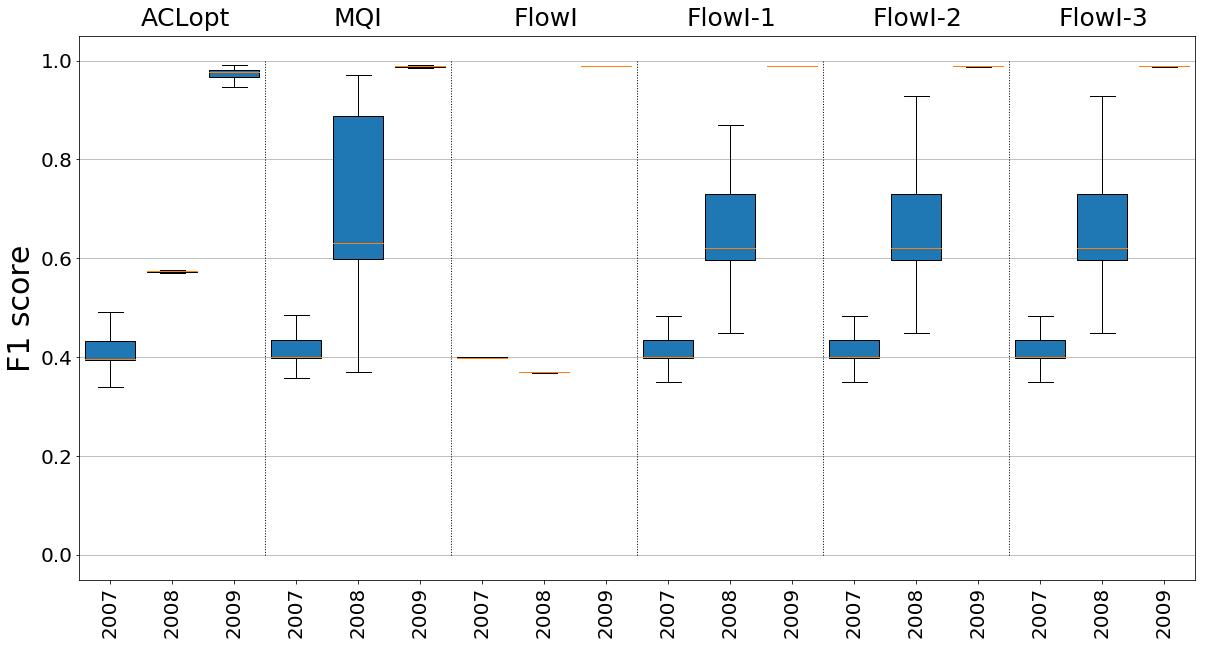

In [16]:
all_data = []
xlabels_ = []
    
for i in range(l_info_ref_nodes):
    temp_f1  = []
    
    for j in nodes[i]:
        temp_f1.append(f1score_best_cond_acl[i,j])
    all_data.append(temp_f1)

    xlabels_.append(int(info_ref_nodes[i,1]))
    
for i in range(l_info_ref_nodes):
    temp_f1  = []
    
    for j in nodes[i]:
        temp_f1.append(f1_mqi[i,j])
    all_data.append(temp_f1)
    
    xlabels_.append(int(info_ref_nodes[i,1]))
    
for i in range(l_info_ref_nodes):
    temp_f1  = []
    
    for j in nodes[i]:
        temp_f1.append(f1score_acl_flow_flowImprove[i,j])
    all_data.append(temp_f1)
    
    xlabels_.append(int(info_ref_nodes[i,1]))
    
for i in range(l_info_ref_nodes):
    temp_f1  = []
    
    for j in nodes[i]:
        temp_f1.append(f1_acl_flow_localflowImprove_parameter1[i,j])
    all_data.append(temp_f1)
    
    xlabels_.append(int(info_ref_nodes[i,1]))
    
for i in range(l_info_ref_nodes):
    temp_f1  = []
    
    for j in nodes[i]:
        temp_f1.append(f1_acl_flow_localflowImprove_parameter2[i,j])
    all_data.append(temp_f1)
    
    xlabels_.append(int(info_ref_nodes[i,1]))
    
for i in range(l_info_ref_nodes):
    temp_f1  = []
    
    for j in nodes[i]:
        temp_f1.append(f1_acl_flow_localflowImprove_parameter3[i,j])
    all_data.append(temp_f1)
    
    xlabels_.append(int(info_ref_nodes[i,1]))

fig = plt.figure(figsize=(20, 10))
axes = plt.gca()

# notch shape box plot
bplot2 = axes.boxplot(all_data,
                         notch=False,  # notch shape
                         vert=True,   # vertical box aligmnent
                         patch_artist=True,   # fill with color
                         showfliers=False,widths=0.8)

# adding horizontal grid lines
axes.yaxis.grid(True)
axes.set_xticks([y+1 for y in range(len(all_data))])
axes.set_ylabel('F1 score',fontsize=30)
#axes.set_xlabel('Year')

# add x-tick labels
#plt.setp(axes, xticks=[y+1 for y in range(len(all_data))],
#         xticklabels=[info_ref_nodes[0][1], info_ref_nodes[0][1], info_ref_nodes[0][1], info_ref_nodes[0][1]], info_ref_nodes[0][1], info_ref_nodes[0][1])

plt.setp(axes, xticks=[y+1 for y in range(len(all_data))],xticklabels=xlabels_)
axes.set_xticklabels(axes.xaxis.get_majorticklabels(), rotation=90)

axes.tick_params(labelsize=20)

plt.text(1.5, 1.07, 'ACLopt', fontsize=25)
plt.text(4.6, 1.07, 'MQI', fontsize=25)
plt.text(7.5, 1.07, 'FlowI', fontsize=25)
plt.text(10.3, 1.07, 'FlowI-1', fontsize=25)
plt.text(13.3, 1.07, 'FlowI-2', fontsize=25)
plt.text(16.3, 1.07, 'FlowI-3', fontsize=25)

#plt.text(0.75, 0.18, 'Prec.', fontsize=10, rotation=90)
#plt.text(1.8, 0.18, 'Rec.', fontsize=10, rotation=90)

plt.plot([3.5, 3.5], [0, 1], 'k:', linewidth=1)
plt.plot([6.5, 6.5], [0, 1], 'k:', linewidth=1)
plt.plot([9.5, 9.5], [0, 1], 'k:', linewidth=1)
plt.plot([12.5, 12.5], [0, 1], 'k:', linewidth=1)
plt.plot([15.5, 15.5], [0, 1], 'k:', linewidth=1)

plt.savefig('figures/boxplot_Colgate88_f1.png')

plt.show()

## Generate scatter plot for precision

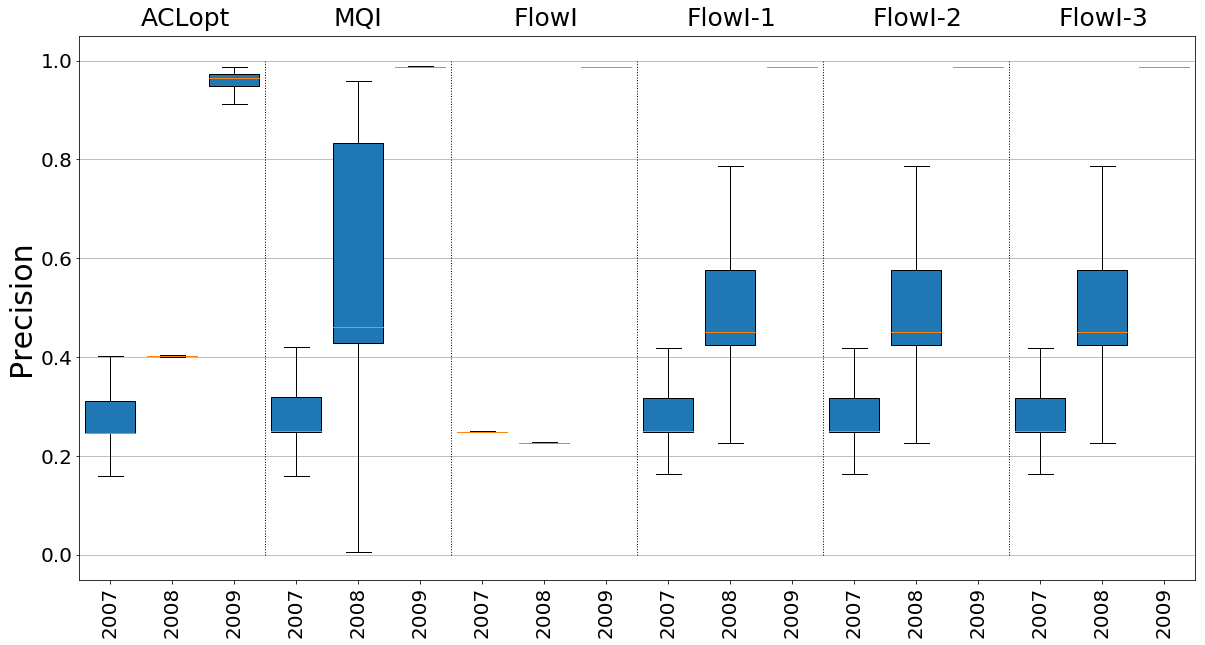

In [17]:
all_data = []
xlabels_ = []
    
for i in range(l_info_ref_nodes):
    temp_pre = []
    
    for j in nodes[i]:
        temp_pre.append(precision_best_cond_acl[i,j])
    all_data.append(temp_pre)

    xlabels_.append(int(info_ref_nodes[i,1]))
    
for i in range(l_info_ref_nodes):
    temp_pre = []
    
    for j in nodes[i]:
        temp_pre.append(precision_mqi[i,j])
    all_data.append(temp_pre)
    
    xlabels_.append(int(info_ref_nodes[i,1]))
    
for i in range(l_info_ref_nodes):
    temp_pre = []
    
    for j in nodes[i]:
        temp_pre.append(precision_acl_flow_localflowImprove[i,j])
    all_data.append(temp_pre)
    
    xlabels_.append(int(info_ref_nodes[i,1])) 
    
for i in range(l_info_ref_nodes):
    temp_pre = []
    
    for j in nodes[i]:
        temp_pre.append(precision_acl_flow_localflowImprove_parameter1[i,j])
    all_data.append(temp_pre)
    
    xlabels_.append(int(info_ref_nodes[i,1]))
    
for i in range(l_info_ref_nodes):
    temp_pre = []
    
    for j in nodes[i]:
        temp_pre.append(precision_acl_flow_localflowImprove_parameter2[i,j])
    all_data.append(temp_pre)
    
    xlabels_.append(int(info_ref_nodes[i,1]))
    
for i in range(l_info_ref_nodes):
    temp_pre = []
    
    for j in nodes[i]:
        temp_pre.append(precision_acl_flow_localflowImprove_parameter3[i,j])
    all_data.append(temp_pre)
    
    xlabels_.append(int(info_ref_nodes[i,1]))

fig = plt.figure(figsize=(20, 10))
axes = plt.gca()

# notch shape box plot
bplot2 = axes.boxplot(all_data,
                         notch=False,  # notch shape
                         vert=True,   # vertical box aligmnent
                         patch_artist=True,   # fill with color
                         showfliers=False,widths=0.8)

# adding horizontal grid lines
axes.yaxis.grid(True)
axes.set_xticks([y+1 for y in range(len(all_data))])
axes.set_ylabel('Precision',fontsize=30)
#axes.set_xlabel('Year')

# add x-tick labels
#plt.setp(axes, xticks=[y+1 for y in range(len(all_data))],
#         xticklabels=[info_ref_nodes[0][1], info_ref_nodes[0][1], info_ref_nodes[0][1], info_ref_nodes[0][1]], info_ref_nodes[0][1], info_ref_nodes[0][1])

plt.setp(axes, xticks=[y+1 for y in range(len(all_data))],xticklabels=xlabels_)
axes.set_xticklabels(axes.xaxis.get_majorticklabels(), rotation=90)

axes.tick_params(labelsize=20)

plt.text(1.5, 1.07, 'ACLopt', fontsize=25)
plt.text(4.6, 1.07, 'MQI', fontsize=25)
plt.text(7.5, 1.07, 'FlowI', fontsize=25)
plt.text(10.3, 1.07, 'FlowI-1', fontsize=25)
plt.text(13.3, 1.07, 'FlowI-2', fontsize=25)
plt.text(16.3, 1.07, 'FlowI-3', fontsize=25)

#plt.text(0.75, 0.18, 'Prec.', fontsize=10, rotation=90)
#plt.text(1.8, 0.18, 'Rec.', fontsize=10, rotation=90)

plt.plot([3.5, 3.5], [0, 1], 'k:', linewidth=1)
plt.plot([6.5, 6.5], [0, 1], 'k:', linewidth=1)
plt.plot([9.5, 9.5], [0, 1], 'k:', linewidth=1)
plt.plot([12.5, 12.5], [0, 1], 'k:', linewidth=1)
plt.plot([15.5, 15.5], [0, 1], 'k:', linewidth=1)

plt.savefig('figures/boxplot_Colgate88_precision.png')

plt.show()

## Generate scatter plot for recall

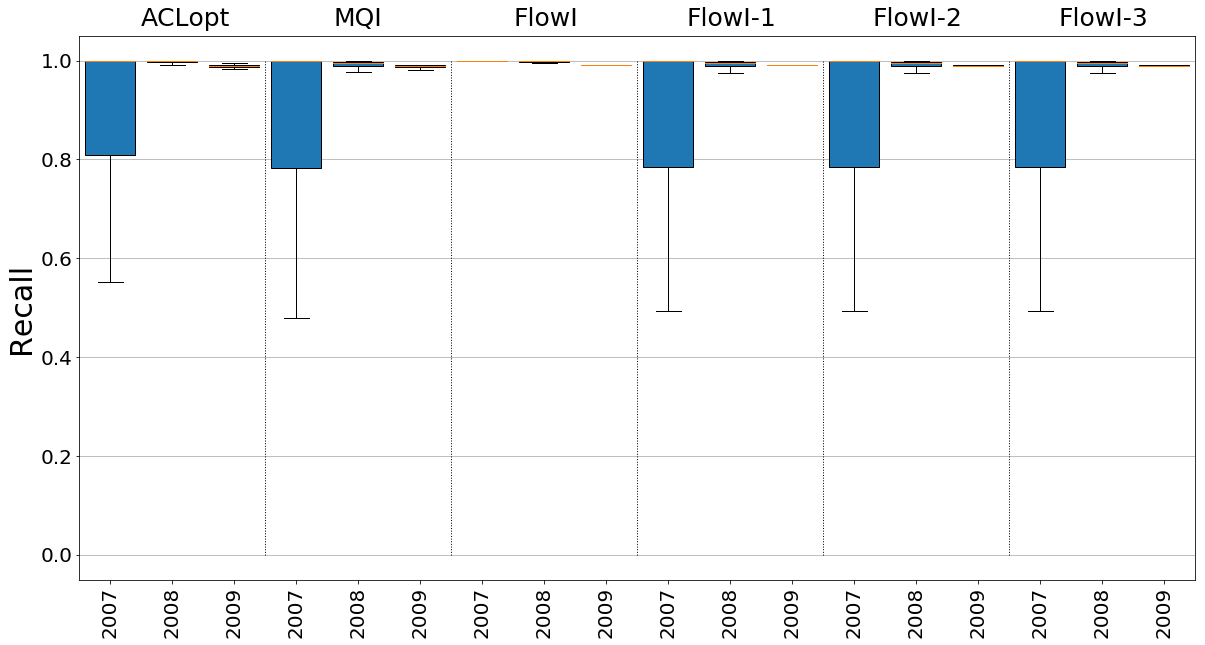

In [18]:
all_data = []
xlabels_ = []

for i in range(l_info_ref_nodes):
    temp_rec = []
    
    for j in nodes[i]:
        temp_rec.append(recall_best_cond_acl[i,j])
    all_data.append(temp_rec)

    xlabels_.append(int(info_ref_nodes[i,1]))

for i in range(l_info_ref_nodes):
    temp_rec = []
    
    for j in nodes[i]:
        temp_rec.append(recall_mqi[i,j])
    all_data.append(temp_rec)

    xlabels_.append(int(info_ref_nodes[i,1]))
    
for i in range(l_info_ref_nodes):
    temp_rec = []
    
    for j in nodes[i]:
        temp_rec.append(recall_acl_flow_localflowImprove[i,j])
    all_data.append(temp_rec)

    xlabels_.append(int(info_ref_nodes[i,1]))
    
for i in range(l_info_ref_nodes):
    temp_rec = []
    
    for j in nodes[i]:
        temp_rec.append(recall_acl_flow_localflowImprove_parameter1[i,j])
    all_data.append(temp_rec)

    xlabels_.append(int(info_ref_nodes[i,1]))
    
for i in range(l_info_ref_nodes):
    temp_rec = []
    
    for j in nodes[i]:
        temp_rec.append(recall_acl_flow_localflowImprove_parameter2[i,j])
    all_data.append(temp_rec)

    xlabels_.append(int(info_ref_nodes[i,1]))
    
for i in range(l_info_ref_nodes):
    temp_rec = []
    
    for j in nodes[i]:
        temp_rec.append(recall_acl_flow_localflowImprove_parameter3[i,j])
    all_data.append(temp_rec)

    xlabels_.append(int(info_ref_nodes[i,1]))

fig = plt.figure(figsize=(20, 10))
axes = plt.gca()

# notch shape box plot
bplot2 = axes.boxplot(all_data,
                         notch=False,  # notch shape
                         vert=True,   # vertical box aligmnent
                         patch_artist=True,   # fill with color
                         showfliers=False,widths=0.8)

# adding horizontal grid lines
axes.yaxis.grid(True)
axes.set_xticks([y+1 for y in range(len(all_data))])
axes.set_ylabel('Recall',fontsize=30)
#axes.set_xlabel('Year')

# add x-tick labels
#plt.setp(axes, xticks=[y+1 for y in range(len(all_data))],
#         xticklabels=[info_ref_nodes[0][1], info_ref_nodes[0][1], info_ref_nodes[0][1], info_ref_nodes[0][1]], info_ref_nodes[0][1], info_ref_nodes[0][1])

plt.setp(axes, xticks=[y+1 for y in range(len(all_data))],xticklabels=xlabels_)
axes.set_xticklabels(axes.xaxis.get_majorticklabels(), rotation=90)

axes.tick_params(labelsize=20)

plt.text(1.5, 1.07, 'ACLopt', fontsize=25)
plt.text(4.6, 1.07, 'MQI', fontsize=25)
plt.text(7.5, 1.07, 'FlowI', fontsize=25)
plt.text(10.3, 1.07, 'FlowI-1', fontsize=25)
plt.text(13.3, 1.07, 'FlowI-2', fontsize=25)
plt.text(16.3, 1.07, 'FlowI-3', fontsize=25)

#plt.text(0.75, 0.18, 'Prec.', fontsize=10, rotation=90)
#plt.text(1.8, 0.18, 'Rec.', fontsize=10, rotation=90)

plt.plot([3.5, 3.5], [0, 1], 'k:', linewidth=1)
plt.plot([6.5, 6.5], [0, 1], 'k:', linewidth=1)
plt.plot([9.5, 9.5], [0, 1], 'k:', linewidth=1)
plt.plot([12.5, 12.5], [0, 1], 'k:', linewidth=1)
plt.plot([15.5, 15.5], [0, 1], 'k:', linewidth=1)

plt.savefig('figures/boxplot_Colgate88_recall.png')

plt.show()

In [19]:
all_data = []
xlabels_ = []

print('Results for ACLopt')
for i in range(l_info_ref_nodes):
    temp_pre = []
    temp_rec = []
    temp_f1 = []
    
    for j in nodes[i]:
        temp_pre.append(precision_best_cond_acl[i,j])
        temp_rec.append(recall_best_cond_acl[i,j])
        temp_f1.append(f1score_best_cond_acl[i,j])

    print('Feature:', info_ref_nodes[i,1],'Precision', stat_.median(temp_pre), 'Recall', stat_.median(temp_rec), 'F1', stat_.median(temp_f1))
    
print('Results for MQI')
for i in range(l_info_ref_nodes):
    temp_pre = []
    temp_rec = []
    temp_f1 = []
    
    for j in nodes[i]:
        temp_pre.append(precision_mqi[i,j])
        temp_rec.append(recall_mqi[i,j])
        temp_f1.append(f1_mqi[i,j])
        
    print('Feature:', info_ref_nodes[i,1],'Precision', stat_.median(temp_pre), 'Recall', stat_.median(temp_rec), 'F1', stat_.median(temp_f1))
    
print('Results for FlowI')
for i in range(l_info_ref_nodes):
    temp_pre = []
    temp_rec = []
    temp_f1 = []
    
    for j in nodes[i]:
        temp_pre.append(precision_acl_flow_localflowImprove[i,j])
        temp_rec.append(recall_acl_flow_localflowImprove[i,j])
        temp_f1.append(f1score_acl_flow_flowImprove[i,j])
        
    print('Feature:', info_ref_nodes[i,1],'Precision', stat_.median(temp_pre), 'Recall', stat_.median(temp_rec), 'F1', stat_.median(temp_f1))
    
print('Results for FlowI-1')
for i in range(l_info_ref_nodes):
    temp_pre = []
    temp_rec = []
    temp_f1 = []
    
    for j in nodes[i]:
        temp_pre.append(precision_acl_flow_localflowImprove_parameter1[i,j])
        temp_rec.append(recall_acl_flow_localflowImprove_parameter1[i,j])
        temp_f1.append(f1_acl_flow_localflowImprove_parameter1[i,j])

    print('Feature:', info_ref_nodes[i,1],'Precision', stat_.median(temp_pre), 'Recall', stat_.median(temp_rec), 'F1', stat_.median(temp_f1))
    
print('Results for FlowI-2')
for i in range(l_info_ref_nodes):
    temp_pre = []
    temp_rec = []
    temp_f1 = []
    
    for j in nodes[i]:
        temp_pre.append(precision_acl_flow_localflowImprove_parameter2[i,j])
        temp_rec.append(recall_acl_flow_localflowImprove_parameter2[i,j])
        temp_f1.append(f1_acl_flow_localflowImprove_parameter2[i,j])
        
    print('Feature:', info_ref_nodes[i,1],'Precision', stat_.median(temp_pre), 'Recall', stat_.median(temp_rec), 'F1', stat_.median(temp_f1))
    
print('Results for FlowI-3')
for i in range(l_info_ref_nodes):
    temp_pre = []
    temp_rec = []
    temp_f1 = []
    
    for j in nodes[i]:
        temp_pre.append(precision_acl_flow_localflowImprove_parameter3[i,j])
        temp_rec.append(recall_acl_flow_localflowImprove_parameter3[i,j])
        temp_f1.append(f1_acl_flow_localflowImprove_parameter3[i,j])
        
    print('Feature:', info_ref_nodes[i,1],'Precision', stat_.median(temp_pre), 'Recall', stat_.median(temp_rec), 'F1', stat_.median(temp_f1))

Results for ACLopt
Feature: 2007 Precision 0.247360646422025 Recall 0.9995612816425615 F1 0.39628064977181293
Feature: 2008 Precision 0.4022074642264273 Recall 0.9987345624629579 F1 0.5734760429206582
Feature: 2009 Precision 0.9653852508674341 Recall 0.9898215951822217 F1 0.976535628246369
Results for MQI
Feature: 2007 Precision 0.25008228703849 Recall 0.9995612816425615 F1 0.39991338127029774
Feature: 2008 Precision 0.4614833515762051 Recall 0.9946899678034247 F1 0.6307576382090674
Feature: 2009 Precision 0.9876379441731816 Recall 0.9898215951822217 F1 0.9886504799548277
Results for FlowI
Feature: 2007 Precision 0.24930304479029275 Recall 1.0 F1 0.39907755398177214
Feature: 2008 Precision 0.22674335089290382 Recall 0.9987345624629579 F1 0.3695603210296149
Feature: 2009 Precision 0.987243030132357 Recall 0.9913483559048885 F1 0.9892646042292663
Results for FlowI-1
Feature: 2007 Precision 0.24979725729687896 Recall 0.9995612816425615 F1 0.39951740782110157
Feature: 2008 Precision 0.4515